In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import ttest_ind
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [3]:
import seaborn as sns

In [4]:
import math

In [5]:
from lifelines import KaplanMeierFitter, CoxPHFitter

In [6]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
import time

start_time = time.time()

housingHealth= pd.read_excel('data/housing_data_extended_240824.xlsx', engine='openpyxl')

end_time = time.time()

print(f"Load time: {end_time - start_time:.2f} seconds")

Load time: 466.90 seconds


In [8]:
housingHealthnew = housingHealth.copy()

In [9]:
housingHealthnew.head()

unique_ID  year_of_death popn_JCVI popn_Sex PRS_CAre_Home_Resident  \
0     142839              0        P6        M                      N   
1     661639              0        P3        F                      N   
2     948642              0        P7        F                      N   
3    2046034              0      P4.1        F                      N   
4    2348639              0        P6        M                      N   

  PRS_OCC_unpaid_carer  _1_SolidOrganTransplant  _2_Cancer  \
0                  NaN                      NaN        NaN   
1                  NaN                      NaN        NaN   
2                  NaN                      NaN        NaN   
3                    Y                      NaN        NaN   
4                  NaN                      NaN        NaN   

   _3_SevereRespiratory  _4_SevereSingleOrganDisease  ...  rownum  \
0                   NaN                          NaN  ...       1   
1                   NaN                          NaN  ...       1   
2                   NaN                          NaN  ...       1   
3                   NaN                          NaN  ...       1   
4                   NaN                          NaN  ...       1   

   age_in_years  primary_desc  tertiary_desc  current_energy_rating  \
0         50-59           NaN            NaN                    NaN   
1         70-79           NaN            NaN                    NaN   
2         60-69   Residential       Terraced                      D   
3         70-79   Residential  Semi-Detached                      C   
4         60-69           NaN            NaN                    NaN   

   current_energy_efficiency  transaction_type  lodgement_date  \
0                        NaN               NaN             NaT   
1                        NaN               NaN             NaT   
2                       65.0            rental      2021-10-06   
3                       72.0   rental (social)      2010-06-08   
4                        NaN               NaN             NaT   

             tenure  RSL  
0               NaN    0  
1               NaN    0  
2  Rented (private)    0  
3   rental (social)    0  
4               NaN    0  

[5 rows x 50 columns]

In [10]:
housingHealthnew.columns

Index(['unique_ID', 'year_of_death', 'popn_JCVI', 'popn_Sex',
       'PRS_CAre_Home_Resident', 'PRS_OCC_unpaid_carer',
       '_1_SolidOrganTransplant', '_2_Cancer', '_3_SevereRespiratory',
       '_4_SevereSingleOrganDisease', '_5_RareDiseases',
       '_6_ImmunosuppressionTherapy', '_7_PregnancyWithCongenitalHeartDisease',
       '_8_GPIdentifiedPatients', '_9_Renal_Dialysis', '_10_Other',
       '_11_AdultsWithDownsSyndrome', '_12_RenalCKD5', 'Charl_age_sc',
       'Charl_ami_sc', 'Charl_chf_sc', 'Charl_pvd_sc', 'Charl_cevd_sc',
       'Charl_dementia_sc', 'Charl_pulmonary_sc', 'Charl_Connective_Tissue_sc',
       'Charl_Peptic_Ulcer_sc', 'Charl_liver_disease_sc', 'Charl_diabetes_sc',
       'Charl_Complications_Diabetes_sc', 'Charl_Hemiplegia_sc',
       'Charl_renal_disease_sc', 'Charl_cancer_sc',
       'Charl_sever_liver_disease_sc', 'Charl_Metastatic_cancer_sc',
       'Charl_aids_sc', 'resp_admits', 'emergency_resp_admits', 'total_admits',
       'total_emergency_admits', 'row

In [11]:
housingHealthnew.isnull().sum()

unique_ID                                      0
year_of_death                                  0
popn_JCVI                                      8
popn_Sex                                     901
PRS_CAre_Home_Resident                        14
PRS_OCC_unpaid_carer                      480959
_1_SolidOrganTransplant                   473130
_2_Cancer                                 473130
_3_SevereRespiratory                      473130
_4_SevereSingleOrganDisease               473130
_5_RareDiseases                           473130
_6_ImmunosuppressionTherapy               473130
_7_PregnancyWithCongenitalHeartDisease    473130
_8_GPIdentifiedPatients                   473130
_9_Renal_Dialysis                         473130
_10_Other                                 473130
_11_AdultsWithDownsSyndrome               473130
_12_RenalCKD5                             473130
Charl_age_sc                                   0
Charl_ami_sc                              222289
Charl_chf_sc        

In [18]:
# Replace NULL values with 0 in the admission related columns
admission_columns = ['resp_admits', 'emergency_resp_admits', 'total_admits', 'total_emergency_admits']


In [19]:
housingHealthnew[admission_columns].head()

resp_admits  emergency_resp_admits  total_admits  total_emergency_admits
0            0                      0             2                       2
1            0                      0             0                       0
2            0                      0             2                       1
3            0                      0             0                       0
4            0                      0             0                       0

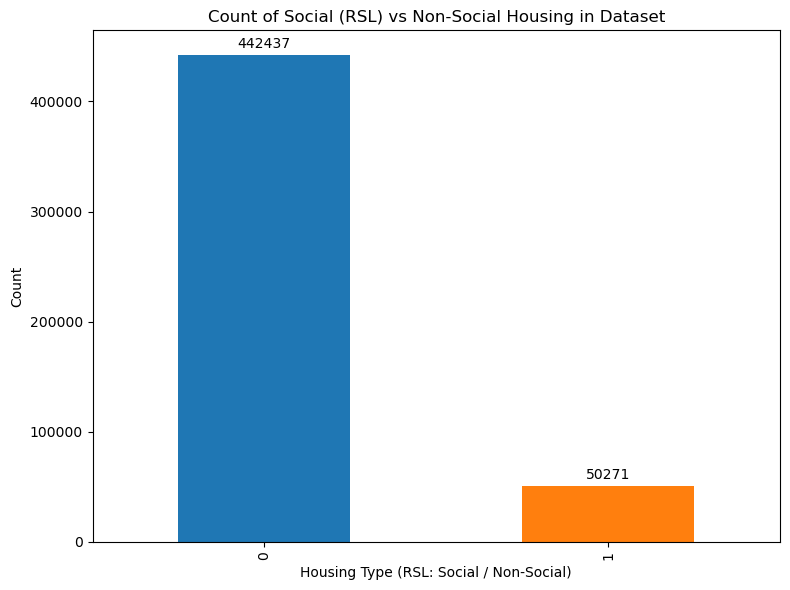

In [20]:
rsl_counts = housingHealthnew['RSL'].value_counts()

fig, ax = plt.subplots(figsize=(8, 6))
bars = rsl_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e'], ax=ax)

ax.set_xlabel('Housing Type (RSL: Social / Non-Social)')
ax.set_ylabel('Count')
ax.set_title('Count of Social (RSL) vs Non-Social Housing in Dataset')

for bar in bars.patches:
    ax.annotate(f'{int(bar.get_height())}', 
                (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                ha='center', va='center', xytext=(0, 8), textcoords='offset points')

plt.tight_layout()
plt.show()

In [21]:
# Count the total occurrences of RSL and non-RSL housing
rsl_counts = housingHealthnew['RSL'].value_counts()

# count of social and non-social housing
print(rsl_counts)

RSL
0    442437
1     50271
Name: count, dtype: int64


The dataset shows that out of the total population, 50,271 individuals (approximately 10.2%) reside in social housing (RSL), while 442,437 (89.8%) live in non-social housing. These figures provide a broad understanding of the housing distribution across the sample.

In [22]:
housingHealthnew['resp_admits'].sum()

44258

In [23]:
housingHealthnew['emergency_resp_admits'].sum()

40470

The total count with respiratory related conditions in the dataset is 44,258 respiratory admissions out of which 40,470 are emergency respiratory admissions. This suggests that respiratory conditions are common within the sample population and can be examined in context to housing status.

In [24]:
health_condition_features = [
    '_1_SolidOrganTransplant', '_2_Cancer', '_3_SevereRespiratory', '_4_SevereSingleOrganDisease',
    '_5_RareDiseases', '_6_ImmunosuppressionTherapy', '_7_PregnancyWithCongenitalHeartDisease',
    '_8_GPIdentifiedPatients', '_9_Renal_Dialysis', '_10_Other', '_11_AdultsWithDownsSyndrome', '_12_RenalCKD5'
]

#housingHealthnew[health_condition_features] =housingHealthnew[health_condition_features].fillna(0)

summary_stats = housingHealthnew[health_condition_features].agg(['mean', 'median', 'std', 'min', 'max']).T

summary_stats.columns = ['Mean', 'Median', 'Std Dev', 'Min', 'Max']

print(summary_stats)

                                            Mean  Median   Std Dev  Min  Max
_1_SolidOrganTransplant                 0.017520     0.0  0.131201  0.0  1.0
_2_Cancer                               0.178976     0.0  0.383342  0.0  1.0
_3_SevereRespiratory                    0.365308     0.0  0.481529  0.0  1.0
_4_SevereSingleOrganDisease             0.051844     0.0  0.221717  0.0  1.0
_5_RareDiseases                         0.365308     0.0  0.481529  0.0  1.0
_6_ImmunosuppressionTherapy             0.212841     0.0  0.409327  0.0  1.0
_7_PregnancyWithCongenitalHeartDisease  0.001022     0.0  0.031946  0.0  1.0
_8_GPIdentifiedPatients                 0.110839     0.0  0.313940  0.0  1.0
_9_Renal_Dialysis                       0.003422     0.0  0.058401  0.0  1.0
_10_Other                               0.013995     0.0  0.117474  0.0  1.0
_11_AdultsWithDownsSyndrome             0.008785     0.0  0.093320  0.0  1.0
_12_RenalCKD5                           0.016038     0.0  0.125626  0.0  1.0

The dataset contains 12 health condition features, including Solid Organ Transplant, Cancer, Severe Respiratory Disease, and other serious conditions. The mean values for these conditions are quite low and this reveals that most people do not suffer from these health problems (e. g. the mean value for Severe Respiratory Disease is 0. 365 while for Solid Organ Transplant is 0. 017). The given dataset is relatively fluctuating in some of the conditions, like Severe Respiratory Disease and Immunosuppression Therapy which have high standard deviation 

In [26]:
Charlson_Score = [
    'Charl_age_sc','Charl_ami_sc', 'Charl_chf_sc', 'Charl_pvd_sc', 'Charl_cevd_sc', 'Charl_dementia_sc',
    'Charl_pulmonary_sc', 'Charl_Connective_Tissue_sc', 'Charl_Peptic_Ulcer_sc', 'Charl_liver_disease_sc',
    'Charl_diabetes_sc', 'Charl_Complications_Diabetes_sc', 'Charl_Hemiplegia_sc', 'Charl_renal_disease_sc',
    'Charl_cancer_sc', 'Charl_sever_liver_disease_sc', 'Charl_Metastatic_cancer_sc', 'Charl_aids_sc'
]

#housingHealthnew[Charlson_Score] =housingHealthnew[Charlson_Score].fillna(0)


summary_stats_charl = housingHealthnew[Charlson_Score].agg(['mean', 'median', 'std', 'min', 'max']).T

summary_stats_charl.columns = ['Mean', 'Median', 'Std Dev', 'Min', 'Max']

print(summary_stats_charl)

                                     Mean  Median   Std Dev  Min  Max
Charl_age_sc                     0.953128     0.0  1.312403  0.0  4.0
Charl_ami_sc                     0.035145     0.0  0.184148  0.0  1.0
Charl_chf_sc                     0.031030     0.0  0.173398  0.0  1.0
Charl_pvd_sc                     0.016866     0.0  0.128771  0.0  1.0
Charl_cevd_sc                    0.048758     0.0  0.215361  0.0  1.0
Charl_dementia_sc                0.016781     0.0  0.128452  0.0  1.0
Charl_pulmonary_sc               0.150888     0.0  0.357940  0.0  1.0
Charl_Connective_Tissue_sc       0.017532     0.0  0.131243  0.0  1.0
Charl_Peptic_Ulcer_sc            0.016219     0.0  0.126318  0.0  1.0
Charl_liver_disease_sc           0.019958     0.0  0.139856  0.0  1.0
Charl_diabetes_sc                0.082428     0.0  0.275016  0.0  1.0
Charl_Complications_Diabetes_sc  0.011922     0.0  0.108536  0.0  1.0
Charl_Hemiplegia_sc              0.007200     0.0  0.084547  0.0  1.0
Charl_renal_disease_

The Charlson Comorbidity Index encompasses 18 variables which are used to assess the comorbidities of the given dataset. On average, the Charlson age-adjusted score is 0.953, indicating an older population with a variety of comorbid conditions. Cardiovascular conditions like AMI (Acute Myocardial Infarction) and CHF (Congestive Heart Failure) have low mean values of 0.035 and 0.031, respectively, suggesting that these conditions are relatively rare in the dataset. However, conditions like pulmonary disease (mean of 0.150) and diabetes (mean of 0.082) are more prevalent.

In [27]:
housingHealthnew['RSL'] = housingHealthnew['RSL'].fillna(0)
housingHealthnew['popn_Sex'] = housingHealthnew['popn_Sex'].fillna('Unknown')

# Counting male and female in social and non-social housing
gender_count = housingHealthnew.groupby(['popn_Sex', 'RSL']).size().unstack(fill_value=0)
gender_proportion = gender_count.div(gender_count.sum(axis=1), axis=0) * 100  # Calculate proportion

print("Gender Count in Social and Non-Social Housing:")
print(gender_count)

print("\nProportion of Gender in Social and Non-Social Housing (in %):")
print(gender_proportion)

# Counting the age groups in social and non-social housing
age_group_count = housingHealthnew.groupby(['age_in_years', 'RSL']).size().unstack(fill_value=0)
age_group_proportion = age_group_count.div(age_group_count.sum(axis=1), axis=0) * 100  # Calculate proportion

print("\nAge Group Count in Social and Non-Social Housing:")
print(age_group_count)

print("\nProportion of Age Groups in Social and Non-Social Housing (in %):")
print(age_group_proportion)

Gender Count in Social and Non-Social Housing:
RSL            0      1
popn_Sex               
F         219726  25862
M         221888  24275
U             54      2
Unknown      769    132

Proportion of Gender in Social and Non-Social Housing (in %):
RSL               0          1
popn_Sex                      
F         89.469355  10.530645
M         90.138648   9.861352
U         96.428571   3.571429
Unknown   85.349612  14.650388

Age Group Count in Social and Non-Social Housing:
RSL               0     1
age_in_years             
0-9           37589  6332
10-19         46415  8207
20-29         49701  6864
30-39         59918  7381
40-49         53444  6067
50-59         59670  5788
60-69         55446  4761
70-79         45969  3067
80-89         26253  1377
90+            8032   427

Proportion of Age Groups in Social and Non-Social Housing (in %):
RSL                   0          1
age_in_years                      
0-9           85.583206  14.416794
10-19         84.974919  

The total number of females in the non-social housing includes 219,726 while there were only 25,862 females in the social housing.  Likewise, 221,888 male individuals found in non-social housing, while 24275 of them live in social housing. A few people are classified under ‘Unknown’ or ‘U’ which signifies that sex data is missing, incomplete or not readily available. Male and female representations threshold exist in that, out of the total number of the characters, 89. 5% of females and 90.1% of males are in non-social housing, with 10.5% of females and 9.9% of males in social housing.


According to the age distribution of the population, living in social and non-social housing in the analysed regions, younger generations, 0 to 9 years (85. 6%) and 10 to 19 years (85%) prefer non-social housing. It is observed that with an increasing population, the proportion of elderly or senior citizens residing in social housing slightly reduces. For instance, among the population of 70-79 years 93.7 % are in non-social housing and of those just 6. 3% in social housing. This trend goes on to the 90+ age groups with the former having 94. 9% of those living in non-social housing, and 5.1% in social housing, suggesting that non-social housing is more prevalent across all age groups.

### 	Do residents of social housing have more planned and emergency hospital admissions than people in other tenures, over a given time period?

In [28]:
# Calculate planned respiratory admissions
housingHealthnew['planned_resp_admits'] = housingHealthnew['resp_admits'] - housingHealthnew['emergency_resp_admits']

# Calculate total planned admissions
housingHealthnew['total_planned_admissions'] = housingHealthnew['total_admits'] - housingHealthnew['total_emergency_admits']

# Calculate planned admissions excluding respiratory admissions
housingHealthnew['non_resp_planned_admissions'] = housingHealthnew['total_planned_admissions'] - housingHealthnew['planned_resp_admits']

# Display the updated dataframe with new columns for verification
print(housingHealthnew[['RSL', 'total_planned_admissions', 'planned_resp_admits', 'non_resp_planned_admissions']])

        RSL  total_planned_admissions  planned_resp_admits  \
0         0                         0                    0   
1         0                         0                    0   
2         0                         1                    0   
3         0                         0                    0   
4         0                         0                    0   
...     ...                       ...                  ...   
492703    0                         1                    0   
492704    0                         0                    0   
492705    0                         0                    0   
492706    0                         4                    0   
492707    0                         0                    0   

        non_resp_planned_admissions  
0                                 0  
1                                 0  
2                                 1  
3                                 0  
4                                 0  
...                        

In [29]:
# Group by tenure type
grouped_data = housingHealthnew.groupby('RSL').agg({
    'total_planned_admissions': 'sum',
    'total_emergency_admits': 'sum',
    'total_admits': 'sum'
}).reset_index()

# proportions of planned and emergency admissions
grouped_data['planned_admission_proportion'] = grouped_data['total_planned_admissions'] / grouped_data['total_admits']
grouped_data['emergency_admission_proportion'] = grouped_data['total_emergency_admits'] / grouped_data['total_admits']

print(grouped_data)

   RSL  total_planned_admissions  total_emergency_admits  total_admits  \
0    0                    148879                  237181        386060   
1    1                     18229                   38625         56854   

   planned_admission_proportion  emergency_admission_proportion  
0                      0.385637                        0.614363  
1                      0.320628                        0.679372  


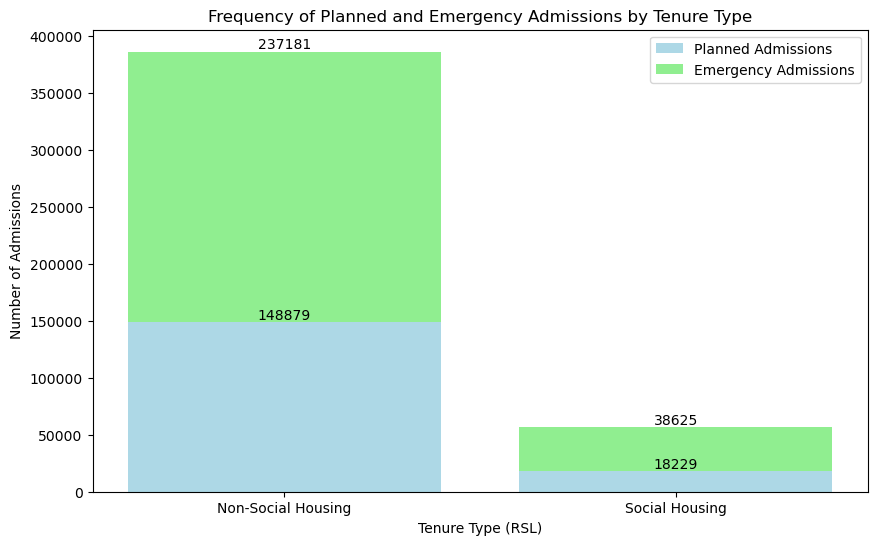

In [30]:
# Bar chart for planned and emergency admissions
plt.figure(figsize=(10, 6))

# bars for planned admissions
plt.bar(grouped_data['RSL'].astype(str), grouped_data['total_planned_admissions'], color='lightblue', label='Planned Admissions')

# bars for emergency admissions stacked on top of planned admissions
plt.bar(grouped_data['RSL'].astype(str), grouped_data['total_emergency_admits'], bottom=grouped_data['total_planned_admissions'], color='lightgreen', label='Emergency Admissions')

# counts on the planned admissions bars
for i, value in enumerate(grouped_data['total_planned_admissions']):
    plt.text(i, value + 0.5, int(value), ha='center', va='bottom')

# counts on the emergency admissions bars
for i, (planned, emergency) in enumerate(zip(grouped_data['total_planned_admissions'], grouped_data['total_emergency_admits'])):
    plt.text(i, planned + emergency + 0.5, int(emergency), ha='center', va='bottom')

plt.xlabel('Tenure Type (RSL)')
plt.ylabel('Number of Admissions')
plt.title('Frequency of Planned and Emergency Admissions by Tenure Type')

plt.xticks([0, 1], ['Non-Social Housing', 'Social Housing'])
plt.legend()
plt.show()

The research concerns a comparison of planned and emergency admissions within the residents of the social RSL housing and those who are in non-RSL housing. The data was then subjected into computation to obtain, planned respiratory admission, total planned admission and non-respiratory planned admission for each of the individuals. This was done to identify both total planned and emergency admissions and percentages planned and emergency for each tenure type of social and non-social housing.
The results indicate that in non-social housing there were 148,879 planned admissions and 237,181 emergency admissions in total 386,060 admissions. In contrast, social housing residents had 18,229 planned admissions and 38,625 emergency admissions, totalling 56,854 admissions. The proportion of planned admissions in non-social housing was 38.6%, whereas for social housing residents, it was slightly lower at 32.1%. Conversely, the proportion of emergency admissions was higher for social housing residents (67.9%) compared to those in non-social housing (61.4%).

Based on these results, residents of social housing have a significantly greater percentage of emergency hospital admissions than residents of non-social housing. The contribution of emergency admissions is higher in social housing despite having overall fewer admissions because social homes accommodate fewer people. This could mean that people living in social housing may not be able to attend planned appointments or they might have worse health in general so that they require more emergency care.


This comparison is shown on the bar chart above qualified by the planned and emergency admissions of both housing groups with the bars divided into sections. The chart highlights the disparity in admission types, with social housing residents having a larger portion of emergency admissions, answering the research question: There is evidence that individuals living in social housing do have high rates of emergency hospitalization and significantly lower rates of planned hospitalizations, while the rates are relatively equal among other household occupants.

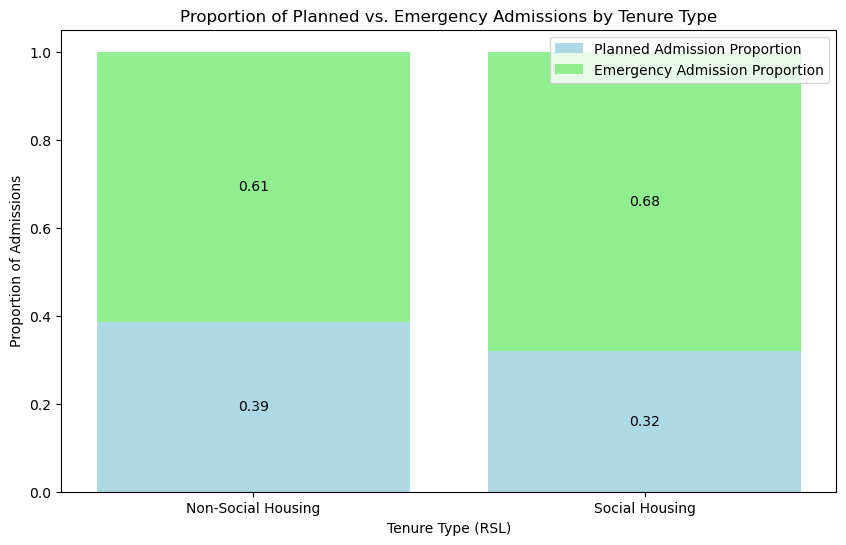

In [31]:
# Stacked bar chart for proportions of admissions
plt.figure(figsize=(10, 6))

# planned admission proportion
plt.bar(grouped_data['RSL'].astype(str), grouped_data['planned_admission_proportion'], color='lightblue', label='Planned Admission Proportion')

# emergency admission proportion stacked on top of planned admission proportion
plt.bar(grouped_data['RSL'].astype(str), grouped_data['emergency_admission_proportion'], bottom=grouped_data['planned_admission_proportion'], color='lightgreen', label='Emergency Admission Proportion')

# annotations for planned admission proportion
for i, value in enumerate(grouped_data['planned_admission_proportion']):
    plt.text(i, value / 2, f"{value:.2f}", ha='center', va='center')

# annotations for emergency admission proportion
for i, (planned, emergency) in enumerate(zip(grouped_data['planned_admission_proportion'], grouped_data['emergency_admission_proportion'])):
    plt.text(i, planned + emergency / 2, f"{emergency:.2f}", ha='center', va='center')


plt.xlabel('Tenure Type (RSL)')
plt.ylabel('Proportion of Admissions')
plt.title('Proportion of Planned vs. Emergency Admissions by Tenure Type')

plt.xticks([0, 1], ['Non-Social Housing', 'Social Housing'])
plt.legend()
plt.show()

This stacked bar chart in above barchart shows a relative ratio of planned and emergency admissions of the patients living in social and non-social houses. From the above chart, it can be observed that social housing patients have a higher proportion of emergency admissions compared to the non-social housing patients, this reinforces the existence of the social gap in accessing planned healthcare.

From the analysis of the data which was obtained the study shows that people in social housing take more emergency admissions (67. 94%) than other people in non-social housing (61. 44%). Whereas the percentage of planned admission is slightly low in the social housing (32.06%) than the non-social housing (38.56%). Although the total number of admissions of non-social housing is higher than the total number of admissions of social housing since it is home to more people, that highlight shows that the rates of emergency admissions for the residents of social housing is higher and that means they possibly require more attention to their health issues or, negatively, they have fewer chances to get planned check-ups. As a result, we can concluded that according to the data the residents of the social houses have more emergency admission compared to their total admissions in hospitals than those in other tenures.


### 	What are these admissions for?

How Health and Charlson Score are correlated to the admissions

The analysis was to investigate the relationship between different health conditions and the Charlson Comorbidity Index and planned and emergency admission. The Charlson Score was also employed to determine the comorbid condition existence and to estimate its influence on the number of admissions. The independent specific health conditions were also examined to evaluate their endowment to causes of admissions.

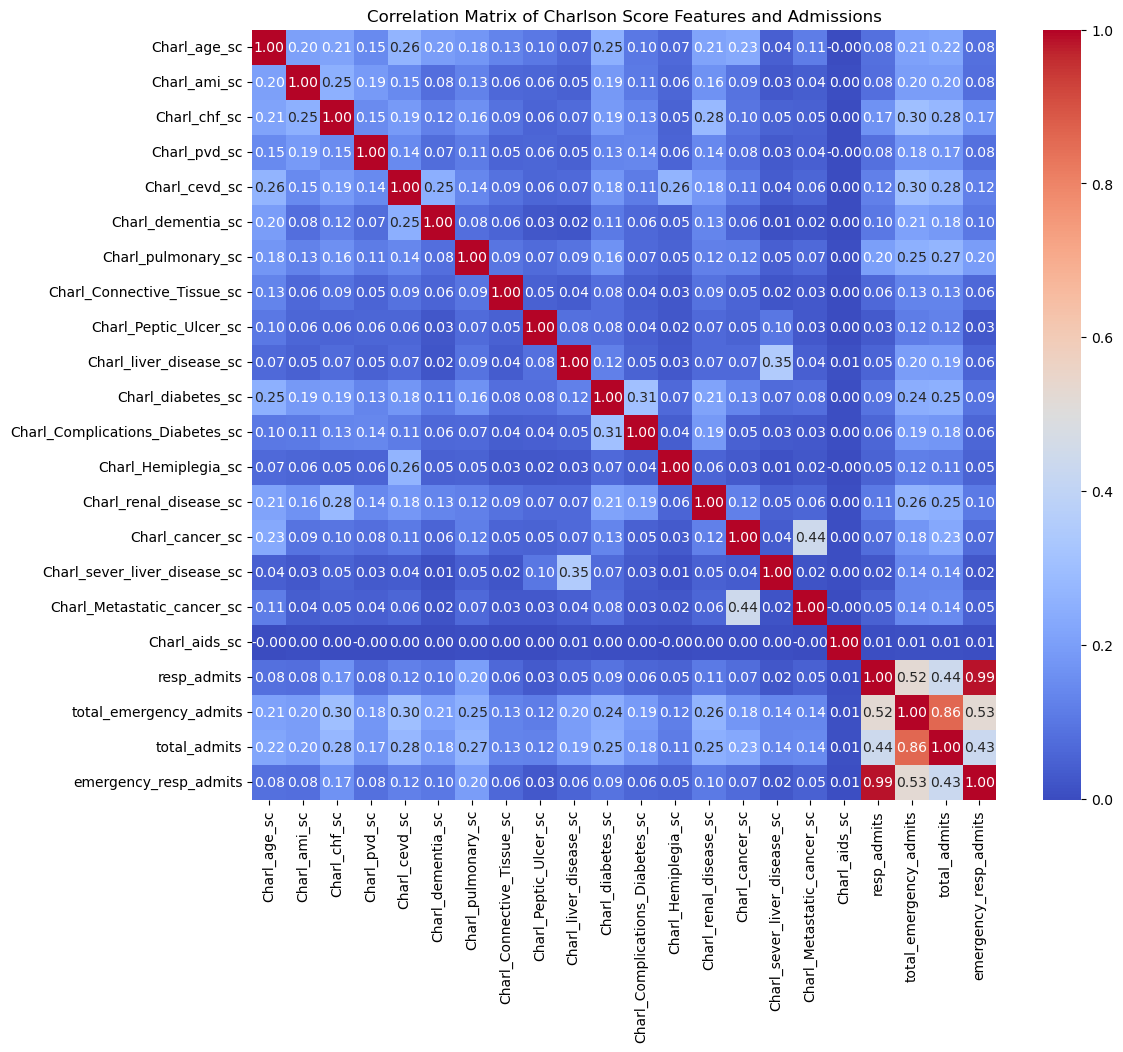

In [32]:
# List of  Charlson score columns
Charlson_Score_features = [
    'Charl_age_sc', 'Charl_ami_sc', 'Charl_chf_sc', 'Charl_pvd_sc', 'Charl_cevd_sc', 'Charl_dementia_sc',
    'Charl_pulmonary_sc', 'Charl_Connective_Tissue_sc', 'Charl_Peptic_Ulcer_sc', 'Charl_liver_disease_sc',
    'Charl_diabetes_sc', 'Charl_Complications_Diabetes_sc', 'Charl_Hemiplegia_sc', 'Charl_renal_disease_sc',
    'Charl_cancer_sc', 'Charl_sever_liver_disease_sc', 'Charl_Metastatic_cancer_sc', 'Charl_aids_sc'
]

housingHealthnew[Charlson_Score_features] = housingHealthnew[Charlson_Score_features].fillna(0)

# Calculate the correlation matrix
correlation_matrix = housingHealthnew[Charlson_Score_features + [ 'resp_admits','total_emergency_admits','total_admits', 'emergency_resp_admits']].corr()

# Plot the heatmap for visualization
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Charlson Score Features and Admissions')
plt.show()

Charlson Comorbidity Score and Admissions: Some of the Charlson score items, were found to be even more significantly related to respiratory and total emergency admissions. Pulmonary disease, diabetes, and heart failure were found to have a consistent association with a higher number of admissions specifically emergency admissions where the corresponding condition score likewise has a strong positive correlation with the rate of admission. This indicates the chronic condition intensity for the patients by suggesting that those who have severe or more than one chronic illness are likely to be admitted through the emergency doors as opposed to elective ones due to the acute care requirements of the conditions.

Above heatmap shows the relationship of different components of Charlson Comorbidity Index and admissions to the hospital. However, stronger relationships are found regarding other diseases for example pulmonary as well as renal diseases with total and especially emergency admissions which implies that these diseases have higher chances of requiring hospital admission


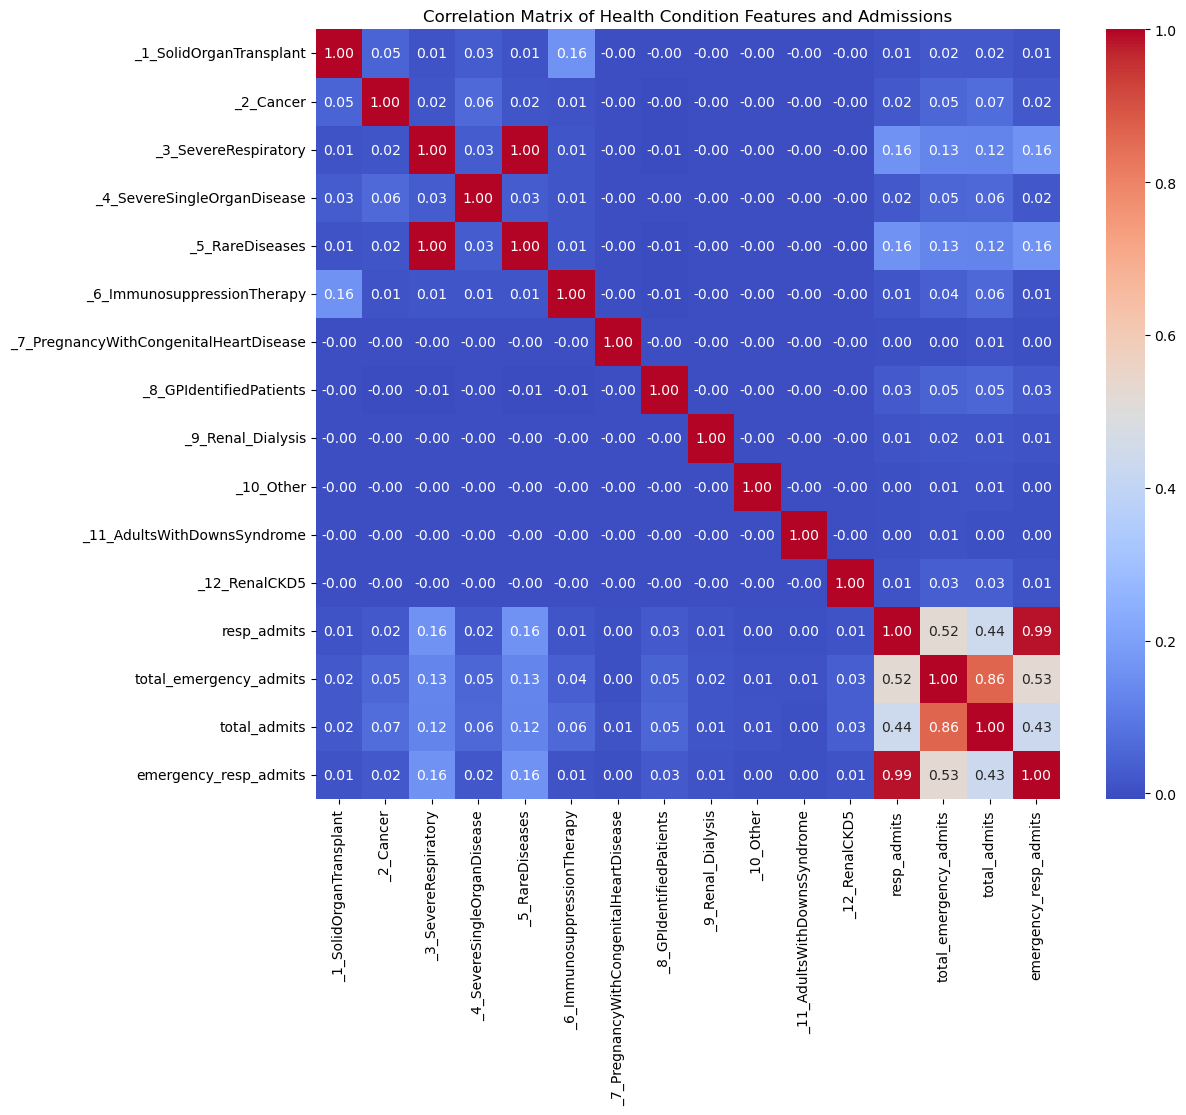

In [33]:
#  health condition columns apart from Charlson score columns
health_condition_features = [
    '_1_SolidOrganTransplant', '_2_Cancer', '_3_SevereRespiratory', '_4_SevereSingleOrganDisease',
    '_5_RareDiseases', '_6_ImmunosuppressionTherapy', '_7_PregnancyWithCongenitalHeartDisease',
    '_8_GPIdentifiedPatients', '_9_Renal_Dialysis', '_10_Other', '_11_AdultsWithDownsSyndrome', '_12_RenalCKD5'
]


housingHealthnew[health_condition_features] = housingHealthnew[health_condition_features].fillna(0)
# Calculate the correlation matrix
correlation_matrix = housingHealthnew[health_condition_features + [ 'resp_admits','total_emergency_admits','total_admits', 'emergency_resp_admits']].corr()

# Plot the heatmap for visualization
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Health Condition Features and Admissions')
plt.show()


Health Conditions and Admissions: The same correlation was observed for other health conditions like, cancer, severe respiratory disease, and immunosuppression for which the correlation coefficients with different types of admission were also positive and statistically significant especially for emergency admissions. These, for instance, were closely linked to emergency respiratory admissions meaning that SRMD conditions and SOTs particularly result to unplanned and urgent admissions.

Above Heatmap shows a relationship between different diseases and hospitalization. This reveals that some indicators like severe respiratory disease and renal dialysis have high positive association with both total and emergency admissions. This means that people with these diseases are more prone to be admitted in hospitals, especially through emergencies. The matrix aids in determining which ailments are most likely to attract higher admissions into the hospital.
The findings underscore the fact that the presence of an increased number of both comorbidities (as estimated by the Charlson Score) and definite diseases is associated with increased rates of emergency hospitalisation. This implies that the admissions of the residents particularly those in the social housing are likely to be caused by severe, chronic health complications thus contributing to the unplanned admission as compared to the planned admissions.


### Which chronic conditions are more prevalent among social housing residents.

The research question aimed to explore the relationship between social housing tenure and the prevalence of chronic health conditions with special focus on heart disease, diabetes, and respiratory diseases. This was achieved by determining the prevalence of Charlson Comorbidity Index conditions in RSLs with RSL = 1 and those with RSL = 0.

   RSL  Charl_age_sc  Charl_ami_sc  Charl_chf_sc  Charl_pvd_sc  Charl_cevd_sc  \
0    0      0.766927      0.014834      0.013164      0.007023       0.020790   
1    1      0.632992      0.020790      0.017579      0.011096       0.026399   

   Charl_dementia_sc  Charl_pulmonary_sc  Charl_Connective_Tissue_sc  \
0           0.007556            0.060566                    0.007449   
1           0.004430            0.125513                    0.009796   

   Charl_Peptic_Ulcer_sc  Charl_liver_disease_sc  Charl_diabetes_sc  \
0               0.006755                0.007906           0.034129   
1               0.010649                0.017823           0.056457   

   Charl_Complications_Diabetes_sc  Charl_Hemiplegia_sc  \
0                         0.004847             0.002939   
1                         0.009206             0.005426   

   Charl_renal_disease_sc  Charl_cancer_sc  Charl_sever_liver_disease_sc  \
0                0.012211         0.024085                      0.00236

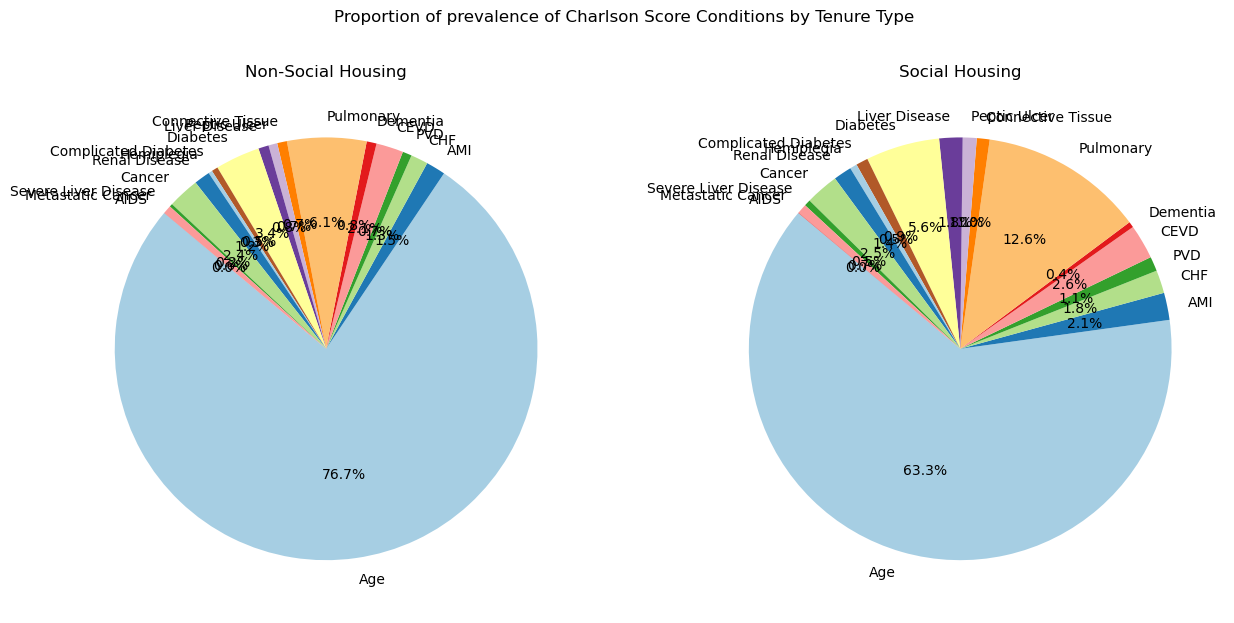

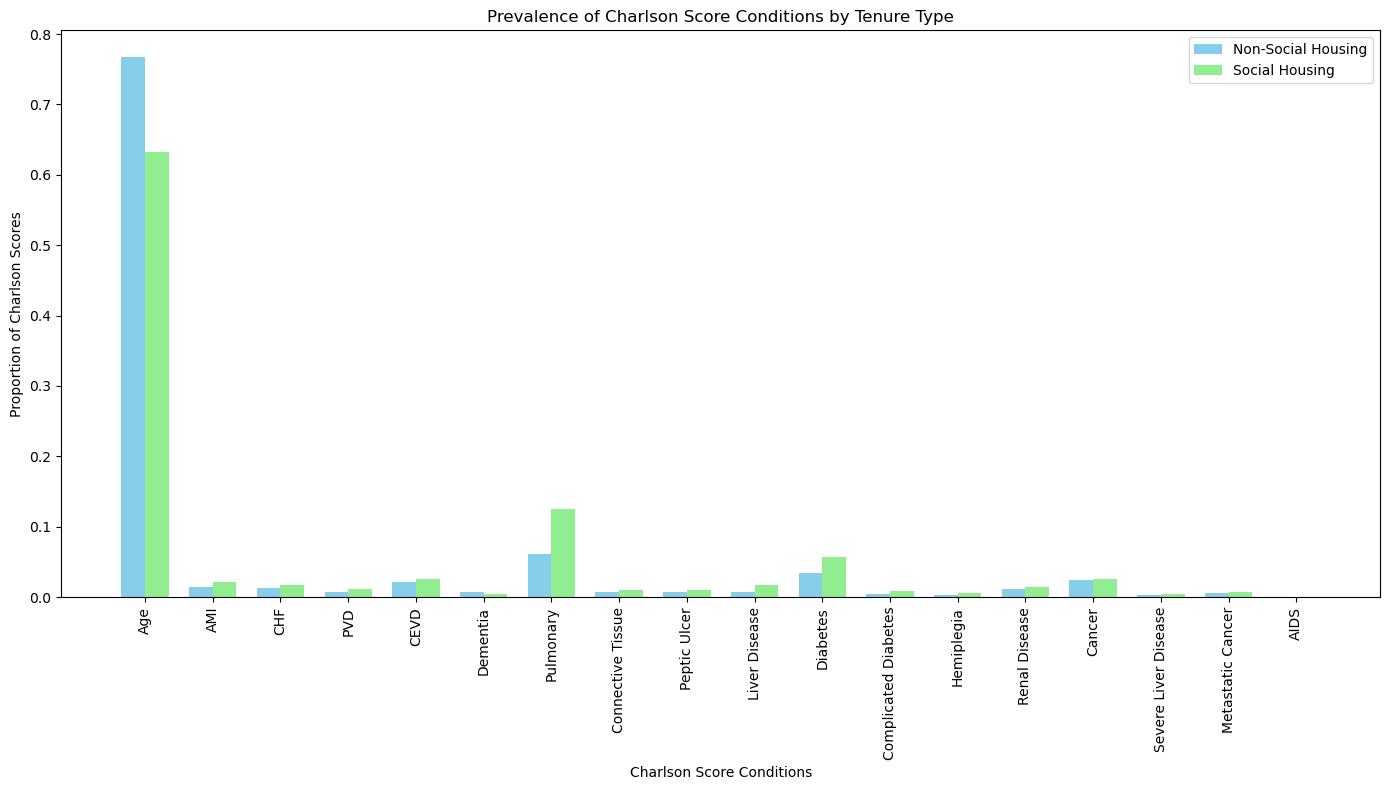

In [34]:
# List of Charlson Score columns
Charlson_Score = [
    'Charl_age_sc', 'Charl_ami_sc', 'Charl_chf_sc', 'Charl_pvd_sc', 'Charl_cevd_sc', 'Charl_dementia_sc',
    'Charl_pulmonary_sc', 'Charl_Connective_Tissue_sc', 'Charl_Peptic_Ulcer_sc', 'Charl_liver_disease_sc',
    'Charl_diabetes_sc', 'Charl_Complications_Diabetes_sc', 'Charl_Hemiplegia_sc', 'Charl_renal_disease_sc',
    'Charl_cancer_sc', 'Charl_sever_liver_disease_sc', 'Charl_Metastatic_cancer_sc', 'Charl_aids_sc'
]


housingHealthnew[Charlson_Score] = housingHealthnew[Charlson_Score].fillna(0)


# Calculate the sum for each condition by RSL (social vs. non-social housing)
grouped_conditions = housingHealthnew.groupby('RSL')[Charlson_Score].sum().reset_index()


# Calculate the total Charlson score for each tenure type
grouped_conditions['total_score'] = grouped_conditions[Charlson_Score].sum(axis=1)

# Convert absolute counts to proportions by dividing each condition by the total score for that group
for condition in Charlson_Score:
    grouped_conditions[condition] = grouped_conditions[condition] / grouped_conditions['total_score']

# Display the grouped data for verification
print(grouped_conditions)

# Create Pie Charts
# Define labels for the pie chart based on Charlson Score conditions
condition_labels = [
    'Age', 'AMI', 'CHF', 'PVD', 'CEVD', 'Dementia', 'Pulmonary', 'Connective Tissue', 'Peptic Ulcer',
    'Liver Disease', 'Diabetes', 'Complicated Diabetes', 'Hemiplegia', 'Renal Disease',
    'Cancer', 'Severe Liver Disease', 'Metastatic Cancer', 'AIDS'
]

# Pie chart for Non-Social Housing
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.pie(grouped_conditions.loc[grouped_conditions['RSL'] == 0, Charlson_Score].values[0],
        labels=condition_labels, autopct='%1.1f%%', startangle=140,
        colors=plt.cm.Paired.colors)  # Using a colormap for better differentiation
plt.title('Non-Social Housing')

# Pie chart for Social Housing
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.pie(grouped_conditions.loc[grouped_conditions['RSL'] == 1, Charlson_Score].values[0],
        labels=condition_labels, autopct='%1.1f%%', startangle=140,
        colors=plt.cm.Paired.colors)
plt.title('Social Housing')

plt.suptitle('Proportion of prevalence of Charlson Score Conditions by Tenure Type')
plt.show()


bar_width = 0.35
condition_positions = np.arange(len(Charlson_Score))

plt.figure(figsize=(14, 8))

# Bar chart for Non-Social Housing (RSL = 0)
plt.bar(condition_positions, grouped_conditions.loc[grouped_conditions['RSL'] == 0, Charlson_Score].values[0],
        width=bar_width, color='skyblue', label='Non-Social Housing')

# Bar chart for Social Housing (RSL = 1)
plt.bar(condition_positions + bar_width, grouped_conditions.loc[grouped_conditions['RSL'] == 1, Charlson_Score].values[0],
        width=bar_width, color='lightgreen', label='Social Housing')

plt.xlabel('Charlson Score Conditions')
plt.ylabel('Proportion of Charlson Scores')
plt.title('Prevalence of Charlson Score Conditions by Tenure Type')
plt.xticks(condition_positions + bar_width / 2, condition_labels, rotation=90)  
plt.legend()

plt.tight_layout()
plt.show()

   RSL  Charl_ami_sc  Charl_chf_sc  Charl_pvd_sc  Charl_cevd_sc  \
0    0      0.063646      0.056479      0.030131       0.089199   
1    1      0.056648      0.047899      0.030234       0.071931   

   Charl_dementia_sc  Charl_pulmonary_sc  Charl_Connective_Tissue_sc  \
0           0.032420            0.259861                    0.031962   
1           0.012072            0.341990                    0.026690   

   Charl_Peptic_Ulcer_sc  Charl_liver_disease_sc  Charl_diabetes_sc  \
0               0.028983                0.033921           0.146429   
1               0.029016                0.048563           0.153829   

   Charl_Complications_Diabetes_sc  Charl_Hemiplegia_sc  \
0                         0.020795             0.012608   
1                         0.025084             0.014785   

   Charl_renal_disease_sc  Charl_cancer_sc  Charl_sever_liver_disease_sc  \
0                0.052389         0.103338                      0.010139   
1                0.037820         0.0

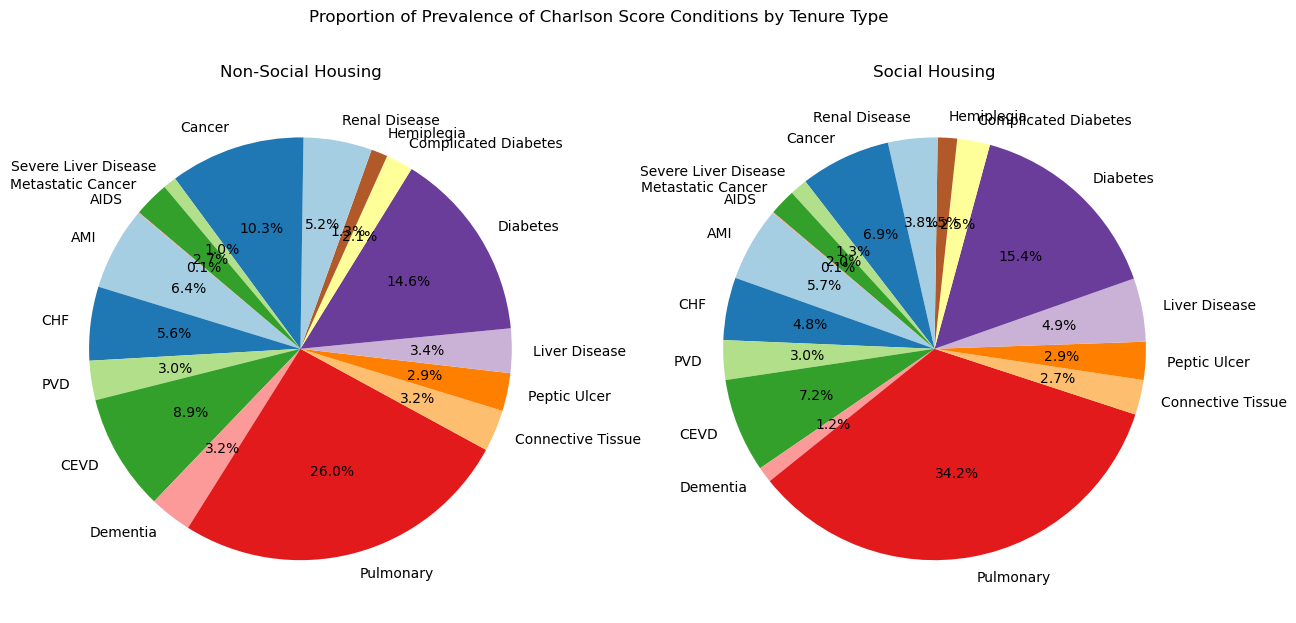

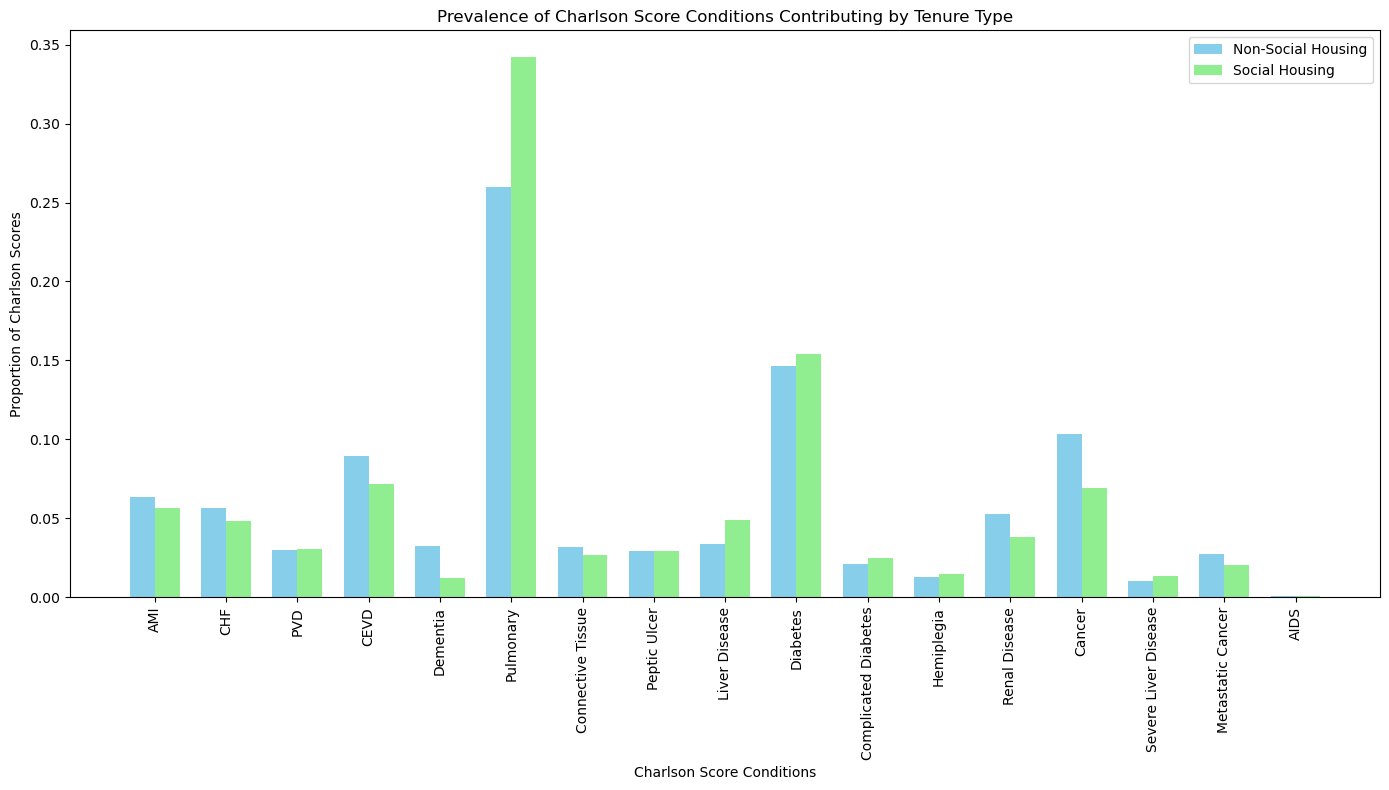

In [35]:

# Excluded the Charl_age_sc for better visualization of other features

Charlson_Score = [
    'Charl_ami_sc', 'Charl_chf_sc', 'Charl_pvd_sc', 'Charl_cevd_sc', 'Charl_dementia_sc',
    'Charl_pulmonary_sc', 'Charl_Connective_Tissue_sc', 'Charl_Peptic_Ulcer_sc', 'Charl_liver_disease_sc',
    'Charl_diabetes_sc', 'Charl_Complications_Diabetes_sc', 'Charl_Hemiplegia_sc', 'Charl_renal_disease_sc',
    'Charl_cancer_sc', 'Charl_sever_liver_disease_sc', 'Charl_Metastatic_cancer_sc', 'Charl_aids_sc'
]


housingHealthnew[Charlson_Score] = housingHealthnew[Charlson_Score].fillna(0)

# Sum up admissions for each condition by RSL (social vs. non-social housing)
grouped_conditions = housingHealthnew.groupby('RSL')[Charlson_Score].sum().reset_index()

# Calculate the total Charlson score for each tenure type (RSL group)
grouped_conditions['total_score'] = grouped_conditions[Charlson_Score].sum(axis=1)

# Convert absolute counts to proportions by dividing each condition by the total score for that group
for condition in Charlson_Score:
    grouped_conditions[condition] = grouped_conditions[condition] / grouped_conditions['total_score']

# Display the grouped data for verification
print(grouped_conditions)

# Define labels for the pie chart based on Charlson Score conditions
condition_labels = [
    'AMI', 'CHF', 'PVD', 'CEVD', 'Dementia', 'Pulmonary', 'Connective Tissue', 'Peptic Ulcer',
    'Liver Disease', 'Diabetes', 'Complicated Diabetes', 'Hemiplegia', 'Renal Disease',
    'Cancer', 'Severe Liver Disease', 'Metastatic Cancer', 'AIDS'
]

# Pie chart for Non-Social Housing (RSL = 0)
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.pie(grouped_conditions.loc[grouped_conditions['RSL'] == 0, Charlson_Score].values[0],
        labels=condition_labels, autopct='%1.1f%%', startangle=140,
        colors=plt.cm.Paired.colors)  # Using a colormap for better differentiation
plt.title('Non-Social Housing')

# Pie chart for Social Housing (RSL = 1)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.pie(grouped_conditions.loc[grouped_conditions['RSL'] == 1, Charlson_Score].values[0],
        labels=condition_labels, autopct='%1.1f%%', startangle=140,
        colors=plt.cm.Paired.colors)
plt.title('Social Housing')

plt.suptitle('Proportion of Prevalence of Charlson Score Conditions by Tenure Type')
plt.show()

bar_width = 0.35
condition_positions = np.arange(len(Charlson_Score))

plt.figure(figsize=(14, 8))

# Bar chart for Non-Social Housing (RSL = 0)
plt.bar(condition_positions, grouped_conditions.loc[grouped_conditions['RSL'] == 0, Charlson_Score].values[0],
        width=bar_width, color='skyblue', label='Non-Social Housing')

# Bar chart for Social Housing (RSL = 1)
plt.bar(condition_positions + bar_width, grouped_conditions.loc[grouped_conditions['RSL'] == 1, Charlson_Score].values[0],
        width=bar_width, color='lightgreen', label='Social Housing')

plt.xlabel('Charlson Score Conditions')
plt.ylabel('Proportion of Charlson Scores')
plt.title('Prevalence of Charlson Score Conditions Contributing by Tenure Type')
plt.xticks(condition_positions + bar_width / 2, condition_labels, rotation=90)  # Rotate labels for better readability
plt.legend()

plt.tight_layout()
plt.show()

1. Prevalence of Respiratory (Pulmonary) Conditions
From these results, it is evident that respiratory diseases or pulmonary diseases remain the major health concern in most social housing. Pulmonary conditions represent 34.2% of the conditions on the Charlson Score in social housing, which is a greater percentage than the 26% in non-social housing. This implies that people living in social housing units have a higher prevalence of respiratory diseases could be due to the environment or other factors including smoking and unhygienic living standards.
2. Diabetes Disorders 
Diabetes also has a major part to play in both social and non-social housing which accounts for roughly 15.4% of the Charlson score on social housing, and 14.6% in non-social housing.  A small increase in the prevalence of the indicators for diabetes and related complications also indicates greater difficulties in managing metabolic profiles of residents of social housing.

Pie chart shows how chronic conditions Charlson Score have been distributed in the non-social and social housing. An analysis of the results shows that pulmonary disease and diabetes are more common in the social housing and cancer and dementia in the non-social housing.


3. Heart Disease (Congestive Heart Failure and AMI)
The incidences of Heart related illnesses such as Congestive Heart Failure (CHF) and Acute Myocardial Infarction (AMI) slightly lower in social housing as compared to non-social housing. CHF contributes to 4.8% of the Charlson Score in social housing compared to 5.6% in non-social housing, indicating that heart disease is still a significant concern but slightly more prevalent in non-social housing, possibly due to age factors.
4. Cancer and Dementia
Residents of non-social housing show higher proportions of cancer (10.3%) and dementia (3.2%) compared to social housing (6.9% and 1.2%, respectively). These results indicate that the residents of the area outside the social housing might be bearing a higher disease load of age-dependent and long-term chronic diseases despite the overall better access to primary and secondary preventive care.


### Normalizing Charlson Score:
Normalizes the Charlson conditions by the total Charlson scores within each RSL group to focus on the distribution of conditions relative to each other within the same group.

Useful for understanding the relative burden of different conditions within each group.

The visualizations show how each condition contributes proportionally to the overall health burden within each group.

   RSL  Charl_ami_sc  Charl_chf_sc  Charl_pvd_sc  Charl_cevd_sc  \
0    0      0.019169      0.017010      0.009075       0.026865   
1    1      0.020350      0.017207      0.010861       0.025840   

   Charl_dementia_sc  Charl_pulmonary_sc  Charl_Connective_Tissue_sc  \
0           0.009764            0.078264                    0.009626   
1           0.004336            0.122854                    0.009588   

   Charl_Peptic_Ulcer_sc  Charl_liver_disease_sc  Charl_diabetes_sc  \
0               0.008729                0.010216           0.044101   
1               0.010424                0.017445           0.055260   

   Charl_Complications_Diabetes_sc  Charl_Hemiplegia_sc  \
0                         0.006263             0.003797   
1                         0.009011             0.005311   

   Charl_renal_disease_sc  Charl_cancer_sc  Charl_sever_liver_disease_sc  \
0                0.015779         0.031123                      0.003054   
1                0.013586         0.0

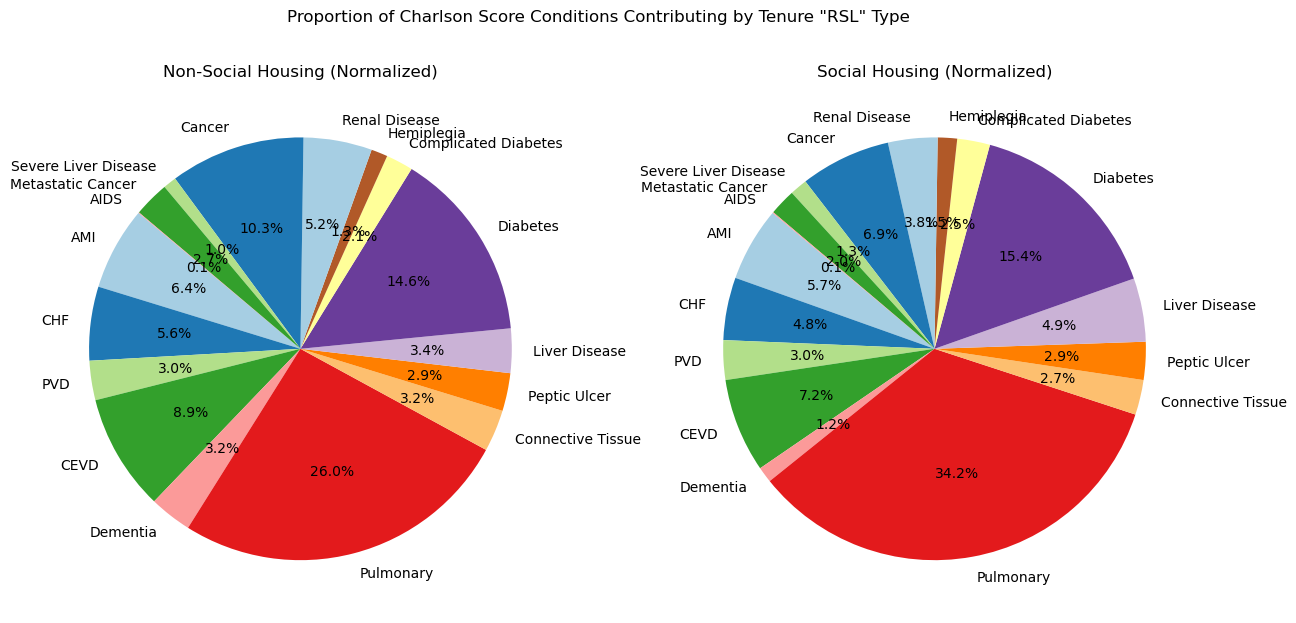

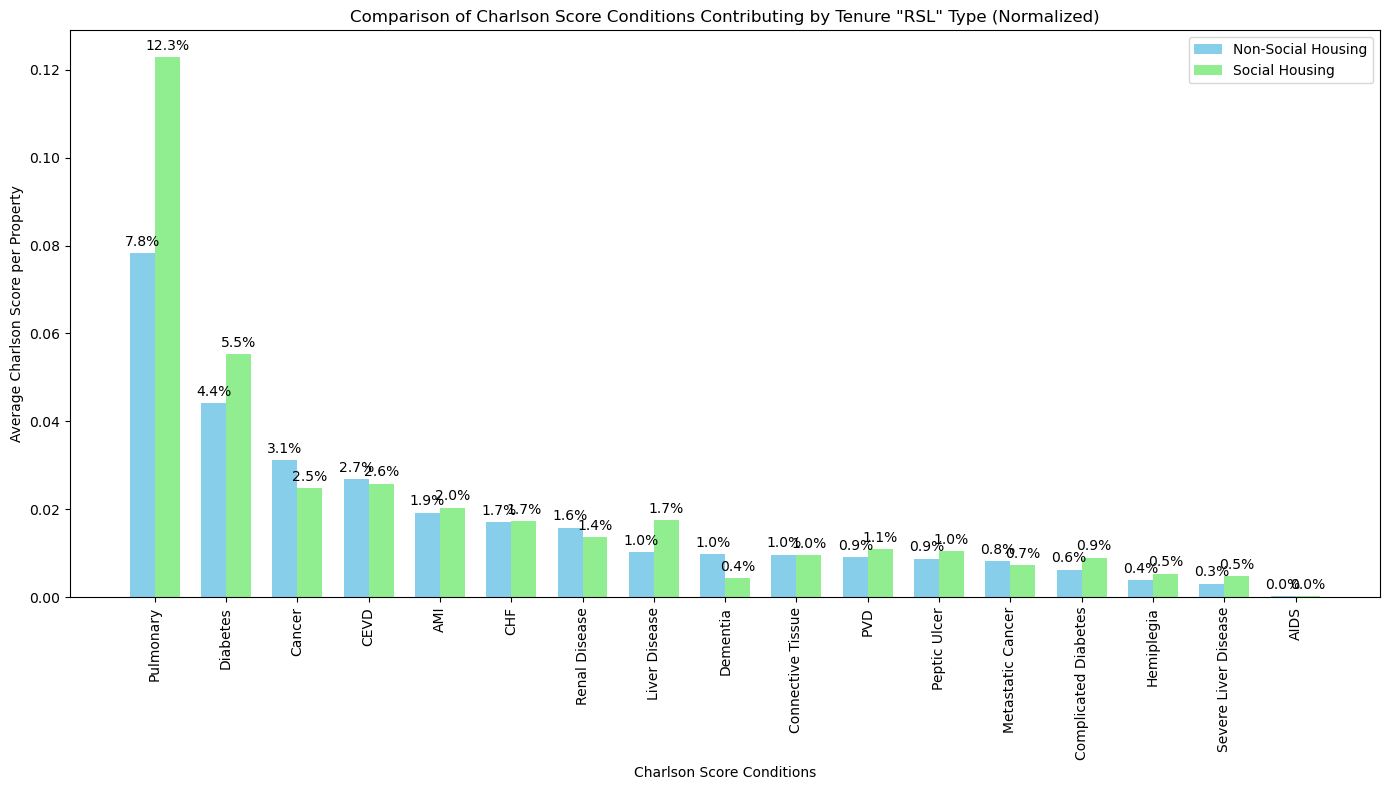

In [36]:
# List of Charlson Score columns
Charlson_Score = [
    'Charl_ami_sc', 'Charl_chf_sc', 'Charl_pvd_sc', 'Charl_cevd_sc', 'Charl_dementia_sc',
    'Charl_pulmonary_sc', 'Charl_Connective_Tissue_sc', 'Charl_Peptic_Ulcer_sc', 'Charl_liver_disease_sc',
    'Charl_diabetes_sc', 'Charl_Complications_Diabetes_sc', 'Charl_Hemiplegia_sc', 'Charl_renal_disease_sc',
    'Charl_cancer_sc', 'Charl_sever_liver_disease_sc', 'Charl_Metastatic_cancer_sc', 'Charl_aids_sc'
]

housingHealthnew[Charlson_Score] = housingHealthnew[Charlson_Score].fillna(0)

# Count the number of properties in each category (RSL = 0 and RSL = 1)
rsl_counts = housingHealthnew['RSL'].value_counts()
non_rsl_count = rsl_counts[0]
rsl_count = rsl_counts[1]

# Sum up admissions for each condition by RSL (social vs. non-social housing)
grouped_conditions = housingHealthnew.groupby('RSL')[Charlson_Score].sum().reset_index()

# Normalize the Charlson scores by the number of properties in each category
grouped_conditions_normalized = grouped_conditions.copy()
grouped_conditions_normalized.loc[grouped_conditions_normalized['RSL'] == 0, Charlson_Score] /= non_rsl_count
grouped_conditions_normalized.loc[grouped_conditions_normalized['RSL'] == 1, Charlson_Score] /= rsl_count

# Display the normalized grouped data for verification
print(grouped_conditions_normalized)

# Pie Charts
# Define labels for the pie chart based on Charlson Score conditions
condition_labels = [
    'AMI', 'CHF', 'PVD', 'CEVD', 'Dementia', 'Pulmonary', 'Connective Tissue', 'Peptic Ulcer',
    'Liver Disease', 'Diabetes', 'Complicated Diabetes', 'Hemiplegia', 'Renal Disease',
    'Cancer', 'Severe Liver Disease', 'Metastatic Cancer', 'AIDS'
]

# Pie chart for Non-Social Housing (RSL = 0)
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.pie(grouped_conditions_normalized.loc[grouped_conditions_normalized['RSL'] == 0, Charlson_Score].values[0],
        labels=condition_labels, autopct='%1.1f%%', startangle=140,
        colors=plt.cm.Paired.colors)
plt.title('Non-Social Housing (Normalized)')

# Pie chart for Social Housing (RSL = 1)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.pie(grouped_conditions_normalized.loc[grouped_conditions_normalized['RSL'] == 1, Charlson_Score].values[0],
        labels=condition_labels, autopct='%1.1f%%', startangle=140,
        colors=plt.cm.Paired.colors)
plt.title('Social Housing (Normalized)')

plt.suptitle('Proportion of Charlson Score Conditions Contributing by Tenure "RSL" Type')
plt.show()

#  Grouped Bar Charts
bar_width = 0.35
condition_positions = np.arange(len(Charlson_Score))


# Create a combined series to sort the conditions based on RSL = 0 and ensure alignment with RSL = 1
average_scores_non_social = grouped_conditions_normalized.loc[grouped_conditions_normalized['RSL'] == 0, Charlson_Score].values[0]
average_scores_social = grouped_conditions_normalized.loc[grouped_conditions_normalized['RSL'] == 1, Charlson_Score].values[0]

# Create a DataFrame for sorting purposes
sorted_df = pd.DataFrame({
    'Condition': Charlson_Score,
    'Non-Social': average_scores_non_social,
    'Social': average_scores_social
})

# Sort by 'Non-Social' or 'Social' column to order by descending average scores
sorted_df = sorted_df.sort_values(by='Non-Social', ascending=False)

# Extract sorted conditions
sorted_conditions = sorted_df['Condition'].tolist()
sorted_labels = [condition_labels[Charlson_Score.index(cond)] for cond in sorted_conditions]


# Step 2: Update the bar positions after sorting
condition_positions_sorted = np.arange(len(sorted_conditions))

# Step 3: Create grouped bar chart with sorted data
plt.figure(figsize=(14, 8))

# Bar chart for Non-Social Housing (RSL = 0)
bars_non_social = plt.bar(condition_positions_sorted, sorted_df['Non-Social'].values,
                          width=bar_width, color='skyblue', label='Non-Social Housing')

# Bar chart for Social Housing (RSL = 1)
bars_social = plt.bar(condition_positions_sorted + bar_width, sorted_df['Social'].values,
                      width=bar_width, color='lightgreen', label='Social Housing')


# Add labels and title
plt.xlabel('Charlson Score Conditions')
plt.ylabel('Average Charlson Score per Property')
plt.title('Comparison of Charlson Score Conditions Contributing by Tenure "RSL" Type (Normalized)')
plt.xticks(condition_positions + bar_width / 2, sorted_labels, rotation=90)
plt.legend()


# Adding percentage labels on top of the bars
for bar in bars_non_social:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f'{yval:.1%}', ha='center', va='bottom')

for bar in bars_social:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f'{yval:.1%}', ha='center', va='bottom')


plt.tight_layout()
plt.show()

**Comparative Insights:**

**Higher Respiratory Illness Burden in Social Housing:** The incidence of pulmonary disease was considerably higher in the social housing indicating that respiratory health is a more sensitive area for the clients. This may be because of dismal living standards or aspects of the surrounding environment such as pollution that affects lung health.

**Diabetes and Its Complications:** We found that diabetes prevalence is slightly higher in the social housing area, which may suggest difficulties of metabolic regulating in low-income population. Complicated diabetes which is also a closely related condition is discovered to be slightly more prevalent in social housing areas, thus either showing poor management or higher stages of the condition.

**Non-Social Housing and Age-Related Conditions:** The residents of the other households have higher ratios of cancer and dementia, which can be attributed to the old age of the families in this group and perhaps better health care services hence early diagnosis of the diseases.


This research seeks to find out the extent to which various health conditions defined by Charlson Comorbidity Index scores and other health characteristics impact on hospitalization. Through use of Total and Respiratory specific admission data, this report offers an insight of the cause of hospitalization with a special focus on residents of social housing as compared to non-social housing. The following outlines the research findings and the inference that can be made from them.


### Prevelance of Health Conditions

   RSL  _1_SolidOrganTransplant  _2_Cancer  _3_SevereRespiratory  \
0    0                 0.000687   0.007319              0.013480   
1    1                 0.000776   0.005291              0.023632   

   _4_SevereSingleOrganDisease  _6_ImmunosuppressionTherapy  \
0                     0.001998                     0.008559   
1                     0.002606                     0.007559   

   _7_PregnancyWithCongenitalHeartDisease  _8_GPIdentifiedPatients  \
0                                0.000036                 0.004410   
1                                0.000080                 0.004356   

   _9_Renal_Dialysis  _10_Other  _11_AdultsWithDownsSyndrome  _12_RenalCKD5  
0           0.000122   0.000556                     0.000346       0.000640  
1           0.000259   0.000557                     0.000378       0.000617  


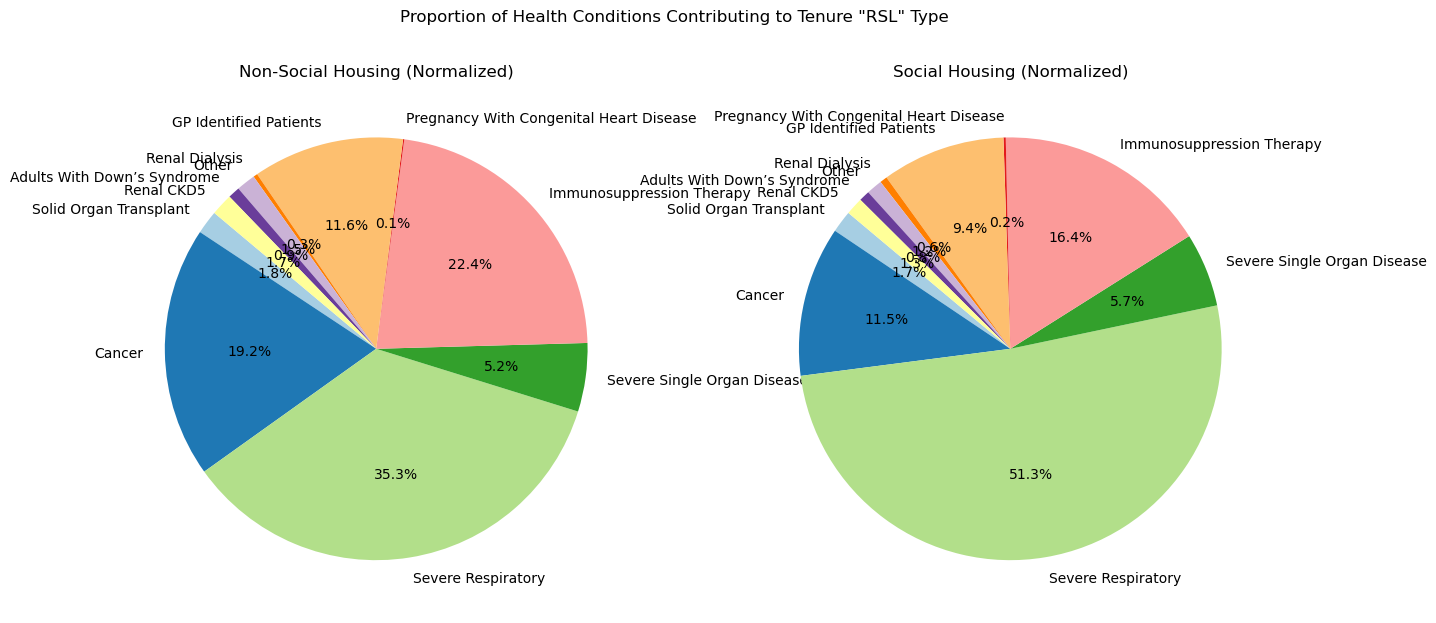

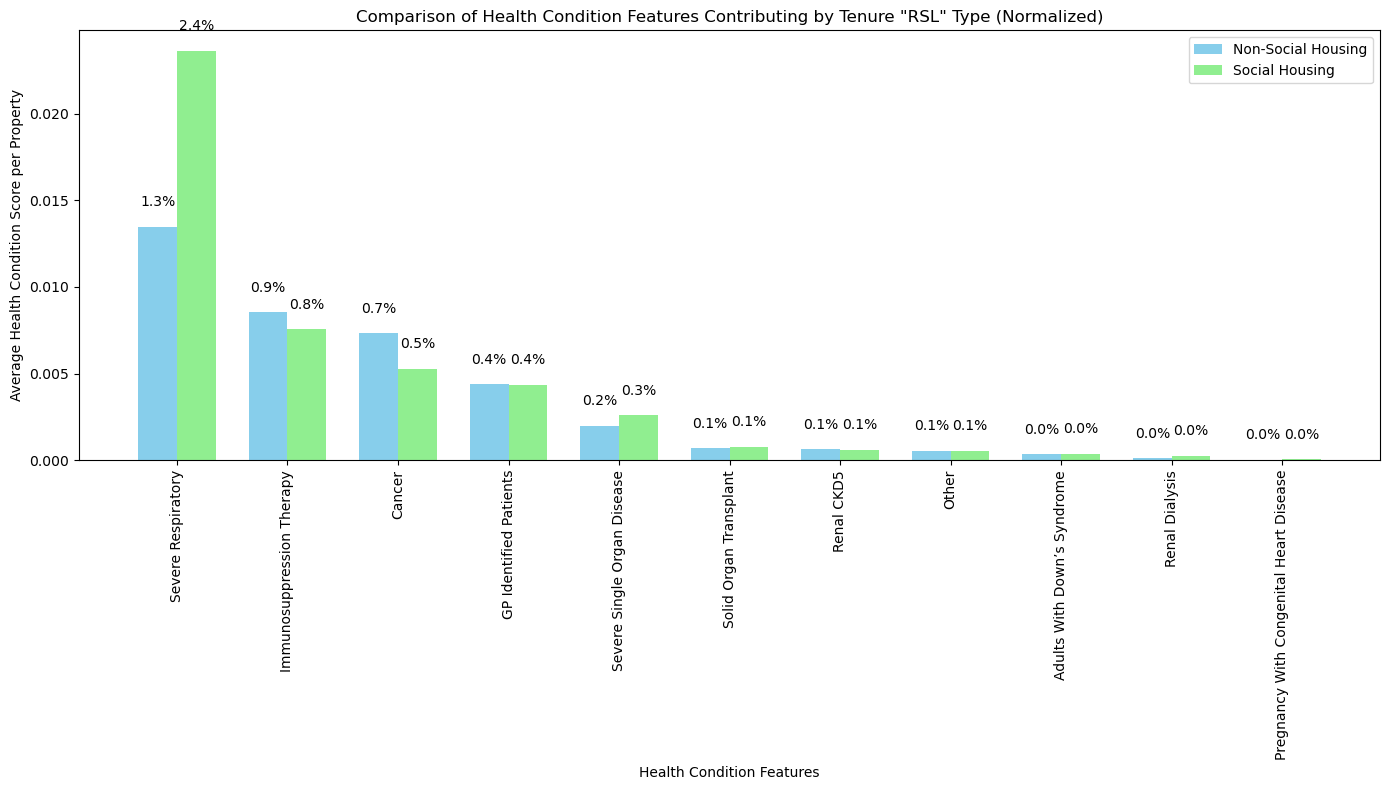

In [37]:
# List of Health Condition columns
health_condition_features = [
    '_1_SolidOrganTransplant', '_2_Cancer', '_3_SevereRespiratory', '_4_SevereSingleOrganDisease',
     '_6_ImmunosuppressionTherapy', '_7_PregnancyWithCongenitalHeartDisease',
    '_8_GPIdentifiedPatients', '_9_Renal_Dialysis', '_10_Other', '_11_AdultsWithDownsSyndrome', '_12_RenalCKD5'
]

housingHealthnew[health_condition_features] = housingHealthnew[health_condition_features].fillna(0)

# Count the number of properties in each category
rsl_counts = housingHealthnew['RSL'].value_counts()
non_rsl_count = rsl_counts[0]
rsl_count = rsl_counts[1]

# Sum up admissions for each health condition by RSL
grouped_conditions_health = housingHealthnew.groupby('RSL')[health_condition_features].sum().reset_index()

# Normalize the health condition scores by the number of properties in each category
grouped_conditions_health_normalized = grouped_conditions_health.copy()
grouped_conditions_health_normalized.loc[grouped_conditions_health_normalized['RSL'] == 0, health_condition_features] /= non_rsl_count
grouped_conditions_health_normalized.loc[grouped_conditions_health_normalized['RSL'] == 1, health_condition_features] /= rsl_count

# Display the normalized grouped data for verification
print(grouped_conditions_health_normalized)

# Pie Charts for Health Conditions
# Define labels for the pie chart based on Health Condition features
health_condition_labels = [
    'Solid Organ Transplant', 'Cancer', 'Severe Respiratory', 'Severe Single Organ Disease',
     'Immunosuppression Therapy', 'Pregnancy With Congenital Heart Disease',
    'GP Identified Patients', 'Renal Dialysis', 'Other', 'Adults With Down’s Syndrome', 'Renal CKD5'
]

# Pie chart for Non-Social Housing (RSL = 0)
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.pie(grouped_conditions_health_normalized.loc[grouped_conditions_health_normalized['RSL'] == 0, health_condition_features].values[0],
        labels=health_condition_labels, autopct='%1.1f%%', startangle=140,
        colors=plt.cm.Paired.colors)
plt.title('Non-Social Housing (Normalized)')

# Pie chart for Social Housing (RSL = 1)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.pie(grouped_conditions_health_normalized.loc[grouped_conditions_health_normalized['RSL'] == 1, health_condition_features].values[0],
        labels=health_condition_labels, autopct='%1.1f%%', startangle=140,
        colors=plt.cm.Paired.colors)
plt.title('Social Housing (Normalized)')

plt.suptitle('Proportion of Health Conditions Contributing to Tenure "RSL" Type')
plt.show()

#  Grouped Bar Charts for Health Conditions
bar_width = 0.35
condition_positions = np.arange(len(health_condition_features))

# Create a combined series to sort the conditions based on RSL = 0 and ensure alignment with RSL = 1
average_scores_non_social_health = grouped_conditions_health_normalized.loc[grouped_conditions_health_normalized['RSL'] == 0, health_condition_features].values[0]
average_scores_social_health = grouped_conditions_health_normalized.loc[grouped_conditions_health_normalized['RSL'] == 1, health_condition_features].values[0]

# Create a DataFrame for sorting purposes
sorted_health_df = pd.DataFrame({
    'Condition': health_condition_features,
    'Non-Social': average_scores_non_social_health,
    'Social': average_scores_social_health
})

# Sort by 'Non-Social' or 'Social' column to order by descending average scores
sorted_health_df = sorted_health_df.sort_values(by='Non-Social', ascending=False)

# Extract sorted conditions
sorted_health_conditions = sorted_health_df['Condition'].tolist()
sorted_health_labels = [health_condition_labels[health_condition_features.index(cond)] for cond in sorted_health_conditions]

# Update the bar positions after sorting
condition_positions_sorted = np.arange(len(sorted_health_conditions))

# Create grouped bar chart with sorted data
plt.figure(figsize=(14, 8))

# Bar chart for Non-Social Housing (RSL = 0)
bars_non_social = plt.bar(condition_positions_sorted, sorted_health_df['Non-Social'].values,
                          width=bar_width, color='skyblue', label='Non-Social Housing')

# Bar chart for Social Housing (RSL = 1)
bars_social = plt.bar(condition_positions_sorted + bar_width, sorted_health_df['Social'].values,
                      width=bar_width, color='lightgreen', label='Social Housing')

# Add labels and title
plt.xlabel('Health Condition Features')
plt.ylabel('Average Health Condition Score per Property')
plt.title('Comparison of Health Condition Features Contributing by Tenure "RSL" Type (Normalized)')
plt.xticks(condition_positions_sorted + bar_width / 2, sorted_health_labels, rotation=90)
plt.legend()

# Adding percentage labels on top of the bars
for bar in bars_non_social:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f'{yval:.1%}', ha='center', va='bottom')

for bar in bars_social:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f'{yval:.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Analyzing higher prevelance by Regression Model at a target variable 'total_admits'

In [38]:
# Checking for NaN values
nan_counts = housingHealthnew[Charlson_Score + ['total_admits']].isna().sum()
print("NaN values in each column:")
print(nan_counts)

# Checking for infinite values
inf_counts = housingHealthnew[Charlson_Score + ['total_admits']].apply(lambda x: np.isinf(x).sum())
print("\nInfinite values in each column:")
print(inf_counts)

NaN values in each column:
Charl_ami_sc                       0
Charl_chf_sc                       0
Charl_pvd_sc                       0
Charl_cevd_sc                      0
Charl_dementia_sc                  0
Charl_pulmonary_sc                 0
Charl_Connective_Tissue_sc         0
Charl_Peptic_Ulcer_sc              0
Charl_liver_disease_sc             0
Charl_diabetes_sc                  0
Charl_Complications_Diabetes_sc    0
Charl_Hemiplegia_sc                0
Charl_renal_disease_sc             0
Charl_cancer_sc                    0
Charl_sever_liver_disease_sc       0
Charl_Metastatic_cancer_sc         0
Charl_aids_sc                      0
total_admits                       0
dtype: int64

Infinite values in each column:
Charl_ami_sc                       0
Charl_chf_sc                       0
Charl_pvd_sc                       0
Charl_cevd_sc                      0
Charl_dementia_sc                  0
Charl_pulmonary_sc                 0
Charl_Connective_Tissue_sc         0
Ch

In [39]:


# Replace all NaN values with 0 in the dataset
housingHealthnew_filled = housingHealthnew[Charlson_Score].fillna(0)


# Define the target variable (admission-related) and predictors (Charlson scores)
X = housingHealthnew_filled[Charlson_Score]
y = housingHealthnew['total_admits']  # using total_admits as the target

# Add a constant to the model for intercept
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_admits   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                 1.059e+04
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        05:46:33   Log-Likelihood:            -1.0129e+06
No. Observations:              492708   AIC:                         2.026e+06
Df Residuals:                  492690   BIC:                         2.026e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

**Regression Analysis of Charlson Comorbidity Scores on Total Admissions**


The first Ordinary Least Squares (OLS) regression model applied the Charlson Comorbidity Index scores as exogenous variables for the purpose of estimating total hospital admissions. The results highlighted that several Charlson Score conditions are strong predictors of total admissions

Despite these significant results, the R-squared value was 0.268, indicating that the Charlson Comorbidity Scores could only account for 26.8% of the variation in the overall number of hospital admissions.  This relatively low R-squared number implies that there are factors other than these comorbidities which are important in increasing hospitalizations, including socioeconomic status, access to healthcare, and patient lifestyle choices.

Hospital admissions increased by 2.05 with every unit rise in CHF score, assuming all other factors remained constant, according to the significant coefficient of 2.05 for congestive heart failure (CHF). This suggests that one of the main causes of hospital admissions is CHF.

Due to the difficulties in controlling this chronic illness, dementia also shown a considerable influence with a coefficient of 1.85, indicating its crucial involvement in hospital admissions.

The greatest coefficient, 2.25, was found for severe liver disease, indicating a higher likelihood of hospitalization for these individuals. This can be because severe liver illnesses demand a lot of care.

Additional comorbidities, with coefficients ranging from 1.17 to 1.71, showed favorable and noteworthy impacts on hospital admissions. These included renal disease, pulmonary disease, and cerebrovascular disease (CEVD). These illnesses have a significant impact on the use of healthcare services, especially in older and more vulnerable populations.


In [40]:
health_condition_features = [
    '_1_SolidOrganTransplant', '_2_Cancer', '_3_SevereRespiratory', '_4_SevereSingleOrganDisease',
    '_5_RareDiseases', '_6_ImmunosuppressionTherapy', '_7_PregnancyWithCongenitalHeartDisease',
    '_8_GPIdentifiedPatients', '_9_Renal_Dialysis', '_10_Other', '_11_AdultsWithDownsSyndrome', '_12_RenalCKD5'
]

In [41]:
# Replace all NaN values with 0 in the dataset
housingHealthnew_filled2 = housingHealthnew[health_condition_features].fillna(0)


# Define the target variable (admission-related) and predictors (health conditions)
X = housingHealthnew_filled2[health_condition_features]
y = housingHealthnew['total_admits']  # using total_admits as the target

# Add a constant to the model for intercept
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_admits   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     1388.
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        05:46:47   Log-Likelihood:            -1.0821e+06
No. Observations:              492708   AIC:                         2.164e+06
Df Residuals:                  492696   BIC:                         2.164e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

**Health Conditions Regression Analysis and Total Admissions**

A further regression analysis was carried out using Ordinary Least Squares (OLS) regression model where the total number of hospital admissions was predicted by the health condition factors including cancer, respiratory disease, renal disease among others. The findings revealed that several health conditions were strong predictors of admissions:

•	Severe Single Organ Disease: Patients with severe damage to a single organ are more likely to be admitted to the hospital, according to the significant coefficient of 2.47 for severe single organ disease. This emphasizes the severity of organ failure as a cause of admissions.

•	Renal dialysis: Requires patients to receive intense and continuous treatment, was another extremely significant predictor, with a coefficient of 2.90.

•	Pregnancy With Congenital Heart Disease: The pregnancy with congenital heart disease had the highest coefficient, 4.0729, which suggests that it has a significant influence on admissions.

•	Severe Respiratory Conditions (coef: 1.10) and Cancer (coef: 1.71): Strong positive correlations were also found between hospital admissions and cancer (coef: 1.71) and severe respiratory conditions (coef: 1.10). The requirement for frequent and occasionally emergency hospital care is common among patients with severe respiratory disorders and cancer, which raises admission rates.


Nevertheless, the R-squared value was just 0.030, indicating that these particular medical disorders only accounted for 3% of the variability in total admissions, which is comparable to the Charlson Comorbidity model. This low R-squared value indicates that although there are factors in the given model, there could be other conditions, lifestyles, environmental factors, healthcare access, etc., that are leading towards hospital admissions

In [42]:
respiratory_condition_features = ['_3_SevereRespiratory', 'Charl_pulmonary_sc']


# Replace all NaN values with 0 in the dataset
housingHealthnew_filled3 = housingHealthnew[respiratory_condition_features].fillna(0)


# Define the target variable (admission-related) and predictors (respiratory conditions)
X = housingHealthnew_filled3[respiratory_condition_features]
y = housingHealthnew['resp_admits']  # using resp_admits as the target

# Add a constant to the model for intercept
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            resp_admits   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                 1.330e+04
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        05:47:00   Log-Likelihood:            -4.2805e+05
No. Observations:              492708   AIC:                         8.561e+05
Df Residuals:                  492705   BIC:                         8.561e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0521 

**Respiratory Conditions and Respiratory-Specific Admissions**

Ordinary Least Squares (OLS) regression model was used which was aimed at respiratory illnesses and their effects on respiratory-related hospitalization. Other independent variables in the model were Severe Respiratory Conditions and the Charlson Pulmonary Score.

•	Severe Respiratory Conditions (coef: 0.5535) was further supported by the analysis which revealed that Severity of respiratory condition makes a significantly positive contribution to respiratory admission implying that, the higher the severity of respiratory conditions, then the higher the probability of having respiratory admissions. Thus, the current study reinforces the significance of addressing severe respiratory conditions in the goal to decrease hospitalization.

•	The Charlson Pulmonary Score (coef: 0.3584) had a significant positive impact on respiratory admission. This explains the total effect of comorbid respiratory diseases on the hospitalization rates since patients with chronic respiratory diseases are more at risk of needing hospital services.


Even with these predictors' substantial significance, the model only predicts 5.1% of the variability in respiratory admissions, as indicated by the R-squared value of 0.051. This means that other numerous factors for example polluted air, smoking regime, and quality of early preventive health care could also affect respiratory and subsequent admissions and should therefore be explored in subsequent techniques.

**Summary of OLS Regression Results for Respiratory Admissions**

The primary independent variable of the OLS regression model is the severe respiratory conditions while the Charlson Pulmonary Score is the independent variable used in predicting the dependent variable ‘resp_admits’. This means that although these two variables have strong effects on respiratory admissions, they only account for a small proportion of the variability in the data (R-squared = 0. 051). This mean that there are other elements that have influence over this decision, which can be socio-economic or even environmental.

Strong predictors include the Charlson Pulmonary Score (coef: 0.3584) and Severe Respiratory Conditions (coef: 0.5535), with the former having a greater effect on admissions. Hypothesis tests for the F-statistic along with low p-values provide a further proof of the validity of the above identified predictors which suggest that the said variables do bear significant impact on the result.

Nevertheless, the low R-squared value indicates that additional research is necessary because the model only accounts for 5.1% of the variability in respiratory admissions. Further some residual distribution of results is non-normal, such as having skewness and kurtosis thus, indicating that the model might require further testing and tweaking with other additional predictive variables, or by exploring nonlinear models to enhance predictive capabilities of the model.


### Analyzing the prevalence by AGE 

In [43]:
housingHealthnew['age_in_years'].unique()

array(['50-59', '70-79', '60-69', '10-19', '30-39', '0-9', '20-29',
       '40-49', '80-89', '90+'], dtype=object)

C:\Users\E-TIME\AppData\Local\Temp\ipykernel_2544\1699767169.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence_by_age = housingHealthnew.groupby('age_in_years')[health_conditions_new].mean().reset_index()
C:\Users\E-TIME\AppData\Roaming\Python\Python310\site-packages\pandas\plotting\_matplotlib\core.py:891: UserWarning: The label '_1_SolidOrganTransplant' of <BarContainer object of 10 artists> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)
C:\Users\E-TIME\AppData\Roaming\Python\Python310\site-packages\pandas\plotting\_matplotlib\core.py:891: UserWarning: The label '_2_Cancer' of <BarContainer object of 10 artists> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)
C:\

<Figure size 1200x800 with 0 Axes>

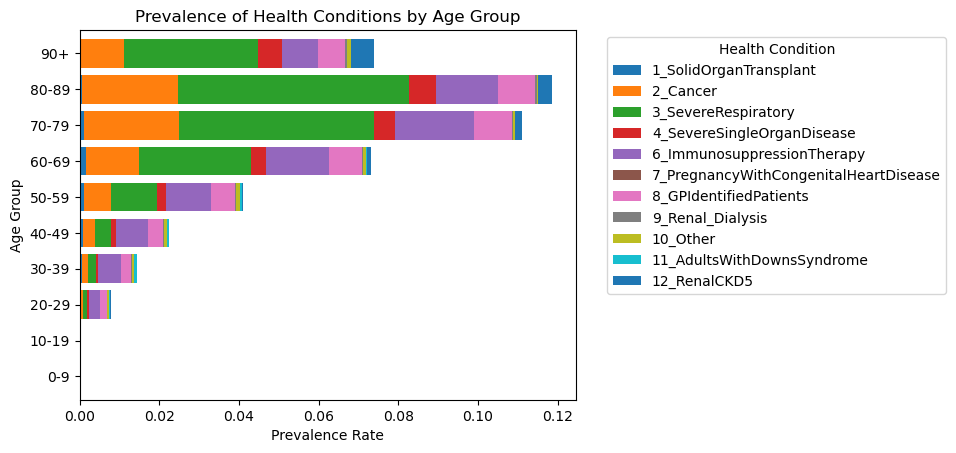

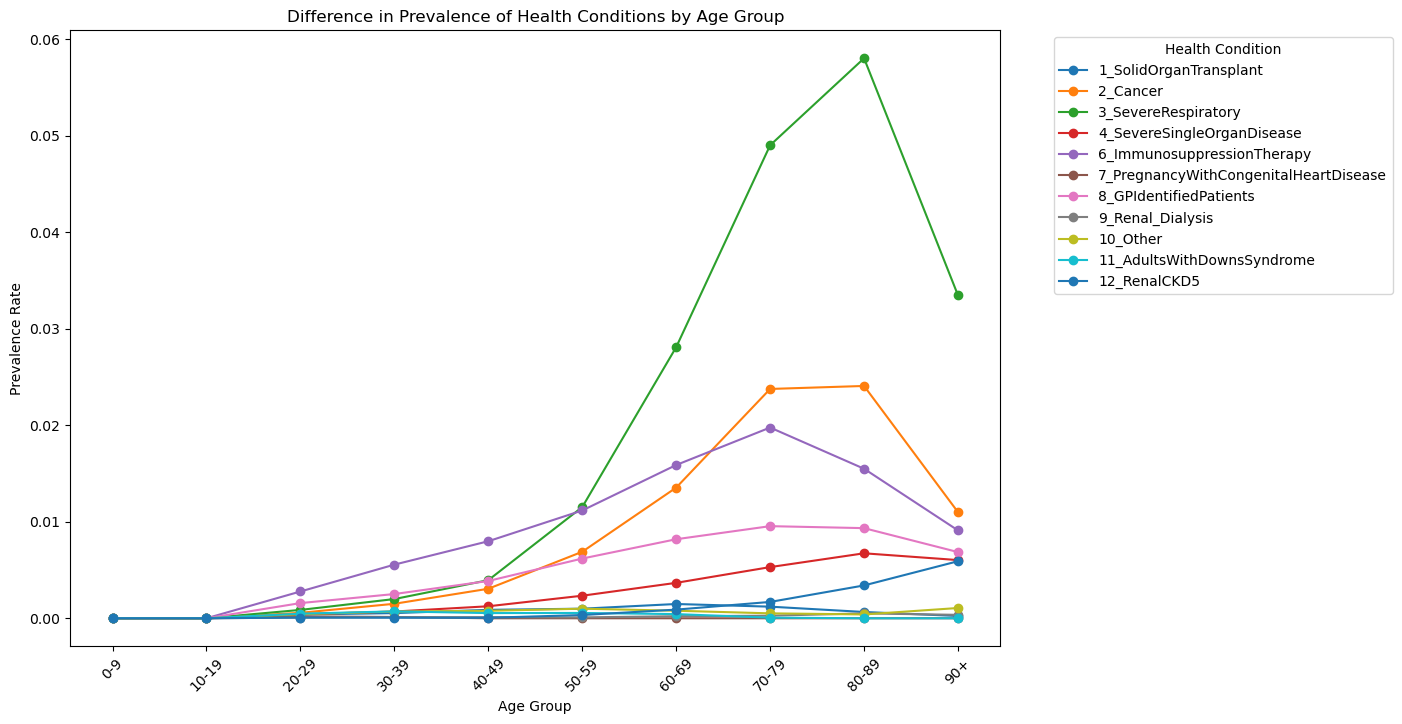

In [44]:
health_conditions_new = [
    '_1_SolidOrganTransplant', '_2_Cancer', '_3_SevereRespiratory', '_4_SevereSingleOrganDisease',
     '_6_ImmunosuppressionTherapy', '_7_PregnancyWithCongenitalHeartDisease',
    '_8_GPIdentifiedPatients', '_9_Renal_Dialysis', '_10_Other', '_11_AdultsWithDownsSyndrome', '_12_RenalCKD5'
]

housingHealthnew[health_conditions_new] = housingHealthnew[health_conditions_new].fillna(0)

# Ensure the age groups are ordered correctly
age_order = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
housingHealthnew['age_in_years'] = pd.Categorical(housingHealthnew['age_in_years'], categories=age_order, ordered=True)

# Calculate prevalence by age group
prevalence_by_age = housingHealthnew.groupby('age_in_years')[health_conditions_new].mean().reset_index()


# Plot prevalence by age group using a horizontal bar chart
plt.figure(figsize=(12, 8))
prevalence_by_age.set_index('age_in_years').plot(kind='barh', stacked=True, width=0.8)
plt.title('Prevalence of Health Conditions by Age Group')
plt.xlabel('Prevalence Rate')
plt.ylabel('Age Group')
plt.legend(title='Health Condition', bbox_to_anchor=(1.05, 1), loc='upper left', labels=[label[1:] for label in health_conditions_new])

plt.show()

# Plot difference in prevalence between age groups using a dot plot
plt.figure(figsize=(12, 8))
for condition in health_conditions_new:
    plt.plot(prevalence_by_age['age_in_years'], prevalence_by_age[condition], marker='o', linestyle='-', label=[label[1:] for label in health_conditions_new])

plt.title('Difference in Prevalence of Health Conditions by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Prevalence Rate')
plt.xticks(rotation=45)
plt.legend(title='Health Condition', bbox_to_anchor=(1.05, 1), loc='upper left', labels=[label[1:] for label in health_conditions_new])
plt.show()

This research question aims at identifying the proportion of different diseases and Charlson Comorbidities by different age groups, gender, and property tenure types. The goal is to establish the trends present in the distribution of health conditions and the combinations of housing tenures over the years, to see whether there is a revelation of the trends in healthcare burden of different segments in the population.

**Age-Based Trends in Health Conditions and Comorbidities**

It is also clear from the results that rates of chronic health conditions increase with age. Pulmonary diseases, cancer, and cardiovascular diseases show a general increase in Charlson comorbidities for any age but especially as one grows older according to the stacked bar charts and the dot plots. From the results, it can be deduced that the ‘elderly’ 60-90+ have a much higher prevalence of chronic diseases than do the ‘younger’ populations.




C:\Users\E-TIME\AppData\Local\Temp\ipykernel_2544\3744254359.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence_by_age = housingHealthnew.groupby('age_in_years')[Charlson_Score_new].mean().reset_index()


<Figure size 1200x800 with 0 Axes>

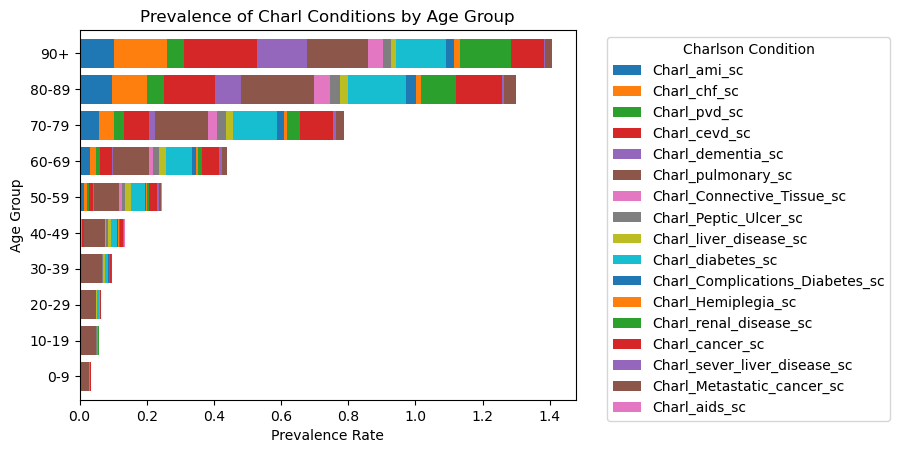

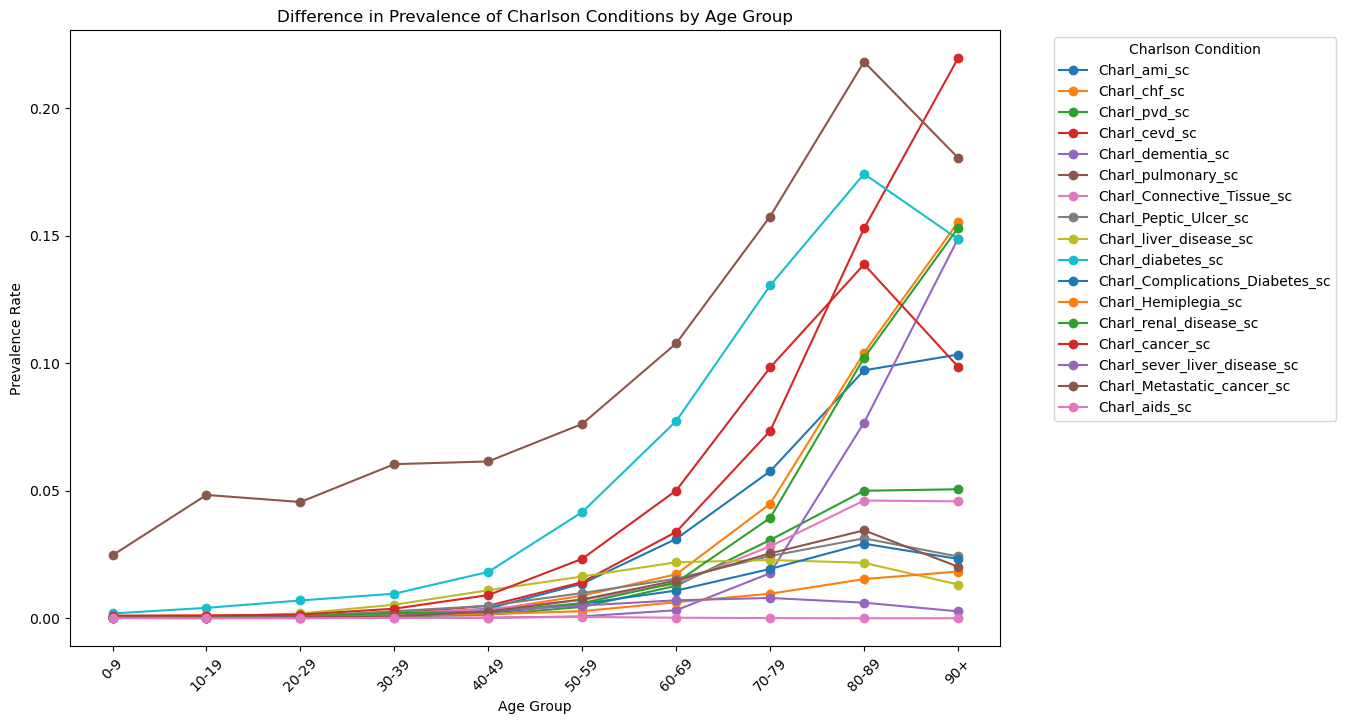

In [45]:
Charlson_Score_new = [
    'Charl_ami_sc', 'Charl_chf_sc', 'Charl_pvd_sc', 'Charl_cevd_sc', 'Charl_dementia_sc',
    'Charl_pulmonary_sc', 'Charl_Connective_Tissue_sc', 'Charl_Peptic_Ulcer_sc', 'Charl_liver_disease_sc',
    'Charl_diabetes_sc', 'Charl_Complications_Diabetes_sc', 'Charl_Hemiplegia_sc', 'Charl_renal_disease_sc',
    'Charl_cancer_sc', 'Charl_sever_liver_disease_sc', 'Charl_Metastatic_cancer_sc', 'Charl_aids_sc'
]

housingHealthnew[Charlson_Score_new] = housingHealthnew[Charlson_Score_new].fillna(0)

# Ensure the age groups are ordered correctly
age_order = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
housingHealthnew['age_in_years'] = pd.Categorical(housingHealthnew['age_in_years'], categories=age_order, ordered=True)

# Calculate prevalence by age group
prevalence_by_age = housingHealthnew.groupby('age_in_years')[Charlson_Score_new].mean().reset_index()


# Plot prevalence by age group using a horizontal bar chart
plt.figure(figsize=(12, 8))
prevalence_by_age.set_index('age_in_years').plot(kind='barh', stacked=True, width=0.8)
plt.title('Prevalence of Charl Conditions by Age Group')
plt.xlabel('Prevalence Rate')
plt.ylabel('Age Group')
plt.legend(title='Charlson Condition', bbox_to_anchor=(1.05, 1), loc='upper left', labels=[label[:] for label in Charlson_Score_new])

plt.show()

# Plot difference in prevalence between age groups using a dot plot
plt.figure(figsize=(12, 8))
for condition in Charlson_Score_new:
    plt.plot(prevalence_by_age['age_in_years'], prevalence_by_age[condition], marker='o', linestyle='-', label=[label[:] for label in Charlson_Score_new])

plt.title('Difference in Prevalence of Charlson Conditions by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Prevalence Rate')
plt.xticks(rotation=45)
plt.legend(title='Charlson Condition', bbox_to_anchor=(1.05, 1), loc='upper left', labels=[label[:] for label in Charlson_Score_new])
plt.show()

Considering the prevalence of diseases amongst elderly people, pulmonary diseases, diabetes, and cancer remain the most frequent. For instance, in specific regions of the world pulmonary diseases take a considerable proportion of the overall health cost in the 60-90+ population. In the same manner, cancer (and more-so metastatic cancer) prevalence increases from 60+ age group and has the highest prevalence in the 80-89 age group which reduces slightly in the 90+age groups. These findings thus indicate that there is need for continued focus on the management of chronic diseases, and more specifically among the aging populations, with a strong focus on respiratory and cancer related illnesses.

**Gender-Based Trends in Health Conditions**

A gender analysis depicts some of the heath conditions’ disparities between male and female. In general, cross-analysis indicates that females consistently present a higher incidence of chronic diseases than males. In comparison to men, women have a greater frequency of pulmonary disorders (9.40% vs. 7.19%) and diabetes (4.15% vs. 2.64%). Conversely, men are more likely than women to suffer from cardiovascular diseases such heart disease and cancer (3.17% vs. 2.94%).


In [46]:
housingHealthnew['popn_Sex'].unique()

array(['M', 'F', 'Unknown', 'U'], dtype=object)

In [47]:
popn_sex_counts = housingHealthnew['popn_Sex'].value_counts()
print(popn_sex_counts)

popn_Sex
M          246163
F          245588
Unknown       901
U              56
Name: count, dtype: int64


C:\Users\E-TIME\AppData\Roaming\Python\Python310\site-packages\pandas\plotting\_matplotlib\core.py:891: UserWarning: The label '_1_SolidOrganTransplant' of <BarContainer object of 2 artists> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)
C:\Users\E-TIME\AppData\Roaming\Python\Python310\site-packages\pandas\plotting\_matplotlib\core.py:891: UserWarning: The label '_2_Cancer' of <BarContainer object of 2 artists> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)
C:\Users\E-TIME\AppData\Roaming\Python\Python310\site-packages\pandas\plotting\_matplotlib\core.py:891: UserWarning: The label '_3_SevereRespiratory' of <BarContainer object of 2 artists> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)
C:\Users\E-TIME\AppData\Roaming\Python\Python310\site-packages\pandas\plotting\_matplotlib\core.py:891: UserWarning: The

<Figure size 1000x800 with 0 Axes>

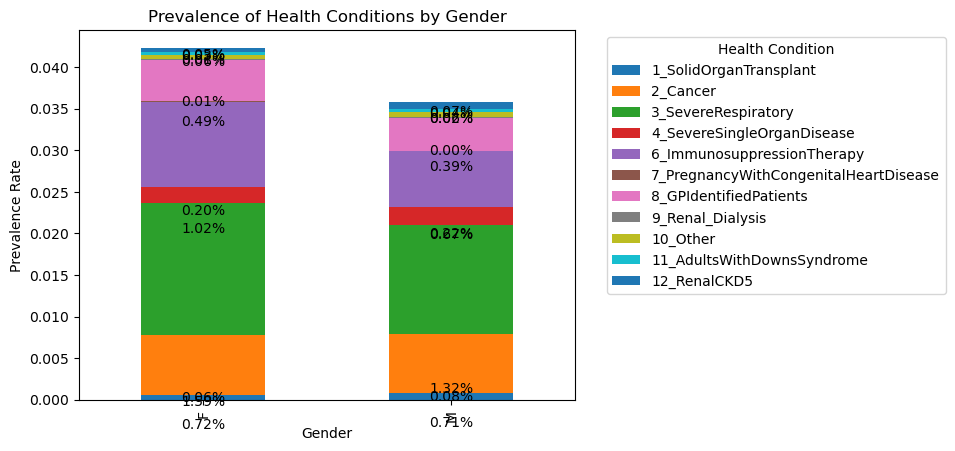

In [52]:
health_conditions_new = [
    '_1_SolidOrganTransplant', '_2_Cancer', '_3_SevereRespiratory', '_4_SevereSingleOrganDisease',
     '_6_ImmunosuppressionTherapy', '_7_PregnancyWithCongenitalHeartDisease',
    '_8_GPIdentifiedPatients', '_9_Renal_Dialysis', '_10_Other', '_11_AdultsWithDownsSyndrome', '_12_RenalCKD5'
]

filtered_data = housingHealthnew[housingHealthnew['popn_Sex'].isin(['F', 'M'])]

# Calculate prevalence by gender
prevalence_by_gender = filtered_data.groupby('popn_Sex')[health_conditions_new].mean().reset_index()

#print(prevalence_by_gender)
# Plot prevalence by gender
plt.figure(figsize=(10, 8))
prevalence_by_gender.set_index('popn_Sex').plot(kind='bar', stacked=True)
plt.title('Prevalence of Health Conditions by Gender')
plt.xlabel('Gender')
plt.ylabel('Prevalence Rate')
plt.legend(title='Health Condition', bbox_to_anchor=(1.05, 1), loc='upper left', labels=[label[1:] for label in health_conditions_new])


# Annotate each bar with the prevalence rate
for i in range(prevalence_by_gender.shape[0]):
    for j, col in enumerate(prevalence_by_gender.columns[1:]):
        # Get the cumulative height up to the current bar segment
        cumulative_height = prevalence_by_gender.iloc[i, 1:j+1].sum()
        # Calculate the mid-point for the text
        if j == 0:
            plt.text(i, prevalence_by_gender.iloc[i, j+1] / 2, f'{prevalence_by_gender.iloc[i, j+1]:.2%}', ha='center', va='center')
        else:
            plt.text(i, cumulative_height - prevalence_by_gender.iloc[i, j+1] / 2, f'{prevalence_by_gender.iloc[i, j+1]:.2%}', ha='center', va='center')


plt.show()

C:\Users\E-TIME\AppData\Roaming\Python\Python310\site-packages\pandas\plotting\_matplotlib\core.py:891: UserWarning: The label '_3_SevereRespiratory' of <BarContainer object of 2 artists> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)
C:\Users\E-TIME\AppData\Roaming\Python\Python310\site-packages\pandas\plotting\_matplotlib\core.py:891: UserWarning: The label '_6_ImmunosuppressionTherapy' of <BarContainer object of 2 artists> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)
C:\Users\E-TIME\AppData\Roaming\Python\Python310\site-packages\pandas\plotting\_matplotlib\core.py:891: UserWarning: The label '_2_Cancer' of <BarContainer object of 2 artists> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)
C:\Users\E-TIME\AppData\Roaming\Python\Python310\site-packages\pandas\plotting\_matplotlib\core.py:891: UserWarning:

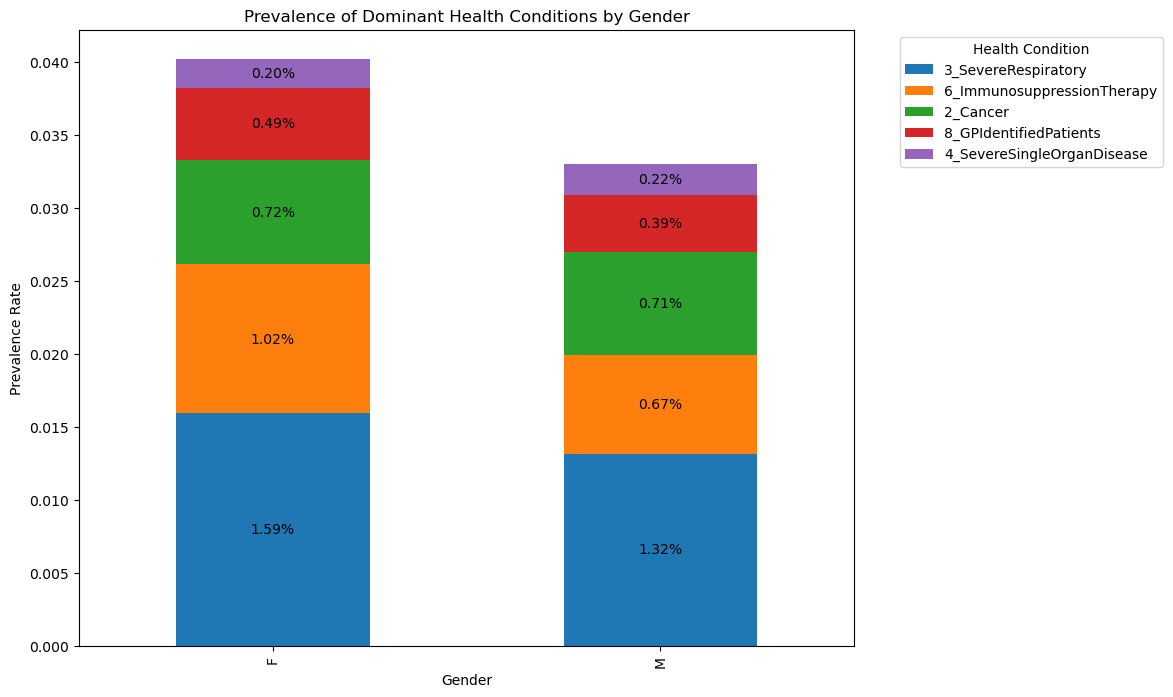

In [53]:
# Calculate total prevalence for each condition across genders
total_prevalence = prevalence_by_gender[health_conditions_new].sum()

# Select top 5 dominant conditions based on total prevalence
dominant_conditions = total_prevalence.nlargest(5).index.tolist()

# Filter the prevalence_by_gender DataFrame to include only dominant conditions
dominant_prevalence_by_gender = prevalence_by_gender[['popn_Sex'] + dominant_conditions]

dominant_prevalence_by_gender = dominant_prevalence_by_gender.fillna(0)

# Plot prevalence by gender for dominant conditions
fig, ax = plt.subplots(figsize=(10, 8))
dominant_prevalence_by_gender.set_index('popn_Sex').plot(kind='bar', stacked=True, ax=ax)
plt.title('Prevalence of Dominant Health Conditions by Gender')
plt.xlabel('Gender')
plt.ylabel('Prevalence Rate')
plt.legend(title='Health Condition', bbox_to_anchor=(1.05, 1), loc='upper left', labels=[label[1:] for label in dominant_conditions])

# Annotate each bar with the prevalence rate for dominant conditions
for container in ax.containers:
    # Adding labels to each bar segment
    labels = [f'{v.get_height():.2%}' if v.get_height() > 0 else '' for v in container]
    ax.bar_label(container, labels=labels, label_type='center')

plt.show()

<Figure size 1000x800 with 0 Axes>

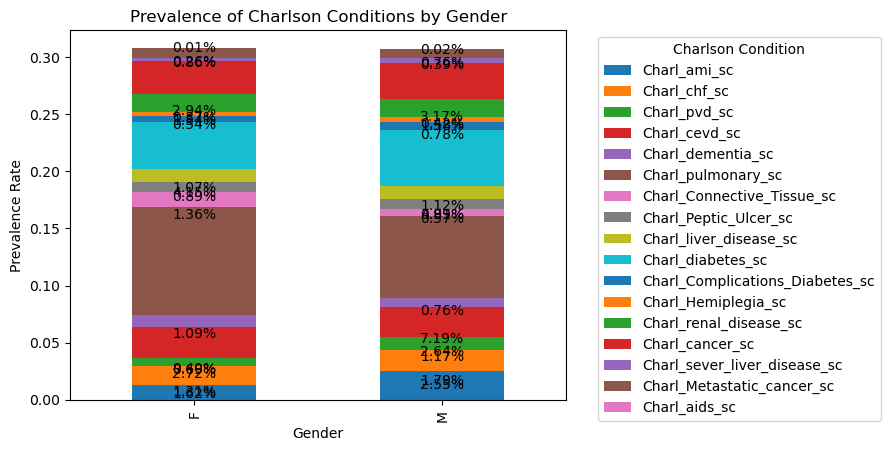

In [54]:
filtered_data = housingHealthnew[housingHealthnew['popn_Sex'].isin(['F', 'M'])]

prevalence_by_gender = filtered_data.groupby('popn_Sex')[Charlson_Score_new].mean().reset_index()

plt.figure(figsize=(10, 8))
prevalence_by_gender.set_index('popn_Sex').plot(kind='bar', stacked=True)
plt.title('Prevalence of Charlson Conditions by Gender')
plt.xlabel('Gender')
plt.ylabel('Prevalence Rate')
plt.legend(title='Charlson Condition', bbox_to_anchor=(1.05, 1), loc='upper left', labels=[label[:] for label in Charlson_Score_new])


for i in range(prevalence_by_gender.shape[0]):
    for j, col in enumerate(prevalence_by_gender.columns[1:]):
        # Get the cumulative height up to the current bar segment
        cumulative_height = prevalence_by_gender.iloc[i, 1:j+1].sum()
        # Calculate the mid-point for the text
        if j == 0:
            plt.text(i, prevalence_by_gender.iloc[i, j+1] / 2, f'{prevalence_by_gender.iloc[i, j+1]:.2%}', ha='center', va='center')
        else:
            plt.text(i, cumulative_height - prevalence_by_gender.iloc[i, j+1] / 2, f'{prevalence_by_gender.iloc[i, j+1]:.2%}', ha='center', va='center')


plt.show()

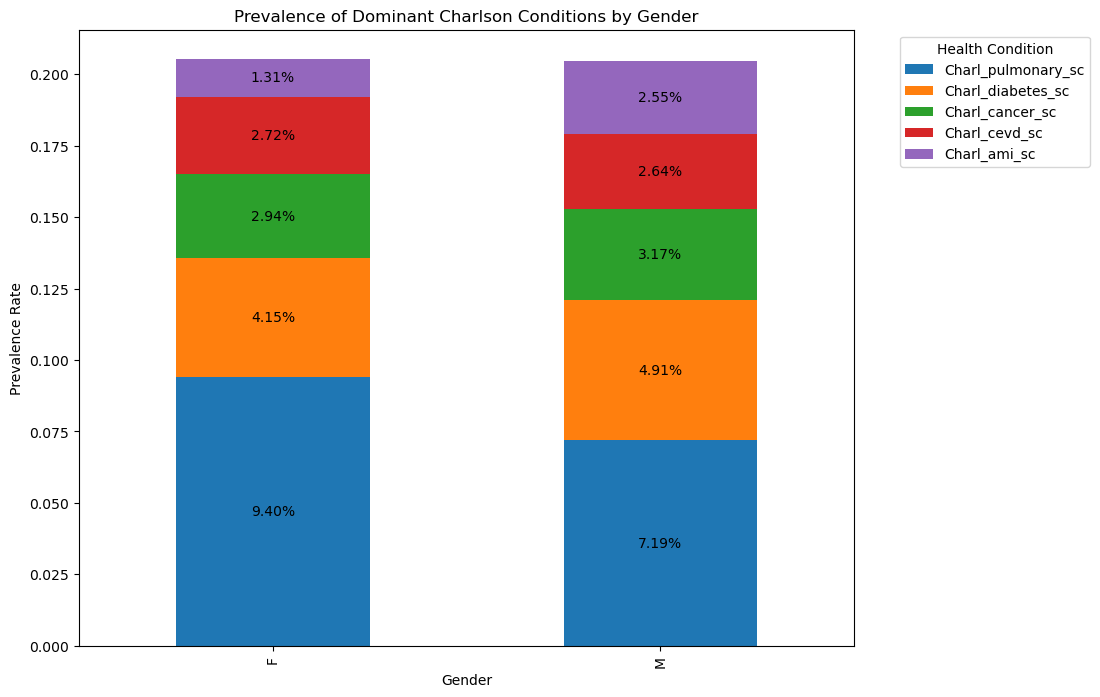

In [55]:
# Calculate total prevalence for each condition across genders
total_prevalence = prevalence_by_gender[Charlson_Score_new].sum()

# Select top 5 dominant conditions based on total prevalence
dominant_conditions = total_prevalence.nlargest(5).index.tolist()

# Filter the prevalence_by_gender DataFrame to include only dominant conditions
dominant_prevalence_by_gender = prevalence_by_gender[['popn_Sex'] + dominant_conditions]

dominant_prevalence_by_gender = dominant_prevalence_by_gender.fillna(0)

# Plot prevalence by gender for dominant conditions
fig, ax = plt.subplots(figsize=(10, 8))
dominant_prevalence_by_gender.set_index('popn_Sex').plot(kind='bar', stacked=True, ax=ax)
plt.title('Prevalence of Dominant Charlson Conditions by Gender')
plt.xlabel('Gender')
plt.ylabel('Prevalence Rate')
plt.legend(title='Health Condition', bbox_to_anchor=(1.05, 1), loc='upper left', labels=[label[:] for label in dominant_conditions])

# Annotate each bar with the prevalence rate for dominant conditions
for container in ax.containers:
    # Adding labels to each bar segment
    labels = [f'{v.get_height():.2%}' if v.get_height() > 0 else '' for v in container]
    ax.bar_label(container, labels=labels, label_type='center')

plt.show()

The impact of severe respiratory diseases appears also almost equal by gender, so respiratory diseases are an issue of major concern for both men and women. It is therefore the implication that, healthcare approaches should consider gender disparities in health risks where females are at higher risk to develop diabetes and pulmonary disease and on the other hand, males are at a higher risk to develop cancer.

#### Concatenating and finding the unique combinations of property types:

In [56]:
housingHealthnew['property_combination'] = housingHealthnew[['primary_desc', 'tenure']].astype(str).agg(': '.join, axis=1)

# Find unique combinations
unique_combinations = housingHealthnew['property_combination'].unique()

# Display unique combinations
print("Unique Combinations : ",unique_combinations)

# If you want to count the frequency of each unique combination
combination_counts = housingHealthnew['property_combination'].value_counts()
print("Length of Combination COunts : ",len(combination_counts))

Unique Combinations :  ['nan: nan' 'Residential: Rented (private)' 'Residential: rental (social)'
 'Residential: nan' 'Residential: owner-occupied' 'Residential: unknown'
 'Residential: Rented (social)' 'Residential: rental (private)'
 'Residential: Owner-occupied'
 'Residential: Not defined - use in the case of a new dwelling for which the intended tenure in not known. It is no'
 'Commercial: rental (private)' 'Residential: NO DATA!'
 'Commercial: Owner-occupied' 'Commercial: owner-occupied'
 'Commercial: NO DATA!' 'Parent Shell: owner-occupied'
 'Dual Use: Owner-occupied' 'Parent Shell: rental (private)'
 'Parent Shell: rental (social)' 'Parent Shell: Rented (private)'
 'Commercial: unknown' 'Land: unknown' 'Commercial: rental (social)'
 'Dual Use: owner-occupied'
 'Parent Shell: Not defined - use in the case of a new dwelling for which the intended tenure in not known. It is no'
 'Parent Shell: Owner-occupied'
 'Commercial: Not defined - use in the case of a new dwelling for which t

In [57]:
# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Print all combinations and their counts
print(combination_counts)

# Reset display option if you don't want to keep this setting
pd.reset_option('display.max_rows')

property_combination
nan: nan                                                                                                              200230
Residential: owner-occupied                                                                                           142528
Residential: rental (social)                                                                                           41003
Residential: rental (private)                                                                                          31987
Residential: Owner-occupied                                                                                            22322
Residential: unknown                                                                                                   20917
Residential: Rented (private)                                                                                          10769
Residential: Rented (social)                                                                            

In [58]:

mortality_col = ['year_of_death', 'RSL']
housingHealthnew[mortality_col] = housingHealthnew[mortality_col].fillna(0)




In [59]:
housingHealthnew['age_in_years'].isna().sum()

0

In [60]:
# convert age range to midpoint
def age_range_to_midpoint(age_range):
    # Extract start and end of the range
    if '-' in age_range:
        start, end = age_range.split('-')
        midpoint = math.ceil((int(start) + int(end)) / 2)
    elif age_range == '90+':
        # Assuming 95 as a midpoint for 90+
        midpoint = 95
    else:
        midpoint = np.nan
    return midpoint

# Apply the function to the age_in_years column
housingHealthnew['age_in_years_midpoint'] = housingHealthnew['age_in_years'].apply(age_range_to_midpoint)

# Convert the new column to numeric, just in case
housingHealthnew['age_in_years_midpoint'] = pd.to_numeric(housingHealthnew['age_in_years_midpoint'], errors='coerce')

# Check the new column
print(housingHealthnew[['age_in_years', 'age_in_years_midpoint']].head())

  age_in_years  age_in_years_midpoint
0        50-59                     55
1        70-79                     75
2        60-69                     65
3        70-79                     75
4        60-69                     65


In [61]:
housingHealthnew['year_of_death'] = pd.to_numeric(housingHealthnew['year_of_death'], errors='coerce')
housingHealthnew['RSL'] = housingHealthnew['RSL'].astype(int)

# Display the cleaned data
print(housingHealthnew[['year_of_death', 'age_in_years', 'age_in_years_midpoint','RSL' ]].head())

   year_of_death age_in_years  age_in_years_midpoint  RSL
0              0        50-59                     55    0
1              0        70-79                     75    0
2              0        60-69                     65    0
3              0        70-79                     75    0
4              0        60-69                     65    0


### Total death recorded in our dataset

In [62]:
housingHealthnew[housingHealthnew['year_of_death']!=0].shape[0]

18879

In [63]:
housingHealthnew['year_of_death'].unique()

array([   0, 2023, 2021, 2024, 2022, 2999, 2020, 2009, 2019, 2015, 1979,
       1996, 2001, 2012, 2016, 2006, 2017, 2004, 2000, 2002, 2018, 2003,
       1993, 2008, 1981, 1992, 1994, 1997, 1990, 1999], dtype=int64)

In [64]:
#total deaths which are unknown

housingHealthnew[housingHealthnew['year_of_death'] == 2999].shape[0]

901

In [65]:
#total deaths which are unknown

housingHealthnew[housingHealthnew['year_of_death'] == 2999]

unique_ID  year_of_death popn_JCVI popn_Sex PRS_CAre_Home_Resident  \
407        2473017           2999    cypris  Unknown                      N   
528       11873392           2999    cypris  Unknown                      N   
2433      13373348           2999    cypris  Unknown                      N   
2760      76373425           2999    cypris  Unknown                      N   
3341     103271541           2999    cypris  Unknown                      N   
...            ...            ...       ...      ...                    ...   
490769  8975273020           2999    cypris  Unknown                      N   
491169  9191673410           2999    cypris  Unknown                      N   
491431  9340173021           2999    cypris  Unknown                      N   
492429  9856372831           2999    cypris  Unknown                      N   
492598  9941073121           2999    cypris  Unknown                      N   

       PRS_OCC_unpaid_carer  _1_SolidOrganTransplant  _2_Cancer  \
407                       N                      0.0        0.0   
528                       N                      0.0        0.0   
2433                      N                      0.0        0.0   
2760                      N                      0.0        0.0   
3341                      N                      0.0        0.0   
...                     ...                      ...        ...   
490769                    N                      0.0        0.0   
491169                    N                      0.0        0.0   
491431                    N                      0.0        0.0   
492429                    N                      0.0        0.0   
492598                    N                      0.0        0.0   

        _3_SevereRespiratory  _4_SevereSingleOrganDisease  ...  \
407                      0.0                          0.0  ...   
528                      0.0                          0.0  ...   
2433                     0.0                          0.0  ...   
2760                     0.0                          0.0  ...   
3341                     0.0                          0.0  ...   
...                      ...                          ...  ...   
490769                   0.0                          0.0  ...   
491169                   0.0                          0.0  ...   
491431                   0.0                          0.0  ...   
492429                   0.0                          0.0  ...   
492598                   0.0                          0.0  ...   

        current_energy_efficiency  transaction_type  lodgement_date  \
407                          56.0     marketed sale      2010-05-07   
528                           NaN               NaN             NaT   
2433                          NaN               NaN             NaT   
2760                         56.0     marketed sale      2019-10-28   
3341                         64.0     marketed sale      2013-09-16   
...                           ...               ...             ...   
490769                       58.0     marketed sale      2019-11-14   
491169                       56.0  rental (private)      2011-02-07   
491431                       71.0            rental      2021-02-11   
492429                       71.0   rental (social)      2011-11-21   
492598                       68.0     marketed sale      2020-07-23   

                  tenure  RSL  age_in_years_midpoint  planned_resp_admits  \
407       owner-occupied    0                     95                    0   
528                  NaN    0                     95                    0   
2433                 NaN    0                     95                    0   
2760      owner-occupied    0                     95                    0   
3341      owner-occupied    0                     95                    0   
...                  ...  ...                    ...                  ...   
490769    owner-occupied    0                     95                  

In [66]:
housingHealthMortality = housingHealthnew[housingHealthnew['year_of_death'] != 2999]

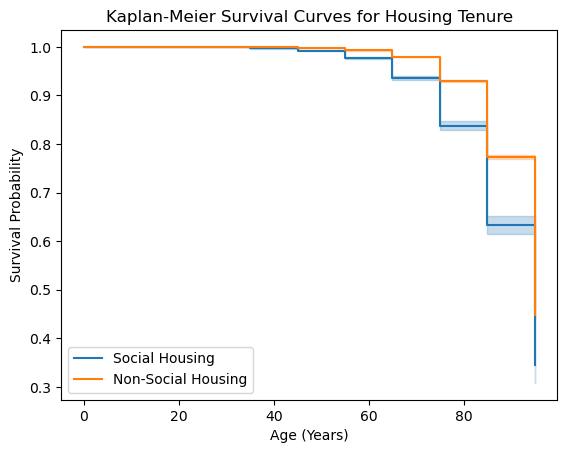

In [67]:

# Separate data for social and non-social housing
social_housing = housingHealthMortality[housingHealthMortality['RSL'] == 1]
non_social_housing = housingHealthMortality[housingHealthMortality['RSL'] == 0]

# Kaplan-Meier estimator for survival analysis
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier estimator for social housing
kmf.fit(durations=social_housing['age_in_years_midpoint'], event_observed=social_housing['year_of_death'], label='Social Housing')
ax = kmf.plot_survival_function()

# Fit the Kaplan-Meier estimator for non-social housing
kmf.fit(durations=non_social_housing['age_in_years_midpoint'], event_observed=non_social_housing['year_of_death'], label='Non-Social Housing')
kmf.plot_survival_function(ax=ax)

plt.title('Kaplan-Meier Survival Curves for Housing Tenure')
plt.xlabel('Age (Years)')
plt.ylabel('Survival Probability')
plt.show()

The survival probabilities by Kaplan-Meier curves indicate a significant difference of the survival probabilities of inhabitants in social and non-social housing. If to compare two groups, genders and ethnicities with the presence and absence of social housing, probabilities of survival stay quite similar until 60, but after that people without non-social housing demonstrate clearly higher rates of survival. The probability of survival of social housing residents at the age of 80 is relatively smaller, about 60% while the non-social housing residents is comparatively higher at 80%.

This imply that survival probability of the residents of social housing decrease at a faster rate to those of the population and this is closely associated with age. The curve depicts how housing tenure impacts the health of any nation hence the need to enhance the living standards of social housing tenants as a way of suggesting that the timeline influences their early death.

**Kaplan-Meier Survival Analysis**

Although the survival probabilities are relatively close for both the samples till the age of 60, a considerable difference is observed at a later stage, where people living in non-social housing have evidently better survival rates. The probability of survival increases as the average age to 80 When the residents of the social housing the probability of survival is about 60% In contrast, the probability of survival among non-social housing residents remains at 80%.

This implies that the survival probabilities of residents of social housing dwindle far much faster than people in other homes and risk gets worsened by age. The curve shows how housing tenure was also identified as a social determinant of health as those in social housing had higher chances of dying early.


In [68]:
# Prepare data for Cox proportional hazards model
cph_data = housingHealthMortality[['age_in_years_midpoint', 'year_of_death', 'RSL', 'popn_Sex']].copy()

print(cph_data.isna().sum())

age_in_years_midpoint    0
year_of_death            0
RSL                      0
popn_Sex                 0
dtype: int64


In [69]:

cph_data = cph_data[cph_data['popn_Sex'].isin(['F', 'M'])]

cph_data = cph_data.dropna()

<lifelines.CoxPHFitter: fitted with 491751 total observations, 473773 right-censored observations>
             duration col = 'age_in_years_midpoint'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 491751
number of events observed = 17978
   partial log-likelihood = -157782.79
         time fit was run = 2024-09-19 04:58:16 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
year_of_death  0.01      1.01      0.00            0.00            0.01                1.00                1.01
RSL            0.53      1.69      0.02            0.48            0.58                1.62                1.78
popn_Sex_M     0.28      1.32      0.01            0.25            0.31                1.28                1.36

               cmp to     z      p  -log2(p)
covariate                                   
year_of_death    0.00  4.56 <0.005     17.61
RSL              0.00 21.45 <0.005    336.60
popn_Sex_M       0.00 18.59 <0.005    253.80
---
Concordance = 0.96
Partial AIC = 315571.59
log-likelihood ratio test = 70167.38 on 3 df
-log2(p) of ll-ratio test = inf

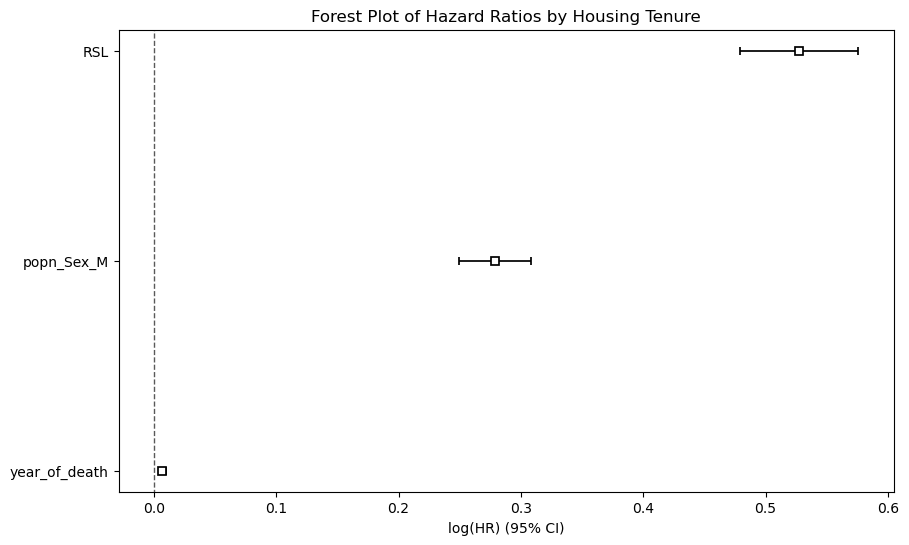

In [70]:

# Convert 'year_of_death' into a binary event column (1 = death occurred, 0 = censored)
cph_data['event'] = cph_data['year_of_death'].apply(lambda x: 1 if x != 0 else 0)

# Convert categorical variables to dummy variables
cph_data = pd.get_dummies(cph_data, columns=['popn_Sex'], drop_first=True)

# Fit the Cox proportional hazards model using 'age_in_years_midpoint' as the duration column
cph = CoxPHFitter()
cph.fit(cph_data, duration_col='age_in_years_midpoint', event_col='event')

# Print summary of the Cox model
cph.print_summary()

# Plot the forest plot for hazard ratios
plt.figure(figsize=(10, 6))
cph.plot()
plt.title('Forest Plot of Hazard Ratios by Housing Tenure')
plt.show()

**Cox Proportional Hazards Model Results**

The Cox Proportional Hazards model develops the measures of mortality risk that specifically relate to social housing. The model predicts that the mortality of people living in social housing is 69% higher than people living in non-social housing with an HR of 1.69. This large disparity implies that the socio-economic factors and possibly health disparities are compounded significantly by people dwelling in social housing thus leading to their higher mortality rates

Besides, the findings reveal that there are higher mortality rates in male sex with a hazard ratio of 1.32 linking to prior research asserting that men commonly have higher mortality rates than females. These figures indicate that strategies aimed at improving the health of male populations, specifically those residing in social houses, can contribute to a decrease in overall mortality rate.

The analysis also emphasizes how particular medical factors influence mortality results. Solid organ transplant recipients had a significantly greater death risk (hazard ratio: 2.27). There is also a high correlation between increased mortality and other disorders including immunosuppressive therapies (HR = 1.23), severe respiratory diseases (HR = 1.10), and cancer (HR = 1.39).
Interestingly, while analysing the effect of taking overlapping medications the results predict a lower hazard ratio of 0. 71, which means that there are specific treatments for this condition; or they live longer regardless of their critical illness.

•	**RSL (Social Housing):** The above model shows that RSL (Social Housing) has a high hazard ratio of 1.69 (95% CI: 1.61–1.77). This means that persons in social housing are 1.69 times more likely to have a higher mortality rate than residents who do not live in social housing and this has provided a clear measure of difference in the survivability of the residents in social housing.

•	**Solid Organ Transplant:** Emergency admissions have the highest hazard ratio of 2. 27 (95% CI: 1. 68–3. 06), which indicates very high risk of mortality among people who received the solid organ transplantation.

•	**Severe Respiratory Disease:** Relative risk of Severe Respiratory Disease is also 1.51 (95% CI: 1. 04–2.19 that supports the concern that patients with serious respiratory diseases are more prone to die from COVID-19.

•	**Other health conditions:** such as cancer (HR: 1. 39, GP Identified Patients (HR: 1. 42), sex (Male, HR: 1. 31) predicted higher Mortality risk.

•	**Renal CKD5:** is concluded to have a lower HR in comparison to the non-renal population, for overall mortality 0.71 (95% CI: 57– 0.88 demonstrating that people with this condition survive better than the average and possibly due to good management or cure.


In [71]:
health_condition_features = [
    '_1_SolidOrganTransplant', '_2_Cancer', '_3_SevereRespiratory', '_4_SevereSingleOrganDisease',
    '_5_RareDiseases', '_6_ImmunosuppressionTherapy', '_7_PregnancyWithCongenitalHeartDisease',
    '_8_GPIdentifiedPatients', '_9_Renal_Dialysis', '_10_Other', '_11_AdultsWithDownsSyndrome', '_12_RenalCKD5'
]

In [72]:
Charlson_Score = [
    'Charl_ami_sc', 'Charl_chf_sc', 'Charl_pvd_sc', 'Charl_cevd_sc', 'Charl_dementia_sc',
    'Charl_pulmonary_sc', 'Charl_Connective_Tissue_sc', 'Charl_Peptic_Ulcer_sc', 'Charl_liver_disease_sc',
    'Charl_diabetes_sc', 'Charl_Complications_Diabetes_sc', 'Charl_Hemiplegia_sc', 'Charl_renal_disease_sc',
    'Charl_cancer_sc', 'Charl_sever_liver_disease_sc', 'Charl_Metastatic_cancer_sc', 'Charl_aids_sc'
]

In [73]:

mortality_col = ['year_of_death', 'RSL']
housingHealthnew[mortality_col] = housingHealthnew[mortality_col].fillna(0)




In [74]:
# Prepare data for Cox proportional hazards model
cph_data_disease = housingHealthnew[['age_in_years_midpoint', 'year_of_death', 'RSL', 'popn_Sex', '_1_SolidOrganTransplant', '_2_Cancer', 
                                     '_3_SevereRespiratory', '_4_SevereSingleOrganDisease', '_6_ImmunosuppressionTherapy', '_8_GPIdentifiedPatients',
                                     '_9_Renal_Dialysis', '_10_Other', '_12_RenalCKD5']].copy()

print(cph_data_disease.isna().sum())

# Filter for F and M in popn_Sex column
cph_data_disease = cph_data_disease[cph_data_disease['popn_Sex'].isin(['F', 'M'])]

# Fill NA values with 0
cph_data_disease = cph_data_disease.fillna(0)

# Convert 'year_of_death' into a binary event column (1 = death occurred, 0 = censored)
cph_data_disease['event'] = cph_data_disease['year_of_death'].apply(lambda x: 1 if x != 0 else 0)

# Convert categorical variables to dummy variables
cph_data_disease = pd.get_dummies(cph_data_disease, columns=['popn_Sex'], drop_first=True)


age_in_years_midpoint          0
year_of_death                  0
RSL                            0
popn_Sex                       0
_1_SolidOrganTransplant        0
_2_Cancer                      0
_3_SevereRespiratory           0
_4_SevereSingleOrganDisease    0
_6_ImmunosuppressionTherapy    0
_8_GPIdentifiedPatients        0
_9_Renal_Dialysis              0
_10_Other                      0
_12_RenalCKD5                  0
dtype: int64


<lifelines.CoxPHFitter: fitted with 491751 total observations, 473773 right-censored observations>
             duration col = 'age_in_years_midpoint'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 491751
number of events observed = 17978
   partial log-likelihood = -157706.86
         time fit was run = 2024-09-19 05:03:19 UTC

---
                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                    
year_of_death                0.01      1.01      0.00            0.00            0.01                1.00                1.01
RSL                          0.52      1.69      0.02            0.47            0.57                1.61                1.77
_1_SolidOrganTransplant      0.82      2.27      0.15            0.52            1.12                1.68                3.06
_2_Cancer                    0.33      1.39      0.04            0.25            0.41                1.28                1.51
_3_SevereRespiratory         0.10      1.10      0.03            0.04            0.15                1.04                1.17
_4_SevereSingleOrganDisease  0.11      1.12      0.08           -0.04            0.26                0.96                1.30
_6_ImmunosuppressionTherapy  0.21      1.23      0.06            0.09            0.33                1.09                1.39
_8_GPIdentifiedPatients      0.35      1.42      0.06            0.23            0.47                1.25                1.60
_9_Renal_Dialysis            0.11      1.11      0.20           -0.30            0.51                0.74                1.66
_10_Other                    0.02      1.02      0.24           -0.44            0.48                0.64                1.62
_12_RenalCKD5               -0.35      0.71      0.11           -0.57           -0.13                0.57                0.88
popn_Sex_M                   0.27      1.31      0.02            0.24            0.30                1.27                1.35

                             cmp to     z      p  -log2(p)
covariate                                                 
year_of_death                  0.00  6.28 <0.005     31.46
RSL                            0.00 21.22 <0.005    329.50
_1_SolidOrganTransplant        0.00  5.36 <0.005     23.55
_2_Cancer                      0.00  8.01 <0.005     49.61
_3_SevereRespiratory           0.00  3.37 <0.005     10.40
_4_SevereSingleOrganDisease    0.00  1.45   0.15      2.78
_6_ImmunosuppressionTherapy    0.00  3.40 <0.005     10.51
_8_GPIdentifiedPatients        0.00  5.54 <0.005     24.95
_9_Renal_Dialysis              0.00  0.52   0.61      0.72
_10_Other                      0.00  0.10   0.92      0.12
_12_RenalCKD5                  0.00 -3.13 <0.005      9.18
popn_Sex_M                     0.00 18.09 <0.005    240.44
---
Concordance = 0.96
Partial AIC = 315437.73
log-likelihood ratio test = 70319.23 on 12 df
-log2(p) of ll-ratio test = inf

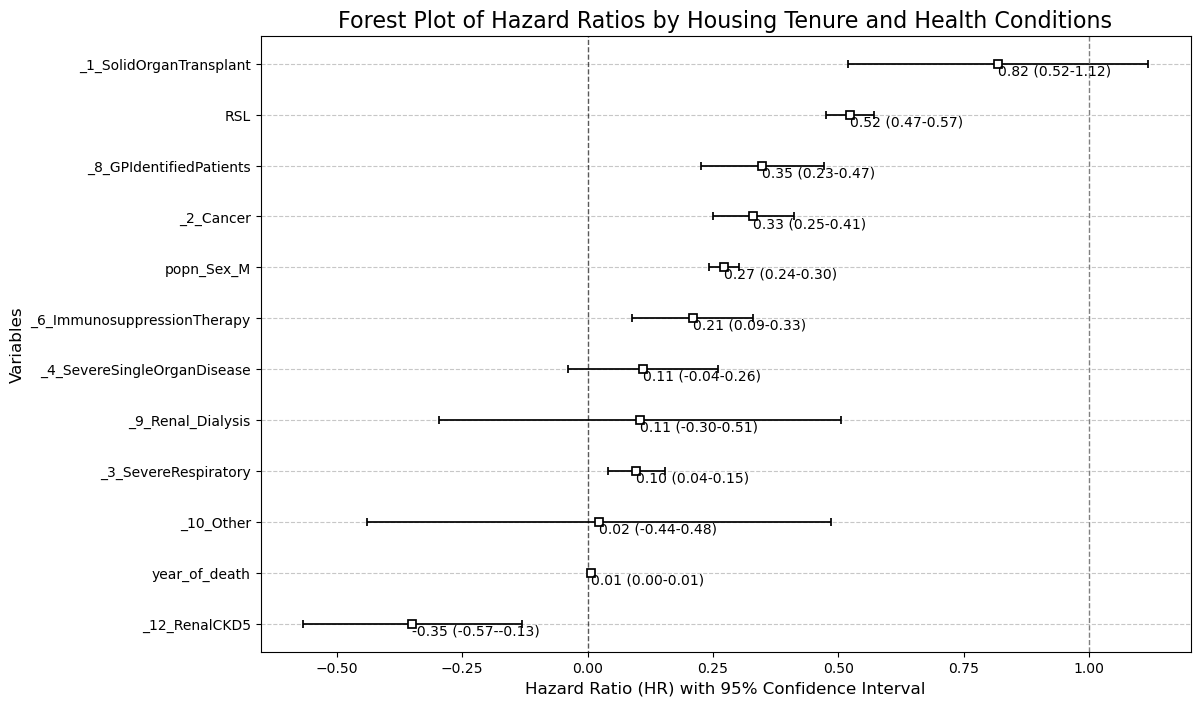

In [76]:

# Fit the Cox proportional hazards model using 'age_in_years_midpoint' as the duration column
cph_2 = CoxPHFitter()
cph_2.fit(cph_data_disease, duration_col='age_in_years_midpoint', event_col='event')

# Print summary of the Cox model
cph_2.print_summary()

# Plot the forest plot for hazard ratios
plt.figure(figsize=(12, 8))
ax = cph_2.plot()

# Enhancing plot details
plt.title('Forest Plot of Hazard Ratios by Housing Tenure and Health Conditions', fontsize=16)
plt.axvline(x=1, color='grey', linestyle='--', lw=1)  # Adding a vertical line at HR=1 for reference
plt.xlabel('Hazard Ratio (HR) with 95% Confidence Interval', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding grid lines for better readability

cph_2sorted = cph_2.summary.sort_values(by='exp(coef)', ascending=True)


for i in range(len(cph_2sorted.index)):
    hr = cph_2sorted.iloc[i]['coef']
    ci_lower = cph_2sorted.iloc[i]['coef lower 95%']
    ci_upper = cph_2sorted.iloc[i]['coef upper 95%']
    ax.text(hr, i, f'{hr:.2f} ({ci_lower:.2f}-{ci_upper:.2f})', fontsize=10, va='top')

plt.show()

In [78]:
housingHealthnew['age_in_years'].value_counts()

age_in_years
30-39    67299
50-59    65458
60-69    60207
40-49    59511
20-29    56565
10-19    54622
70-79    49036
0-9      43921
80-89    27630
90+       8459
Name: count, dtype: int64

In [79]:
housingHealthnew[housingHealthnew['age_in_years']=='10-19'].shape

(54622, 55)

Grouped Gender          resp_admits       emergency_resp_admits       total_admits         \
RSL                0     1                     0     1            0      1   
popn_Sex                                                                     
F              18974  3365                 17312  3095       214819  33325   
M              18466  3233                 16828  3017       170529  23359   

         total_emergency_admits         
RSL                           0      1  
popn_Sex                                
F                        122279  20477  
M                        114278  18000  


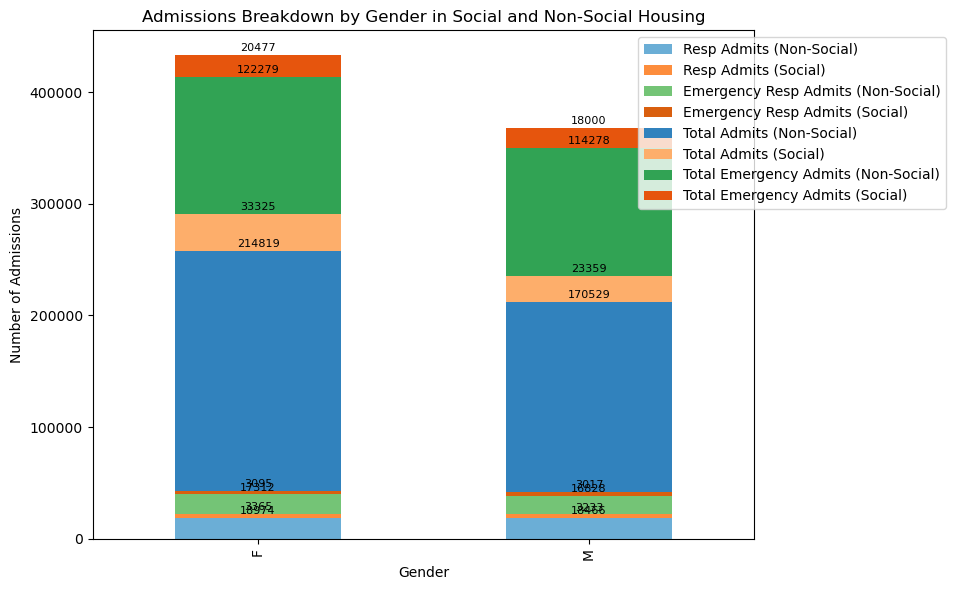

In [80]:
housingHealthnew['RSL'] = housingHealthnew['RSL'].fillna(0)
housingHealthnew['popn_Sex'] = housingHealthnew['popn_Sex'].fillna('Unknown')

# Filter out the 'U' and 'Unknown' categories from gender
housingHealthnew_filtered = housingHealthnew[~housingHealthnew['popn_Sex'].isin(['U', 'Unknown'])]

# Grouping the data by 'popn_Sex', 'RSL', and summing up admissions
grouped_gender = housingHealthnew_filtered.groupby(['popn_Sex', 'RSL']).agg({
    'resp_admits': 'sum',
    'emergency_resp_admits': 'sum',
    'total_admits': 'sum',
    'total_emergency_admits': 'sum'
}).unstack(fill_value=0)

print("Grouped Gender",grouped_gender)
# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Define a more subtle color palette
colors = ['#6baed6', '#fd8d3c', '#74c476', '#d95f0e', '#3182bd', '#fdae6b', '#31a354', '#e6550d']

# Plot male and female admissions for social housing and non-social housing
grouped_gender.plot(kind='bar', stacked=True, ax=ax, color=colors)

# Add count labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., p.get_y() + height), 
                    ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Add labels and title
ax.set_ylabel('Number of Admissions')
ax.set_xlabel('Gender')
ax.set_title('Admissions Breakdown by Gender in Social and Non-Social Housing')

# Simplify the legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [
    'Resp Admits (Non-Social)', 'Resp Admits (Social)',
    'Emergency Resp Admits (Non-Social)', 'Emergency Resp Admits (Social)',
    'Total Admits (Non-Social)', 'Total Admits (Social)',
    'Total Emergency Admits (Non-Social)', 'Total Emergency Admits (Social)'
]
ax.legend(handles, new_labels, loc='upper right', bbox_to_anchor=(1.3, 1))

# Show the plot with tight layout
plt.tight_layout()
plt.show()

In [38]:
import matplotlib.pyplot as plt

# Fill missing values for RSL and gender
housingHealthnew['RSL'] = housingHealthnew['RSL'].fillna(0)
housingHealthnew['popn_Sex'] = housingHealthnew['popn_Sex'].fillna('Unknown')

# Filter out the 'U' and 'Unknown' categories from gender
housingHealthnew_filtered = housingHealthnew[~housingHealthnew['popn_Sex'].isin(['U', 'Unknown'])]

# Grouping the data by 'popn_Sex' and 'RSL', summing up admissions
grouped_gender = housingHealthnew_filtered.groupby(['popn_Sex', 'RSL']).agg({
    'resp_admits': 'sum',
    'emergency_resp_admits': 'sum',
    'total_admits': 'sum',
    'total_emergency_admits': 'sum'
}).unstack(fill_value=0)

# Calculating proportions for each admission type
grouped_gender_prop = grouped_gender.div(grouped_gender.sum(axis=1), axis=0)

grouped_gender_prop*100


resp_admits           emergency_resp_admits           total_admits  \
RSL                0         1                     0         1            0   
popn_Sex                                                                      
F           4.375458  0.775979              3.992196  0.713716    49.537872   
M           5.021892  0.879225              4.576433  0.820484    46.375948   

                  total_emergency_admits            
RSL             1                      0         1  
popn_Sex                                            
F         7.68484              28.197885  4.722054  
M         6.35256              31.078295  4.895162

In [35]:
grouped_gender_prop['resp_admits'][0]

popn_Sex
F    0.043755
M    0.050219
Name: 0, dtype: float64

### Checking missing data in the dataset


In [81]:
missing_data = housingHealthnew.isnull().sum()

missing_outliers_table = pd.DataFrame({
    'Column': housingHealthnew.columns,
    'Missing Count': missing_data
    
})
print(missing_outliers_table)

                                                                        Column  \
unique_ID                                                            unique_ID   
year_of_death                                                    year_of_death   
popn_JCVI                                                            popn_JCVI   
popn_Sex                                                              popn_Sex   
PRS_CAre_Home_Resident                                  PRS_CAre_Home_Resident   
PRS_OCC_unpaid_carer                                      PRS_OCC_unpaid_carer   
_1_SolidOrganTransplant                                _1_SolidOrganTransplant   
_2_Cancer                                                            _2_Cancer   
_3_SevereRespiratory                                      _3_SevereRespiratory   
_4_SevereSingleOrganDisease                        _4_SevereSingleOrganDisease   
_5_RareDiseases                                                _5_RareDiseases   
_6_Immunosuppres

### Descriptive and Statistical Analysis


In [82]:
columns_of_interest = ['Charl_age_sc', 'total_admits', 'emergency_resp_admits']

# Calculate summary statistics: mean, median, standard deviation, min, and max
summary_stats = housingHealthnew[columns_of_interest].agg(['mean', 'median', 'std', 'min', 'max']).T

# Renaming the columns to be more readable
summary_stats.columns = ['Mean', 'Median', 'Std Dev', 'Min', 'Max']

# Display the summary statistics
print(summary_stats)

                           Mean  Median   Std Dev  Min    Max
Charl_age_sc           0.953128     0.0  1.312403  0.0    4.0
total_admits           0.898938     0.0  2.208837  0.0  113.0
emergency_resp_admits  0.082138     0.0  0.574768  0.0   40.0


In [83]:

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 


filtered_data = housingHealthnew[housingHealthnew['total_admits'] == 113]

print(filtered_data)

pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

      unique_ID  year_of_death popn_JCVI popn_Sex PRS_CAre_Home_Resident  \
3590  132946034              0        P3        M                      N   

     PRS_OCC_unpaid_carer  _1_SolidOrganTransplant  _2_Cancer  \
3590                  NaN                      0.0        0.0   

      _3_SevereRespiratory  _4_SevereSingleOrganDisease  _5_RareDiseases  \
3590                   0.0                          0.0              0.0   

      _6_ImmunosuppressionTherapy  _7_PregnancyWithCongenitalHeartDisease  \
3590                          0.0                                     0.0   

      _8_GPIdentifiedPatients  _9_Renal_Dialysis  _10_Other  \
3590                      0.0                0.0        0.0   

      _11_AdultsWithDownsSyndrome  _12_RenalCKD5  Charl_age_sc  Charl_ami_sc  \
3590                          0.0            1.0             3           0.0   

      Charl_chf_sc  Charl_pvd_sc  Charl_cevd_sc  Charl_dementia_sc  \
3590           0.0           1.0            1.0   

In [84]:

housingHealthnew[housingHealthnew['Charl_age_sc'] == 4]

unique_ID  year_of_death popn_JCVI popn_Sex PRS_CAre_Home_Resident  \
21         1161627           2023      P2.1        M                      N   
31         9261464              0      P2.1        F                      N   
83         9061468           2022      P2.1        F                      Y   
93         4561428              0      P1.1        F                      Y   
137        9947300              0      P2.1        M                      N   
...            ...            ...       ...      ...                    ...   
492644  9967261447           2023      P0.3        F                      N   
492653  9970361484              0      P2.1        F                      N   
492656  9971461640              0      P2.1        F                      N   
492668  9978740427           2024      P2.1        M                      N   
492670  9980149015              0      P2.1        F                      N   

       PRS_OCC_unpaid_carer  _1_SolidOrganTransplant  _2_Cancer  \
21                      NaN                      0.0        0.0   
31                      NaN                      0.0        0.0   
83                      NaN                      0.0        0.0   
93                      NaN                      0.0        0.0   
137                     NaN                      0.0        0.0   
...                     ...                      ...        ...   
492644                  NaN                      0.0        0.0   
492653                  NaN                      0.0        0.0   
492656                  NaN                      0.0        0.0   
492668                  NaN                      0.0        0.0   
492670                  NaN                      0.0        0.0   

        _3_SevereRespiratory  _4_SevereSingleOrganDisease  ...  \
21                       0.0                          0.0  ...   
31                       0.0                          0.0  ...   
83                       0.0                          0.0  ...   
93                       0.0                          0.0  ...   
137                      0.0                          0.0  ...   
...                      ...                          ...  ...   
492644                   0.0                          0.0  ...   
492653                   0.0                          0.0  ...   
492656                   0.0                          0.0  ...   
492668                   0.0                          0.0  ...   
492670                   0.0                          0.0  ...   

        current_energy_efficiency   transaction_type  lodgement_date  \
21                            NaN                NaN             NaT   
31                            NaN                NaN             NaT   
83                            NaN                NaN             NaT   
93                            NaN                NaN             NaT   
137                           NaN                NaN             NaT   
...                           ...                ...             ...   
492644                       56.0  none of the above      2013-09-13   
492653                        NaN                NaN             NaT   
492656                       71.0     ECO assessment      2022-02-02   
492668                        NaN                NaN             NaT   
492670                        NaN                NaN             NaT   

                tenure  RSL  age_in_years_midpoint  planned_resp_admits  \
21                 NaN    0                     85                    0   
31                 NaN    0                     85                    0   
83                 NaN    0                     95                    0   
93                 NaN    0                     95                    0   
137                NaN    0                     85                    0   
...                ...  ...                    ...                  ...   
492644  owner-occupied    0                     85                    2 

In [85]:
housingHealthnew[housingHealthnew['emergency_resp_admits'] == 40]

unique_ID  year_of_death popn_JCVI popn_Sex PRS_CAre_Home_Resident  \
226524  7464748639           2023        P6        F                      N   
253057  8149461483           2023      P2.1        M                      N   

       PRS_OCC_unpaid_carer  _1_SolidOrganTransplant  _2_Cancer  \
226524                  NaN                      0.0        0.0   
253057                  NaN                      0.0        0.0   

        _3_SevereRespiratory  _4_SevereSingleOrganDisease  ...  \
226524                   1.0                          0.0  ...   
253057                   1.0                          0.0  ...   

        current_energy_efficiency   transaction_type  lodgement_date  \
226524                        NaN                NaN             NaT   
253057                       45.0  none of the above      2013-10-09   

                tenure  RSL  age_in_years_midpoint  planned_resp_admits  \
226524             NaN    0                     65                    1   
253057  owner-occupied    0                     85                    0   

        total_planned_admissions  non_resp_planned_admissions  \
226524                         1                            0   
253057                         3                            3   

               property_combination  
226524                     nan: nan  
253057  Residential: owner-occupied  

[2 rows x 55 columns]

### RQ Extra :  How housing energy and efficiency are correlated with Charlson Score and health conditions in different RSL groups.

## Housing Energy and Health Comparison 

In [43]:
health_condition_features = [
    '_1_SolidOrganTransplant', '_2_Cancer', '_3_SevereRespiratory', '_4_SevereSingleOrganDisease',
     '_6_ImmunosuppressionTherapy', '_7_PregnancyWithCongenitalHeartDisease',
    '_8_GPIdentifiedPatients', '_9_Renal_Dialysis', '_10_Other', '_11_AdultsWithDownsSyndrome', '_12_RenalCKD5'
]

charlson_score = [
    'Charl_ami_sc', 'Charl_chf_sc', 'Charl_pvd_sc', 'Charl_cevd_sc', 'Charl_dementia_sc',
    'Charl_pulmonary_sc', 'Charl_Connective_Tissue_sc', 'Charl_Peptic_Ulcer_sc', 'Charl_liver_disease_sc',
    'Charl_diabetes_sc', 'Charl_Complications_Diabetes_sc', 'Charl_Hemiplegia_sc', 'Charl_renal_disease_sc',
    'Charl_cancer_sc', 'Charl_sever_liver_disease_sc', 'Charl_Metastatic_cancer_sc', 'Charl_aids_sc'
]

# Fill NaN in health condition columns with 0 
housingHealthnew[health_condition_features] = housingHealthnew[health_condition_features].fillna(0)

housingHealthnew[charlson_score] = housingHealthnew[charlson_score].fillna(0)

In [44]:
print(housingHealthnew['current_energy_efficiency'].isnull().sum())
print(housingHealthnew['current_energy_rating'].isnull().sum())

200230
200230


In [45]:
# Treating Z as a separate category for current_energy_rating
housingHealthnew['current_energy_rating'] = housingHealthnew['current_energy_rating'].fillna('Z')

# current_energy_efficiency is numeric
housingHealthnew['current_energy_efficiency'] = pd.to_numeric(housingHealthnew['current_energy_efficiency'], errors='coerce')

housingHealthnew['current_energy_efficiency'] = housingHealthnew['current_energy_efficiency'].fillna(0)





In [46]:
housingHealthnew['current_energy_rating'].unique()

array(['Z', 'D', 'C', 'B', 'E', 'F', 'G', 'A'], dtype=object)

In [47]:
housingHealthnew['current_energy_efficiency'].unique()

array([  0.,  65.,  72.,  82.,  56.,  74.,  43.,  69.,  62.,  70.,  58.,
        59.,  40.,  71.,  85.,  53.,  54.,  60.,  68.,  81.,  61.,  57.,
        67.,  76.,  66.,  47.,  51.,  73.,  75.,  55.,  52.,  45.,  84.,
        44.,  31.,  41.,  63.,  64.,  49.,  13.,  83.,  46.,  37.,  48.,
        38.,  79.,  89.,  80.,  50.,  87.,  42.,  94.,  34.,  88.,  77.,
        86.,  29.,  30.,  78.,  39.,  35.,  32.,  99.,  18.,  92.,  36.,
        22.,   2.,  14.,  33.,  91.,   6.,  16.,  21.,  23.,  20.,  17.,
        90.,  97.,  25.,   1.,  26.,  28.,   8.,   7.,  27.,   3.,  98.,
       102., 101., 100.,   5.,   4.,  11.,  96.,  15.,   9.,  12.,  95.,
        93.,  24.,  19., 110.,  10., 107., 115., 103., 104., 111., 105.,
       108., 106.])

In [48]:
housingHealthnew.head()

unique_ID  year_of_death popn_JCVI popn_Sex PRS_CAre_Home_Resident  \
0     142839              0        P6        M                      N   
1     661639              0        P3        F                      N   
2     948642              0        P7        F                      N   
3    2046034              0      P4.1        F                      N   
4    2348639              0        P6        M                      N   

  PRS_OCC_unpaid_carer  _1_SolidOrganTransplant  _2_Cancer  \
0                  NaN                      0.0        0.0   
1                  NaN                      0.0        0.0   
2                  NaN                      0.0        0.0   
3                    Y                      0.0        0.0   
4                  NaN                      0.0        0.0   

   _3_SevereRespiratory  _4_SevereSingleOrganDisease  ...  rownum  \
0                   0.0                          0.0  ...       1   
1                   0.0                          0.0  ...       1   
2                   0.0                          0.0  ...       1   
3                   0.0                          0.0  ...       1   
4                   0.0                          0.0  ...       1   

   age_in_years  primary_desc  tertiary_desc  current_energy_rating  \
0         50-59           NaN            NaN                      Z   
1         70-79           NaN            NaN                      Z   
2         60-69   Residential       Terraced                      D   
3         70-79   Residential  Semi-Detached                      C   
4         60-69           NaN            NaN                      Z   

   current_energy_efficiency  transaction_type  lodgement_date  \
0                        0.0               NaN             NaT   
1                        0.0               NaN             NaT   
2                       65.0            rental      2021-10-06   
3                       72.0   rental (social)      2010-06-08   
4                        0.0               NaN             NaT   

             tenure  RSL  
0               NaN    0  
1               NaN    0  
2  Rented (private)    0  
3   rental (social)    0  
4               NaN    0  

[5 rows x 50 columns]

In [51]:
# Proportions of health conditions by energy rating and RSL (Social Housing)
proportion_by_energy_rating = housingHealthnew.groupby(['current_energy_rating', 'RSL'])[health_condition_features].mean()
proportion_by_energy_rating = proportion_by_energy_rating*100
print(proportion_by_energy_rating)

                           _1_SolidOrganTransplant  _2_Cancer  \
current_energy_rating RSL                                       
A                     0                   0.295858   0.887574   
                      1                   0.000000   0.271003   
B                     0                   0.045811   0.488649   
                      1                   0.100284   0.484707   
C                     0                   0.052773   0.429222   
                      1                   0.090539   0.554550   
D                     0                   0.058694   0.484668   
                      1                   0.052607   0.506346   
E                     0                   0.058357   0.525217   
                      1                   0.000000   0.594648   
F                     0                   0.101611   0.508056   
                      1                   0.625000   0.000000   
G                     0                   0.000000   0.336474   
                      1  

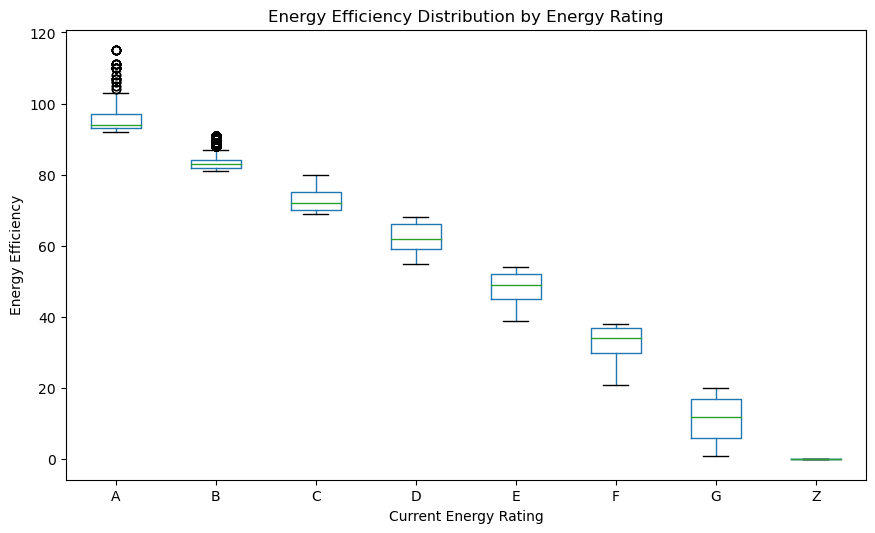

In [105]:
# Box plot to visualize energy efficiency and health conditions
housingHealthnew.boxplot(column='current_energy_efficiency', by='current_energy_rating', grid=False, figsize=(10, 6))
plt.title('Energy Efficiency Distribution by Energy Rating')
plt.suptitle('')
plt.xlabel('Current Energy Rating')
plt.ylabel('Energy Efficiency')
plt.show()

In [52]:
proportion_by_energy_rating

_1_SolidOrganTransplant  _2_Cancer  \
current_energy_rating RSL                                       
A                     0                   0.295858   0.887574   
                      1                   0.000000   0.271003   
B                     0                   0.045811   0.488649   
                      1                   0.100284   0.484707   
C                     0                   0.052773   0.429222   
                      1                   0.090539   0.554550   
D                     0                   0.058694   0.484668   
                      1                   0.052607   0.506346   
E                     0                   0.058357   0.525217   
                      1                   0.000000   0.594648   
F                     0                   0.101611   0.508056   
                      1                   0.625000   0.000000   
G                     0                   0.000000   0.336474   
                      1                   0.000000   0.000000   
Z                     0                   0.082405   1.036808   

                           _3_SevereRespiratory  _4_SevereSingleOrganDisease  \
current_energy_rating RSL                                                      
A                     0                0.887574                     0.000000   
                      1                1.626016                     0.542005   
B                     0                0.509009                     0.091622   
                      1                2.724386                     0.250710   
C                     0                0.904181                     0.133692   
                      1                2.391731                     0.301796   
D                     0                0.894636                     0.138731   
                      1                2.097718                     0.190702   
E                     0                1.102058                     0.148138   
                      1                2.675917                     0.247770   
F                     0                0.885470                     0.203223   
                      1                6.875000                     0.000000   
G                     0                1.009421                     0.269179   
                      1                3.846154                     0.000000   
Z                     0                1.884832                     0.274684   

                           _6_ImmunosuppressionTherapy  \
current_energy_rating RSL                                
A                     0                       1.479290   
                      1                       0.813008   
B                     0                       0.595541   
                      1                       0.852415   
C                     0                       0.620965   
                      1                       0.784669   
D                     0                       0.626067   
                      1                       0.683896   
E                     0                       0.686822   
                      1                       0.495540   
F                     0                       0.783858   
                      1                       1.875000   
G                     0                       0.605653   
                      1                       3.846154   
Z                     0                       1.118214   

                           _7_PregnancyWithCongenitalHeartDisease  \
current_energy_rating RSL                                           
A                     0                                  0.000000   
                      1                                  0.000000   
B                     0                                  0.000000   
                      1                                  0.016714   
C                     0                                  0.003518   
                      1                                  0.003772   
D                    

In [53]:
# proportion_by_energy_rating is grouped DataFrame with mean values by 'energy_rating' and 'RSL' for Health conditions
proportion_by_energy_rating_rsl_0 = proportion_by_energy_rating.xs(0, level='RSL')
proportion_by_energy_rating_rsl_1 = proportion_by_energy_rating.xs(1, level='RSL')


In [54]:
proportion_by_energy_rating_rsl_0.columns = [col.replace('_', '') for col in proportion_by_energy_rating_rsl_0.columns]
proportion_by_energy_rating_rsl_1.columns = [col.replace('_', '') for col in proportion_by_energy_rating_rsl_1.columns]


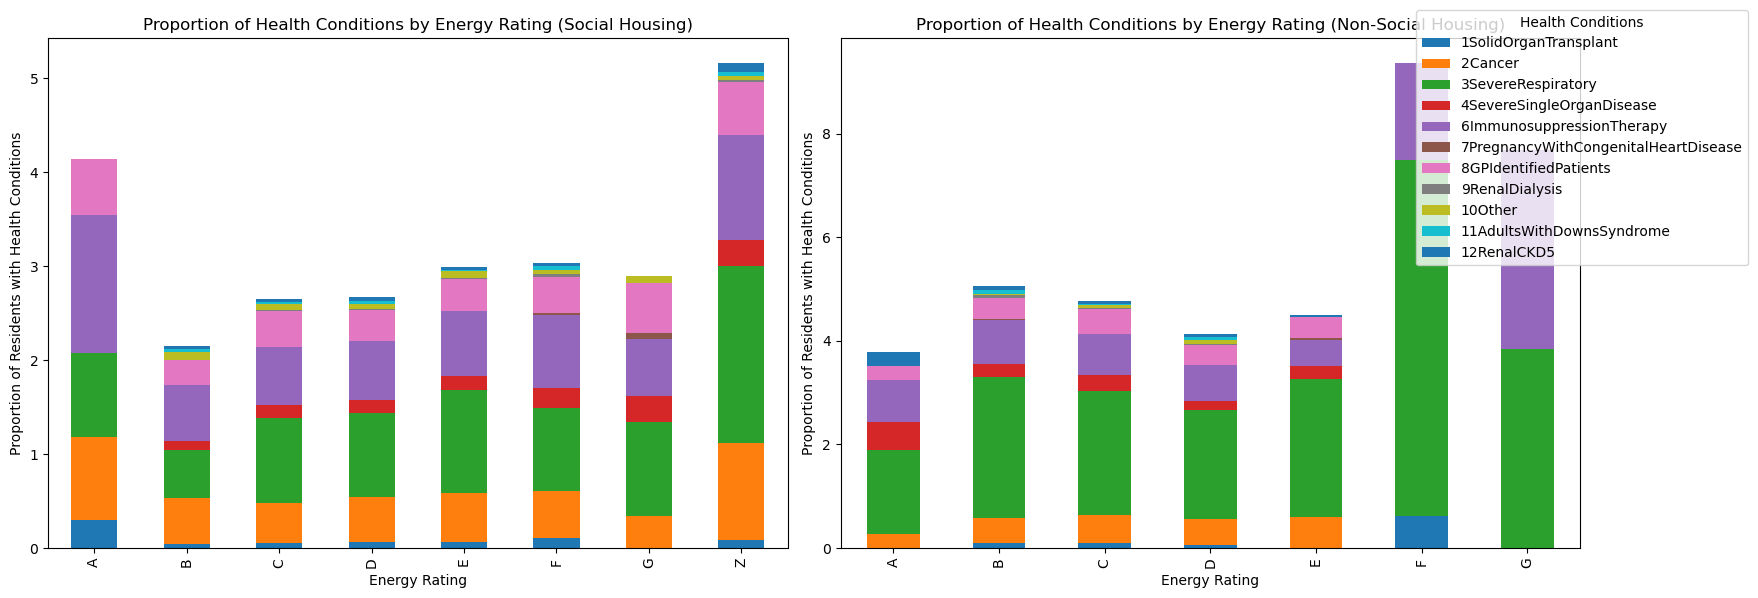

In [55]:
# Create subplots to display both charts side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot for Social Housing (RSL == 0)
proportion_by_energy_rating_rsl_0.plot(kind='bar', stacked=True, ax=axes[0], legend=False)
axes[0].set_title('Proportion of Health Conditions by Energy Rating (Social Housing)')
axes[0].set_xlabel('Energy Rating')
axes[0].set_ylabel('Proportion of Residents with Health Conditions')

# Plot for Non-Social Housing (RSL == 1)
proportion_by_energy_rating_rsl_1.plot(kind='bar', stacked=True, ax=axes[1], legend=False)
axes[1].set_title('Proportion of Health Conditions by Energy Rating (Non-Social Housing)')
axes[1].set_xlabel('Energy Rating')
axes[1].set_ylabel('Proportion of Residents with Health Conditions')

# Adjust the layout
plt.tight_layout()

# Adding a single legend for both subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Health Conditions', bbox_to_anchor=(1.1, 1))

# Display the plots
plt.show()

In [56]:
# proportion_by_energy_rating is grouped DataFrame with mean values by 'energy_rating' and 'RSL' for Health conditions
proportion_by_energy_rating_rsl_0 = proportion_by_energy_rating.xs(0, level='RSL')
proportion_by_energy_rating_rsl_1 = proportion_by_energy_rating.xs(1, level='RSL')

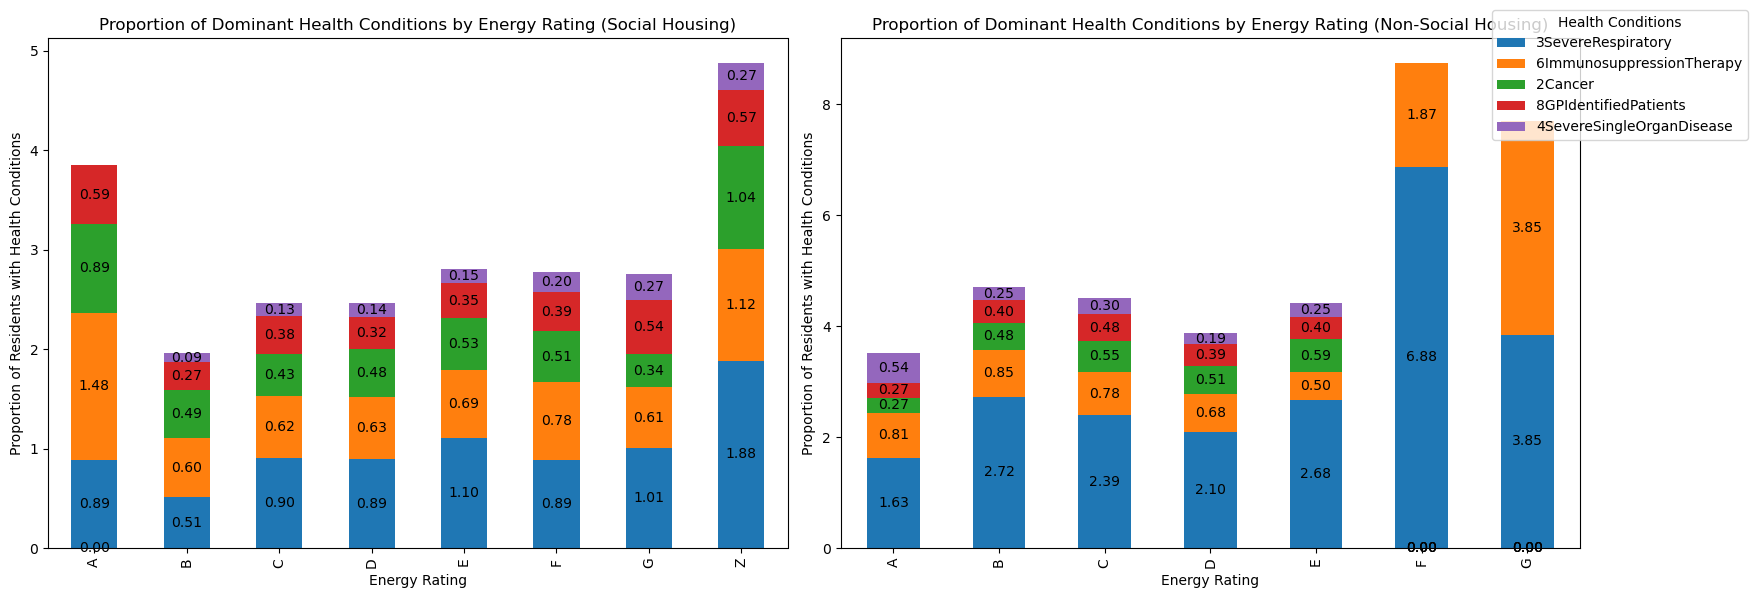

In [57]:

dominant_conditions = proportion_by_energy_rating.mean().nlargest(5).index.tolist()

# Filter data for the top 5 health conditions for RSL 0 and RSL 1
proportion_by_energy_rating_rsl_0_top5 = proportion_by_energy_rating_rsl_0[dominant_conditions]
proportion_by_energy_rating_rsl_1_top5 = proportion_by_energy_rating_rsl_1[dominant_conditions]

proportion_by_energy_rating_rsl_0_top5.columns = [col.replace('_', '') for col in proportion_by_energy_rating_rsl_0_top5.columns]
proportion_by_energy_rating_rsl_1_top5.columns = [col.replace('_', '') for col in proportion_by_energy_rating_rsl_1_top5.columns]


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

#Plot for Social Housing (RSL == 0) and annotate each section with percentages
bars_rsl_0 = proportion_by_energy_rating_rsl_0_top5.plot(kind='bar', stacked=True, ax=axes[0], legend=False)
axes[0].set_title('Proportion of Dominant Health Conditions by Energy Rating (Social Housing)')
axes[0].set_xlabel('Energy Rating')
axes[0].set_ylabel('Proportion of Residents with Health Conditions')

# Add percentage annotations
for container in bars_rsl_0.containers:
    bars_rsl_0.bar_label(container, fmt='%.2f', label_type='center')


bars_rsl_1 = proportion_by_energy_rating_rsl_1_top5.plot(kind='bar', stacked=True, ax=axes[1], legend=False)
axes[1].set_title('Proportion of Dominant Health Conditions by Energy Rating (Non-Social Housing)')
axes[1].set_xlabel('Energy Rating')
axes[1].set_ylabel('Proportion of Residents with Health Conditions')

for container in bars_rsl_1.containers:
    bars_rsl_1.bar_label(container, fmt='%.2f', label_type='center')

plt.tight_layout()

# Adding a single legend for both subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Health Conditions', bbox_to_anchor=(1.1, 1))

plt.show()

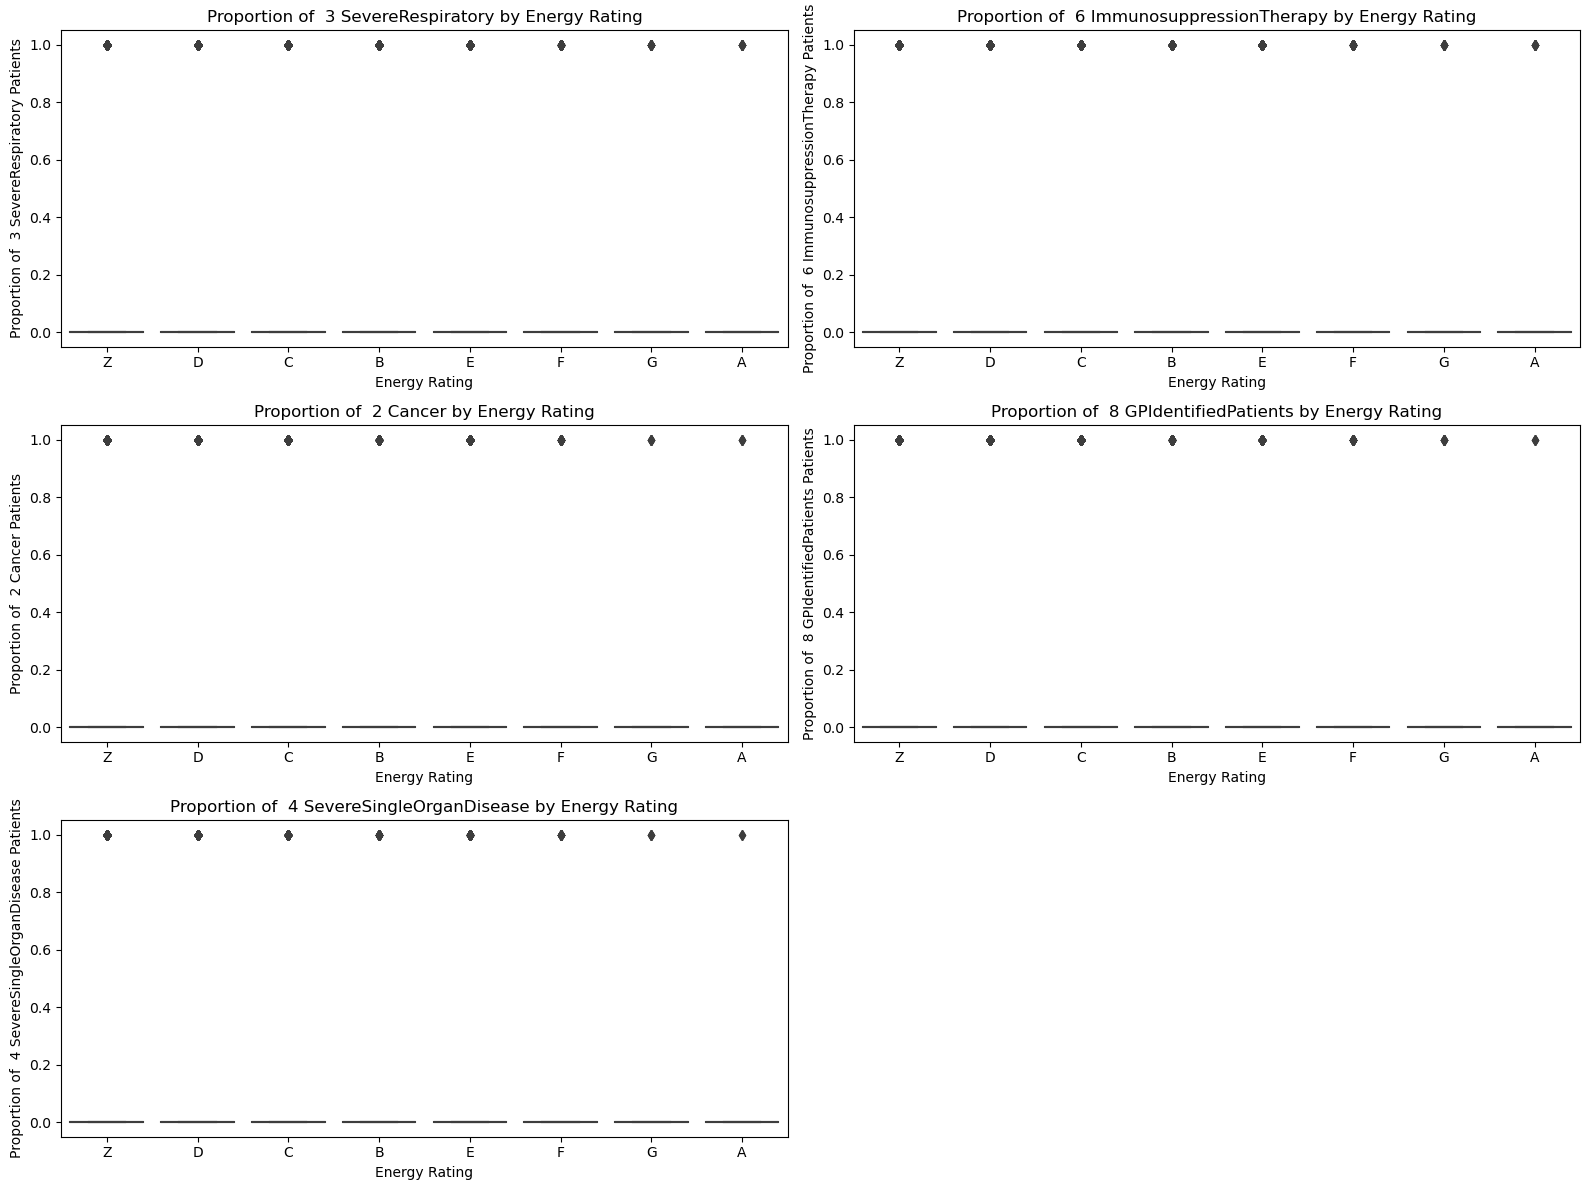

In [58]:
dominant_conditions = proportion_by_energy_rating.mean().nlargest(5).index.tolist()


fig, axes = plt.subplots(3, 2, figsize=(16, 12))  
axes = axes.flatten()  # Flatten the axes for easy indexing


for i, cond in enumerate(dominant_conditions):
    sns.boxplot(data=housingHealthnew, x='current_energy_rating', y=cond, ax=axes[i])
    axes[i].set_title(f'Proportion of {cond.replace("_", " ")} by Energy Rating')
    axes[i].set_xlabel('Energy Rating')
    axes[i].set_ylabel(f'Proportion of {cond.replace("_", " ")} Patients')

# Remove the last empty subplot if necessary
if len(dominant_conditions) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout() 
plt.show()

In [59]:
housingHealthnew['Health_Condition_Aggregate'] = housingHealthnew[[
    '_1_SolidOrganTransplant', '_2_Cancer', '_3_SevereRespiratory', '_4_SevereSingleOrganDisease',
     '_6_ImmunosuppressionTherapy', '_7_PregnancyWithCongenitalHeartDisease',
    '_8_GPIdentifiedPatients', '_9_Renal_Dialysis', '_10_Other', '_11_AdultsWithDownsSyndrome', '_12_RenalCKD5'
]].sum(axis=1)

Correlation between Energy Efficiency and Aggregate Health COndition: -0.04918167283159044


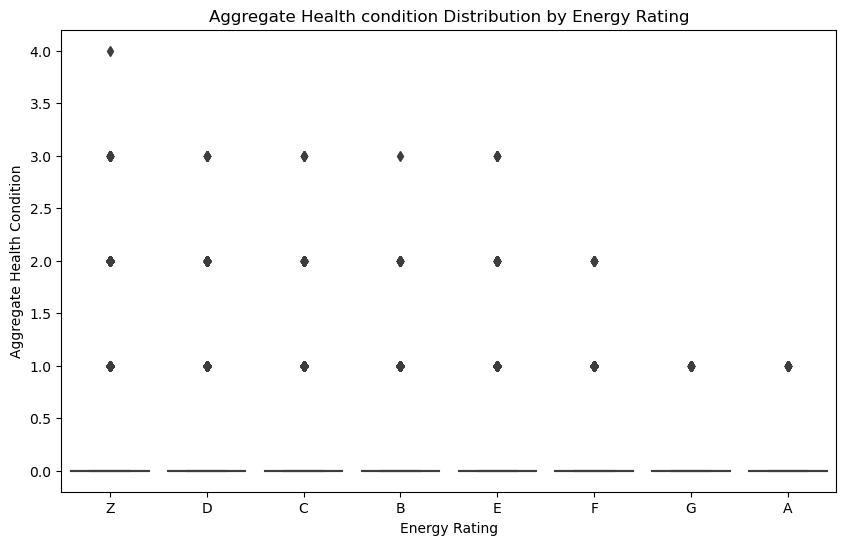

In [60]:
corr_efficiency_Health_agg = housingHealthnew['current_energy_efficiency'].corr(housingHealthnew['Health_Condition_Aggregate'], method='pearson')
print(f"Correlation between Energy Efficiency and Aggregate Health COndition: {corr_efficiency_Health_agg}")

# Plot Energy Ratings vs Aggregate Charlson Score
plt.figure(figsize=(10, 6))
sns.boxplot(data=housingHealthnew, x='current_energy_rating', y='Health_Condition_Aggregate')
plt.title('Aggregate Health condition Distribution by Energy Rating')
plt.xlabel('Energy Rating')
plt.ylabel('Aggregate Health Condition')
plt.show()


In [61]:
# Count the number of residents with a Health score of 0
zero_health_count = housingHealthnew[housingHealthnew['Health_Condition_Aggregate'] == 0].shape[0]
total_residents = housingHealthnew.shape[0]

# Calculate the proportion of residents with Charlson score 0
zero_health_percentage = (zero_health_count / total_residents) * 100
print(f"Percentage of residents with Health Score of 0: {zero_health_percentage:.2f}%")

Percentage of residents with Health Score of 0: 96.27%


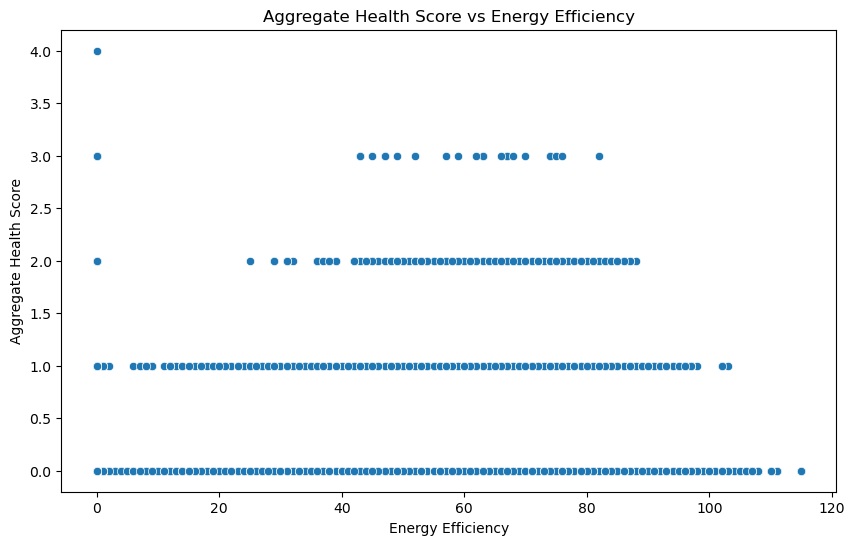

In [62]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=housingHealthnew, x='current_energy_efficiency', y='Health_Condition_Aggregate')
plt.title('Aggregate Health Score vs Energy Efficiency')
plt.xlabel('Energy Efficiency')
plt.ylabel('Aggregate Health Score')
plt.show()

### let's check where Health Score >0

Correlation between Energy Efficiency and Aggregate Health Condition (filtered): -0.00184644412389367


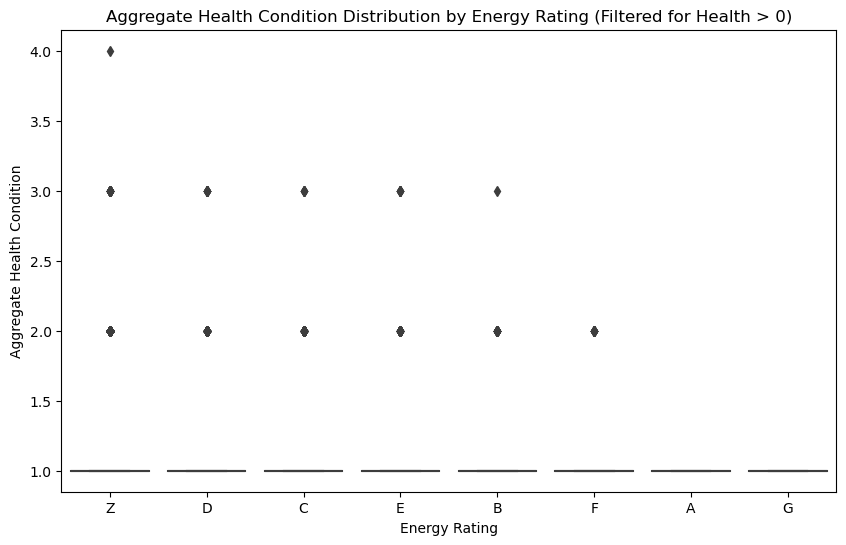

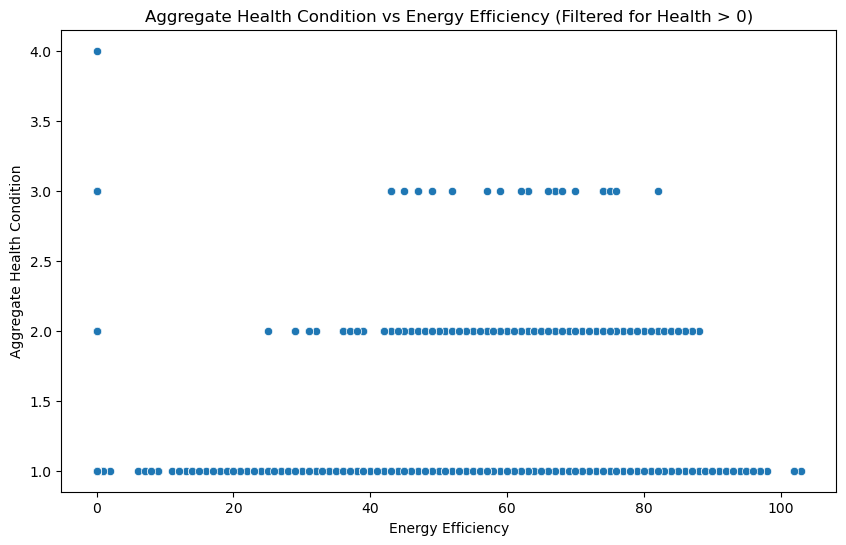

In [63]:
filtered_data = housingHealthnew[housingHealthnew['Health_Condition_Aggregate'] > 0]

# Recalculate the correlation between Energy Efficiency and Aggregate Health Condition (for rows where health condition > 0)
corr_efficiency_health_agg_filtered = filtered_data['current_energy_efficiency'].corr(filtered_data['Health_Condition_Aggregate'], method='pearson')
print(f"Correlation between Energy Efficiency and Aggregate Health Condition (filtered): {corr_efficiency_health_agg_filtered}")


# Plot Energy Ratings vs Aggregate Health Condition (filtered)
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, x='current_energy_rating', y='Health_Condition_Aggregate')
plt.title('Aggregate Health Condition Distribution by Energy Rating (Filtered for Health > 0)')
plt.xlabel('Energy Rating')
plt.ylabel('Aggregate Health Condition')
plt.show()


# Plot Energy Efficiency vs Aggregate Health Condition (filtered)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data, x='current_energy_efficiency', y='Health_Condition_Aggregate')
plt.title('Aggregate Health Condition vs Energy Efficiency (Filtered for Health > 0)')
plt.xlabel('Energy Efficiency')
plt.ylabel('Aggregate Health Condition')
plt.show()

In [64]:
# Calculate the number of data points for each energy rating where 'Health_Condition_Aggregate' is greater than 0
data_points_per_energy_rating = housingHealthnew[housingHealthnew['Health_Condition_Aggregate'] > 0].
groupby('current_energy_rating').size()

# Display the result
print(data_points_per_energy_rating)

current_energy_rating
A      28
B     695
C    2657
D    3485
E    1353
F     210
G      45
Z    9906
dtype: int64


The goal of this research question is to investigate how energy efficiency in housing correlates with the prevalence of health conditions and Charlson comorbidities, specifically across different housing tenures: RSL = 1, for the social housing sector and RSL = 0 i.e. non-social housing. The study explores the effects of energy efficiency on health of residents by coming with current energy efficiency ratings and scores.

**Proportions of Health Conditions by Energy Rating**

The various health conditions and Charlson comorbidities are first standardized and presented as total proportions by energy rating for the social housing and non-social housing groups. This offers a glimpse of how various health conditions are apportioned in relation to households with varying levels of energy efficiency.


**Key Findings:**

•	People living in low energy rated homes, in this case F and G or below, in social housing are more likely to suffer severe respiratory illnesses and cancer as compared to those living in other housing types.

•	From the social and non-social housing groups, a better energy efficiency rating of A, B and C shows that a lesser percentage of the residents suffer from serious ailments including cancer and respiratory diseases.

•	Energy rating ‘Z’, which considers for missing value, revealed a higher proportion of multiple conditions in non-social housing, this includes cancer and GP-identified patients.

•	The results suggest that as the energy rating declines, the prevalence of severe health conditions rises in social housing. For instance, those living in homes with an energy rating of F had a tendency of respiratory and cancer ailments.

•	The same was observed with non-social housing where however, the prevalence of these conditions was slightly lower than that observed among the social housing population.



## Charlson Score Aggregation

In [65]:
# Proportions of Charlson Score by energy rating and RSL (Social Housing)
charlson_proportion_by_energy_rating = housingHealthnew.groupby(['current_energy_rating', 'RSL'])[charlson_score].mean()

charlson_proportion_by_energy_rating = charlson_proportion_by_energy_rating*100
print(charlson_proportion_by_energy_rating)

                           Charl_ami_sc  Charl_chf_sc  Charl_pvd_sc  \
current_energy_rating RSL                                             
A                     0        1.479290      0.591716      0.000000   
                      1        2.710027      3.252033      3.252033   
B                     0        0.900947      0.666802      0.397027   
                      1        2.323249      1.955541      1.069697   
C                     0        1.178602      1.092406      0.599856   
                      1        2.142749      1.856043      1.086464   
D                     0        1.278813      1.084946      0.634071   
                      1        1.814954      1.459854      1.019267   
E                     0        1.328755      1.185105      0.675600   
                      1        1.337958      0.891972      1.238850   
F                     0        1.393526      1.335462      0.827406   
                      1        0.000000      2.500000      1.250000   
G     

In [66]:
# charlson_proportion_by_energy_rating is grouped DataFrame with mean values by 'energy_rating' and 'RSL' for Health conditions
charlson_proportion_by_energy_rating_rsl_0 = charlson_proportion_by_energy_rating.xs(0, level='RSL')
charlson_proportion_by_energy_rating_rsl_1 = charlson_proportion_by_energy_rating.xs(1, level='RSL')



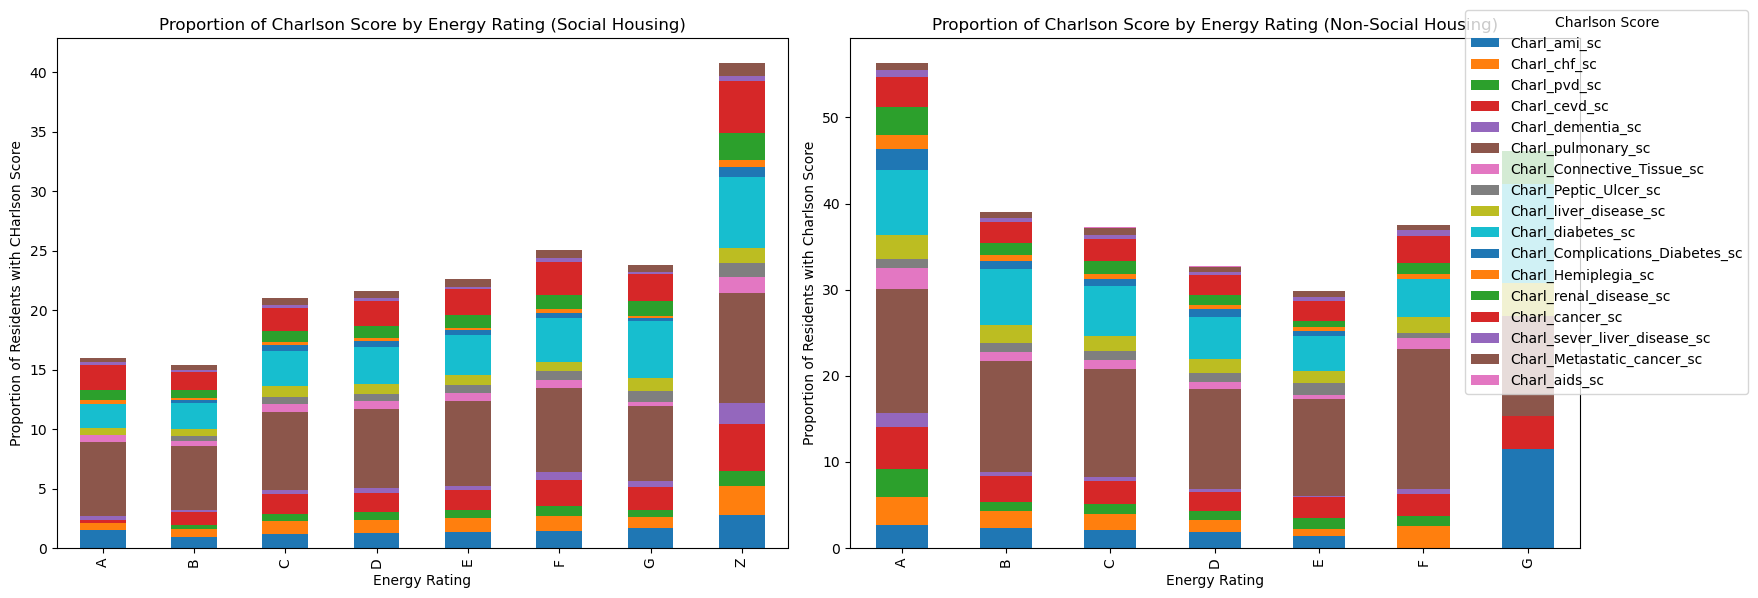

In [67]:
# Create subplots to display both charts side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot for Social Housing (RSL == 0)
charlson_proportion_by_energy_rating_rsl_0.plot(kind='bar', stacked=True, ax=axes[0], legend=False)
axes[0].set_title('Proportion of Charlson Score by Energy Rating (Social Housing)')
axes[0].set_xlabel('Energy Rating')
axes[0].set_ylabel('Proportion of Residents with CHarlson Score')

# Plot for Non-Social Housing (RSL == 1)
charlson_proportion_by_energy_rating_rsl_1.plot(kind='bar', stacked=True, ax=axes[1], legend=False)
axes[1].set_title('Proportion of Charlson Score by Energy Rating (Non-Social Housing)')
axes[1].set_xlabel('Energy Rating')
axes[1].set_ylabel('Proportion of Residents with Charlson Score')

# Adjust the layout
plt.tight_layout()

# Adding a single legend for both subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Charlson Score', bbox_to_anchor=(1.1, 1))

# Display the plots
plt.show()

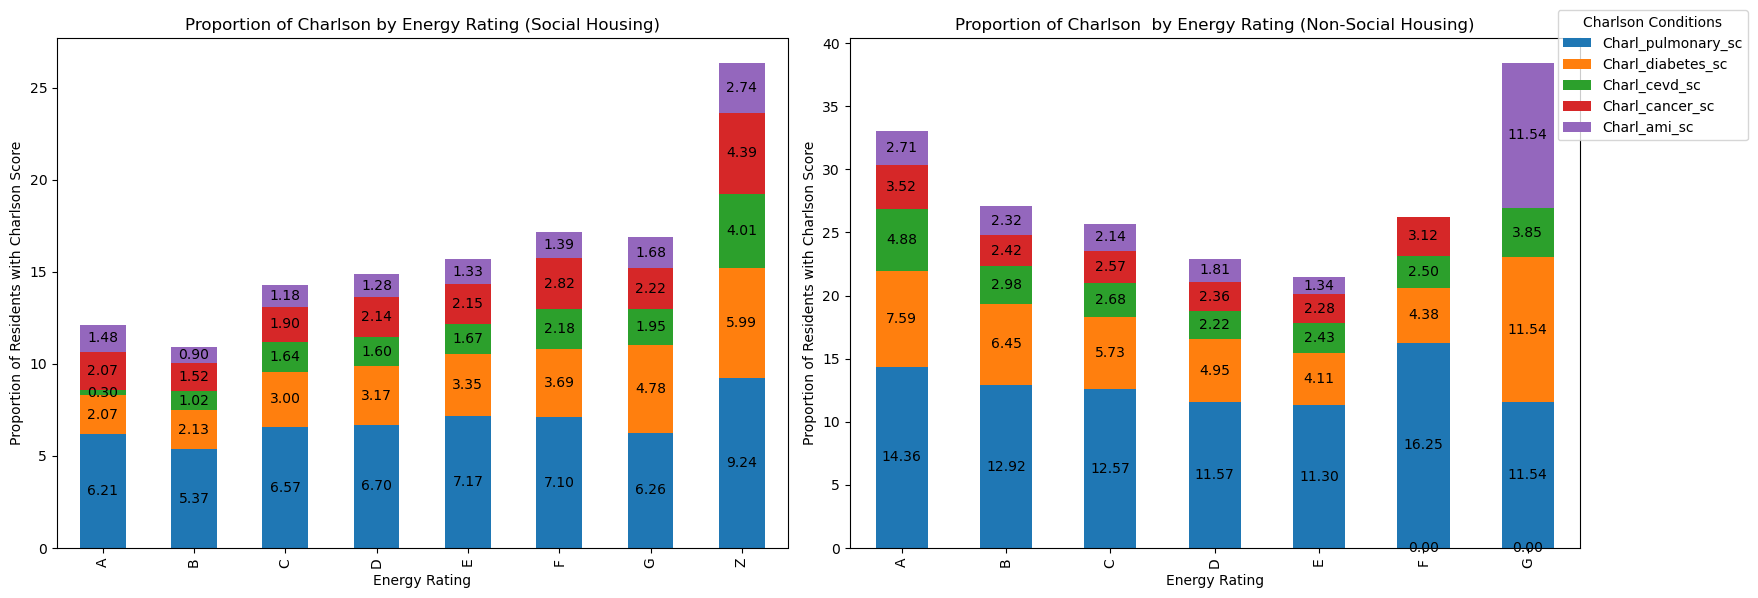

In [68]:
# charlson_proportion_by_energy_rating is grouped DataFrame with mean values by 'energy_rating' and 'RSL' for Health conditions
charlson_proportion_by_energy_rating_rsl_0 = charlson_proportion_by_energy_rating.xs(0, level='RSL')
charlson_proportion_by_energy_rating_rsl_1 = charlson_proportion_by_energy_rating.xs(1, level='RSL')

# Identify top 5 health conditions base on their overall mean values
Charlson_dominant_conditions = charlson_proportion_by_energy_rating.mean().nlargest(5).index.tolist()

# Filter data for the top 5 health conditions for RSL 0 and RSL 1
charlson_proportion_by_energy_rating_rsl_0_top5 = charlson_proportion_by_energy_rating_rsl_0[Charlson_dominant_conditions]
charlson_proportion_by_energy_rating_rsl_1_top5 = charlson_proportion_by_energy_rating_rsl_1[Charlson_dominant_conditions]


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

#Plot for Social Housing (RSL == 0) and annotate each section with percentages
bars_rsl_0 = charlson_proportion_by_energy_rating_rsl_0_top5.plot(kind='bar', stacked=True, ax=axes[0], legend=False)
axes[0].set_title('Proportion of Charlson by Energy Rating (Social Housing)')
axes[0].set_xlabel('Energy Rating')
axes[0].set_ylabel('Proportion of Residents with Charlson Score')

# Add percentage annotations
for container in bars_rsl_0.containers:
    bars_rsl_0.bar_label(container, fmt='%.2f', label_type='center')


bars_rsl_1 = charlson_proportion_by_energy_rating_rsl_1_top5.plot(kind='bar', stacked=True, ax=axes[1], legend=False)
axes[1].set_title('Proportion of Charlson  by Energy Rating (Non-Social Housing)')
axes[1].set_xlabel('Energy Rating')
axes[1].set_ylabel('Proportion of Residents with Charlson Score')

for container in bars_rsl_1.containers:
    bars_rsl_1.bar_label(container, fmt='%.2f', label_type='center')

plt.tight_layout()

# Adding a single legend for both subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Charlson Conditions', bbox_to_anchor=(1.1, 1))

plt.show()

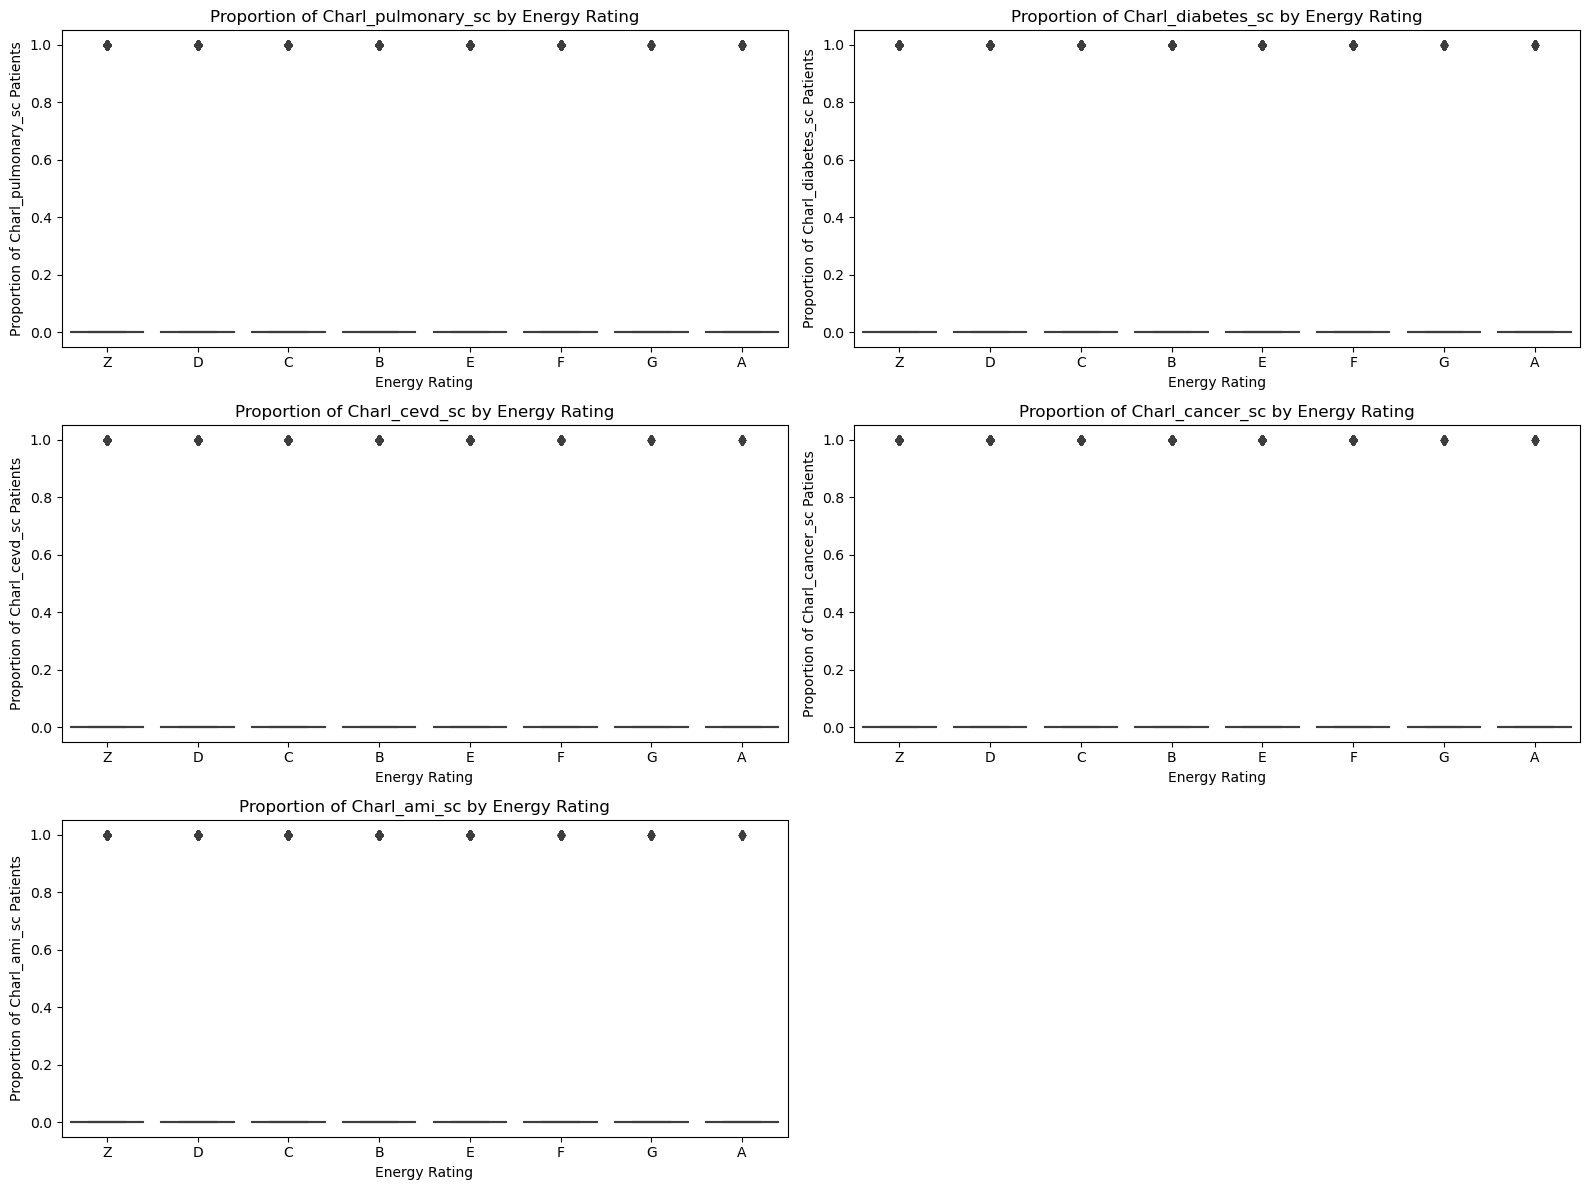

In [125]:

fig, axes = plt.subplots(3, 2, figsize=(16, 12))  
axes = axes.flatten()  # Flatten the axes for easy indexing


for i, cond in enumerate(Charlson_dominant_conditions):
    sns.boxplot(data=housingHealthnew, x='current_energy_rating', y=cond, ax=axes[i])
    axes[i].set_title(f'Proportion of {cond} by Energy Rating')
    axes[i].set_xlabel('Energy Rating')
    axes[i].set_ylabel(f'Proportion of {cond} Patients')

# Remove the last empty subplot if necessary
if len(Charlson_dominant_conditions) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout() 
plt.show()

In [126]:
housingHealthnew['Charlson_Score_Aggregate'] = housingHealthnew[[
    'Charl_ami_sc', 'Charl_chf_sc', 'Charl_pvd_sc', 'Charl_cevd_sc', 'Charl_dementia_sc',
    'Charl_pulmonary_sc', 'Charl_Connective_Tissue_sc', 'Charl_Peptic_Ulcer_sc', 'Charl_liver_disease_sc',
    'Charl_diabetes_sc', 'Charl_Complications_Diabetes_sc', 'Charl_Hemiplegia_sc', 'Charl_renal_disease_sc',
    'Charl_cancer_sc', 'Charl_sever_liver_disease_sc', 'Charl_Metastatic_cancer_sc', 'Charl_aids_sc'
]].sum(axis=1)

Correlation between Energy Efficiency and Aggregate Charlson Score: -0.0955784164219847


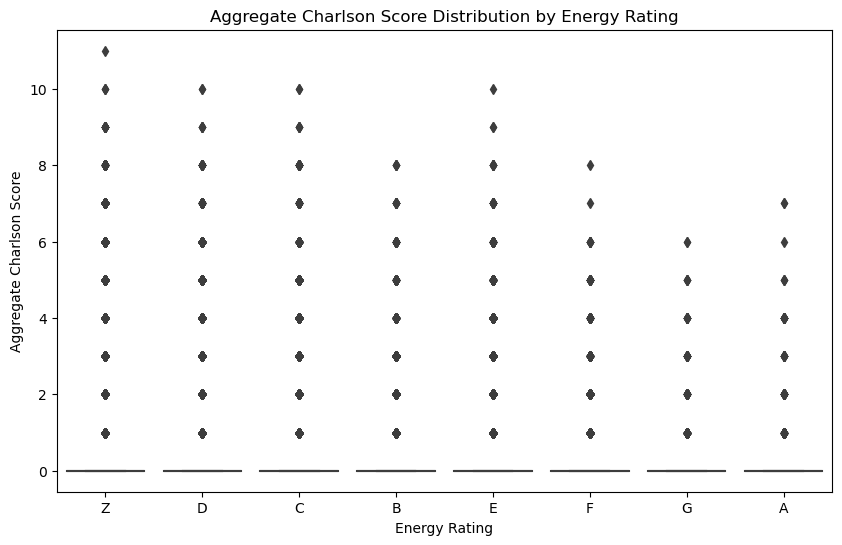

In [127]:
corr_efficiency_charlson_agg = housingHealthnew['current_energy_efficiency'].corr(housingHealthnew['Charlson_Score_Aggregate'], method='pearson')
print(f"Correlation between Energy Efficiency and Aggregate Charlson Score: {corr_efficiency_charlson_agg}")

# Plot Energy Ratings vs Aggregate Charlson Score
plt.figure(figsize=(10, 6))
sns.boxplot(data=housingHealthnew, x='current_energy_rating', y='Charlson_Score_Aggregate')
plt.title('Aggregate Charlson Score Distribution by Energy Rating')
plt.xlabel('Energy Rating')
plt.ylabel('Aggregate Charlson Score')
plt.show()


In [128]:
# Count the number of residents with a Charlson score of 0
zero_charlson_count = housingHealthnew[housingHealthnew['Charlson_Score_Aggregate'] == 0].shape[0]
total_residents = housingHealthnew.shape[0]

# Calculate the proportion of residents with Charlson score 0
zero_charlson_percentage = (zero_charlson_count / total_residents) * 100
print(f"Percentage of residents with Charlson Score of 0: {zero_charlson_percentage:.2f}%")

Percentage of residents with Charlson Score of 0: 82.54%


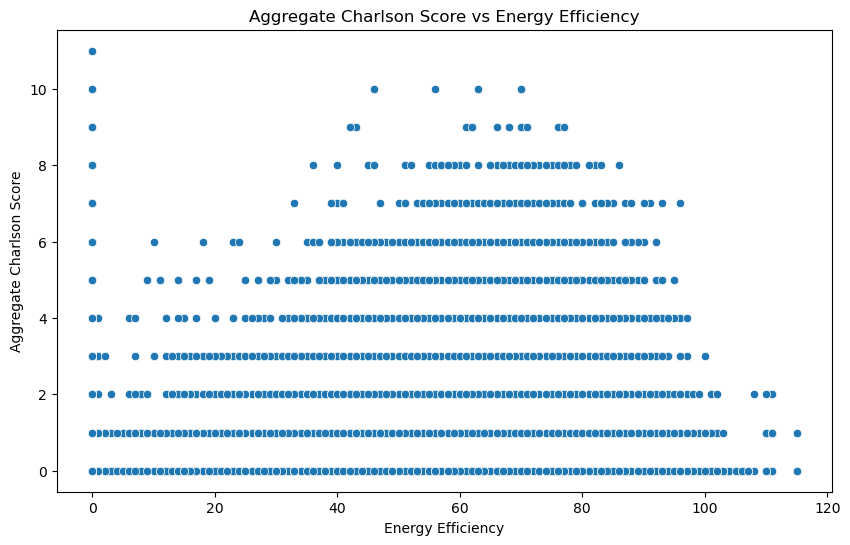

In [129]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=housingHealthnew, x='current_energy_efficiency', y='Charlson_Score_Aggregate')
plt.title('Aggregate Charlson Score vs Energy Efficiency')
plt.xlabel('Energy Efficiency')
plt.ylabel('Aggregate Charlson Score')
plt.show()

Correlation Matrix between Energy Efficiency and Charlson Components:


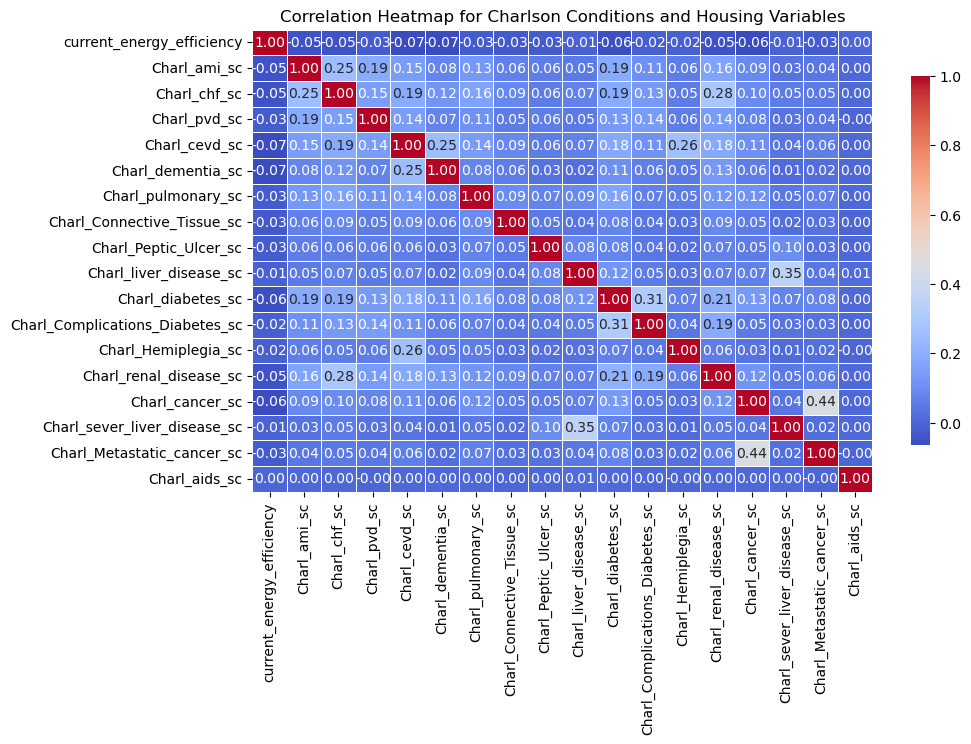

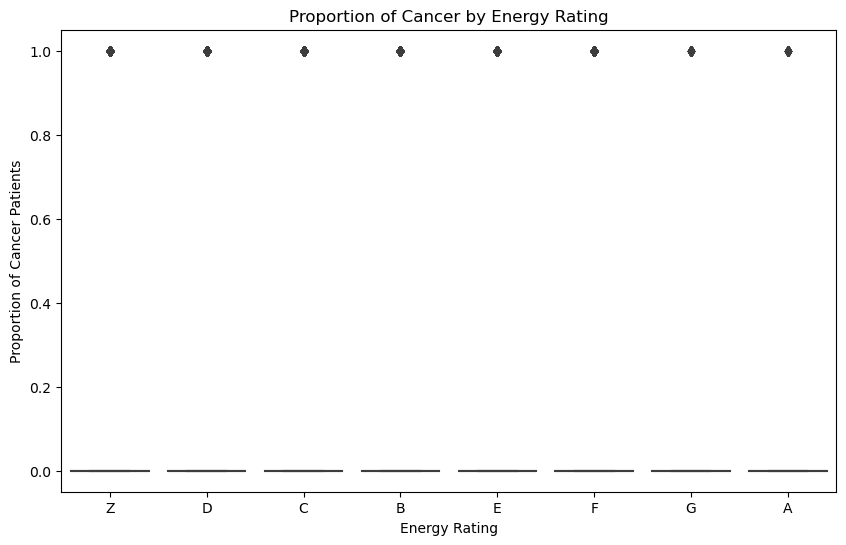

In [131]:
corr_matrix_charlson = housingHealthnew[['current_energy_efficiency'] + charlson_score].corr(method='pearson')
print("Correlation Matrix between Energy Efficiency and Charlson Components:")
#print(corr_matrix_charlson)
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_charlson, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap for Charlson Conditions and Housing Variables')
plt.show()


# Plot Energy Ratings vs a specific Charlson component (e.g., 'Charl_cancer_sc')
plt.figure(figsize=(10, 6))
sns.boxplot(data=housingHealthnew, x='current_energy_rating', y='Charl_cancer_sc')
plt.title('Proportion of Cancer by Energy Rating')
plt.xlabel('Energy Rating')
plt.ylabel('Proportion of Cancer Patients')
plt.show()

Correlation Matrix:


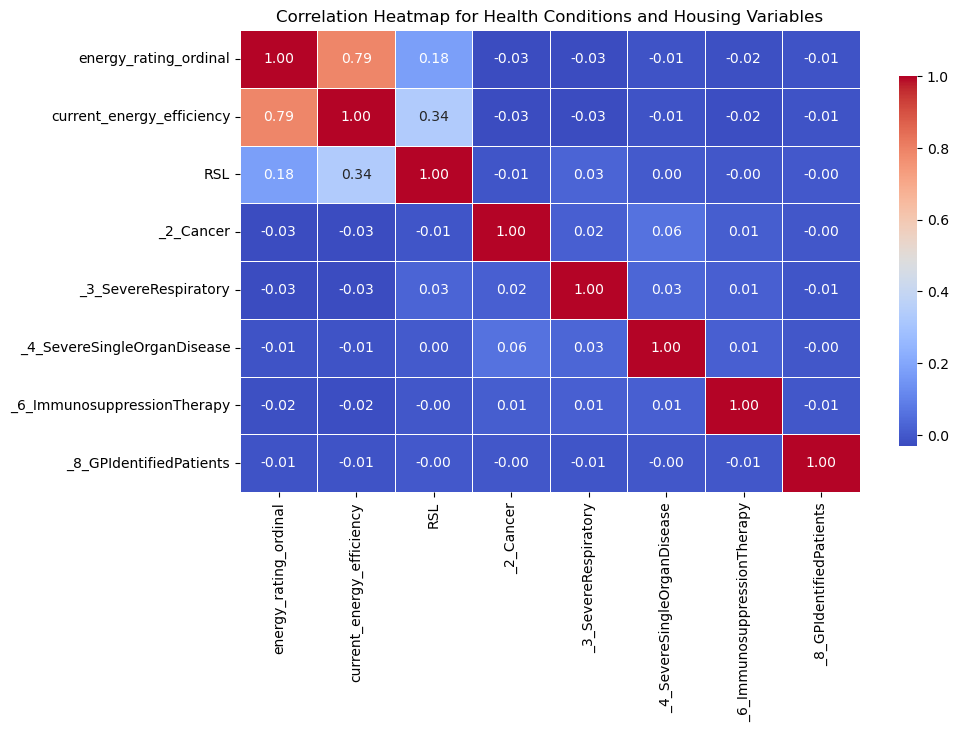

                             OLS Regression Results                             
Dep. Variable:     _3_SevereRespiratory   R-squared:                       0.002
Model:                              OLS   Adj. R-squared:                  0.002
Method:                   Least Squares   F-statistic:                     360.4
Date:                  Thu, 19 Sep 2024   Prob (F-statistic):          7.50e-234
Time:                          06:44:24   Log-Likelihood:             3.4772e+05
No. Observations:                492708   AIC:                        -6.954e+05
Df Residuals:                    492704   BIC:                        -6.954e+05
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
co

In [132]:

# Convert `current_energy_rating` to numerical values for analysis (ordinal encoding)
rating_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'Z': 0}
housingHealthnew['energy_rating_ordinal'] = housingHealthnew['current_energy_rating'].map(rating_map)

# Correlation Analysis - Correlate Health Conditions with energy rating, energy efficiency, and RSL
health_conditions = ['_2_Cancer', '_3_SevereRespiratory', '_4_SevereSingleOrganDisease',
     '_6_ImmunosuppressionTherapy', '_8_GPIdentifiedPatients']

# Correlation matrix for continuous variables
corr_matrix = housingHealthnew[['energy_rating_ordinal', 'current_energy_efficiency', 'RSL'] + health_conditions].corr(method='pearson')
print("Correlation Matrix:")
#print(corr_matrix)

# Draw the heatmap for the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap for Health Conditions and Housing Variables')
plt.show()

# Regression Analysis - Set up for regression
X = housingHealthnew[['energy_rating_ordinal', 'current_energy_efficiency', 'RSL']]  # Independent variables
y = housingHealthnew['_3_SevereRespiratory']  # Example dependent variable (replace with others for each health condition)

#Add a constant to the model (for intercept)
X = sm.add_constant(X)

#  Perform linear regression using statsmodels
model = sm.OLS(y, X).fit()

#  Output the results of the regression
print(model.summary())

# Check for model accuracy and prediction (using train/test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
reg_model = LinearRegression().fit(X_train, y_train)

# Make predictions
y_pred = reg_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

In [133]:
# Regression Analysis - Set up for regression
X = housingHealthnew[['energy_rating_ordinal', 'current_energy_efficiency', 'RSL']]  # Independent variables
y = housingHealthnew['_2_Cancer']  # Example dependent variable (replace with others for each health condition)

# Add a constant to the model (for intercept)
X = sm.add_constant(X)

# Perform linear regression using statsmodels
model = sm.OLS(y, X).fit()

# Output the results of the regression
print(model.summary())

# Check for model accuracy and prediction (using train/test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
reg_model = LinearRegression().fit(X_train, y_train)

# Make predictions
y_pred = reg_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

                            OLS Regression Results                            
Dep. Variable:              _2_Cancer   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     169.5
Date:                Thu, 19 Sep 2024   Prob (F-statistic):          8.18e-110
Time:                        06:44:38   Log-Likelihood:             5.2136e+05
No. Observations:              492708   AIC:                        -1.043e+06
Df Residuals:                  492704   BIC:                        -1.043e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Correlation Matrix:


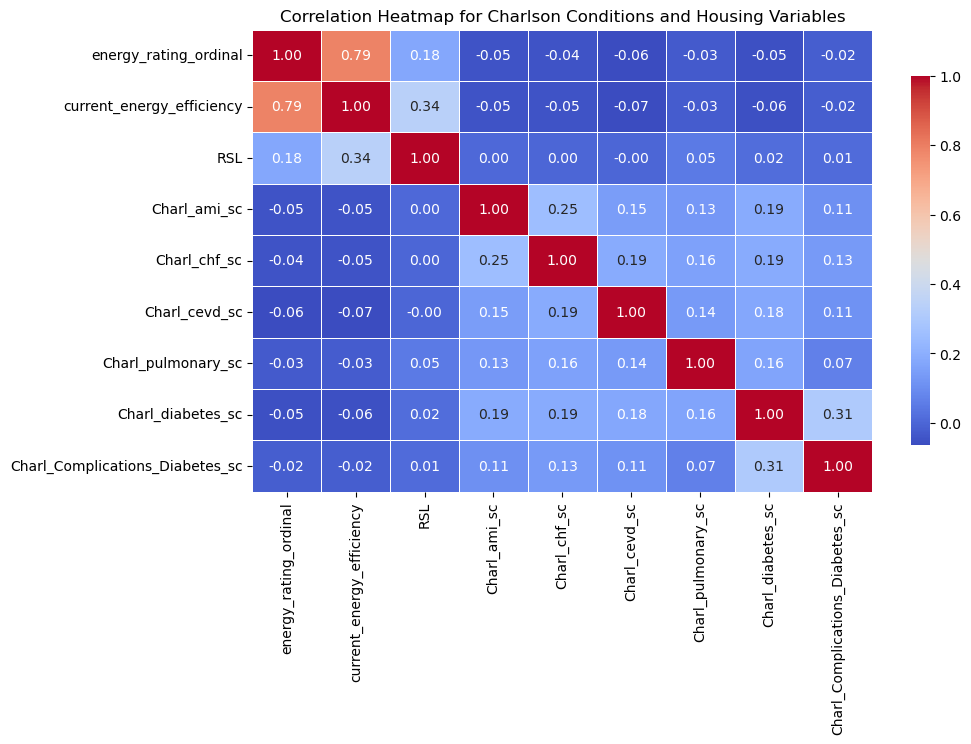

                            OLS Regression Results                            
Dep. Variable:     Charl_pulmonary_sc   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     728.2
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        06:44:56   Log-Likelihood:                -63029.
No. Observations:              492708   AIC:                         1.261e+05
Df Residuals:                  492704   BIC:                         1.261e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [134]:

# Convert `current_energy_rating` to numerical values for analysis (ordinal encoding)
rating_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'Z': 0}
housingHealthnew['energy_rating_ordinal'] = housingHealthnew['current_energy_rating'].map(rating_map)

# Correlation Analysis - Correlate Charlson Conditions with energy rating, energy efficiency, and RSL

charlson_score = [
    'Charl_ami_sc', 'Charl_chf_sc',  'Charl_cevd_sc', 'Charl_pulmonary_sc',
    'Charl_diabetes_sc', 'Charl_Complications_Diabetes_sc']

# Correlation matrix for continuous variables
corr_matrix = housingHealthnew[['energy_rating_ordinal', 'current_energy_efficiency', 'RSL'] + charlson_score].corr(method='pearson')
print("Correlation Matrix:")
#print(corr_matrix)

# Draw the heatmap for the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap for Charlson Conditions and Housing Variables')
plt.show()

# Regression Analysis - Set up for regression
X = housingHealthnew[['energy_rating_ordinal', 'current_energy_efficiency', 'RSL']]  # Independent variables
y = housingHealthnew['Charl_pulmonary_sc']  # Example dependent variable (replace with others for each Charlson condition)

#Add a constant to the model (for intercept)
X = sm.add_constant(X)

#  Perform linear regression using statsmodels
model = sm.OLS(y, X).fit()

#  Output the results of the regression
print(model.summary())

# Check for model accuracy and prediction (using train/test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
reg_model = LinearRegression().fit(X_train, y_train)

# Make predictions
y_pred = reg_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

In [135]:
# Regression Analysis - Set up for regression
X = housingHealthnew[['energy_rating_ordinal', 'current_energy_efficiency', 'RSL']]  # Independent variables
y = housingHealthnew['Charl_chf_sc']  # Example dependent variable (replace with others for each Charlson condition)

#Add a constant to the model (for intercept)
X = sm.add_constant(X)

#  Perform linear regression using statsmodels
model = sm.OLS(y, X).fit()

#  Output the results of the regression
print(model.summary())

# Check for model accuracy and prediction (using train/test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
reg_model = LinearRegression().fit(X_train, y_train)

# Make predictions
y_pred = reg_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

                            OLS Regression Results                            
Dep. Variable:           Charl_chf_sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     416.4
Date:                Thu, 19 Sep 2024   Prob (F-statistic):          3.64e-270
Time:                        06:45:09   Log-Likelihood:             3.0907e+05
No. Observations:              492708   AIC:                        -6.181e+05
Df Residuals:                  492704   BIC:                        -6.181e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [136]:
# Regression Analysis - Set up for regression
X = housingHealthnew[['energy_rating_ordinal', 'current_energy_efficiency', 'RSL']]  # Independent variables
y = housingHealthnew['Charl_diabetes_sc']  # Example dependent variable (replace with others for each Charlson condition)

#Add a constant to the model (for intercept)
X = sm.add_constant(X)

#  Perform linear regression using statsmodels
model = sm.OLS(y, X).fit()

#  Output the results of the regression
print(model.summary())

# Check for model accuracy and prediction (using train/test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
reg_model = LinearRegression().fit(X_train, y_train)

# Make predictions
y_pred = reg_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

                            OLS Regression Results                            
Dep. Variable:      Charl_diabetes_sc   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     763.0
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        06:45:25   Log-Likelihood:                 76082.
No. Observations:              492708   AIC:                        -1.522e+05
Df Residuals:                  492704   BIC:                        -1.521e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

### RQ.7 •	Can confounding factors, such as age, be controlled for and do they override any relationship with tenure?

In [137]:
#  independent variables (age and tenure) and the dependent variable (outcome)
X = housingHealthnew[['age_in_years_midpoint', 'RSL']]  
y = housingHealthnew['total_admits']  


X = sm.add_constant(X)


model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_admits   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     7777.
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        06:45:35   Log-Likelihood:            -1.0819e+06
No. Observations:              492708   AIC:                         2.164e+06
Df Residuals:                  492705   BIC:                         2.164e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.16

<lifelines.CoxPHFitter: fitted with 492708 total observations, 473829 right-censored observations>
             duration col = 'age_in_years_midpoint'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 492708
number of events observed = 18879
   partial log-likelihood = -200823.54
         time fit was run = 2024-09-19 05:56:11 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
RSL        0.72      2.05      0.02            0.67            0.76                1.95                2.15

           cmp to     z      p  -log2(p)
covariate                               
RSL          0.00 30.19 <0.005    662.84
---
Concordance = 0.55
Partial AIC = 401649.07
log-likelihood ratio test = 757.73 on 1 df
-log2(p) of ll-ratio test = 551.70

<Axes: xlabel='log(HR) (95% CI)'>

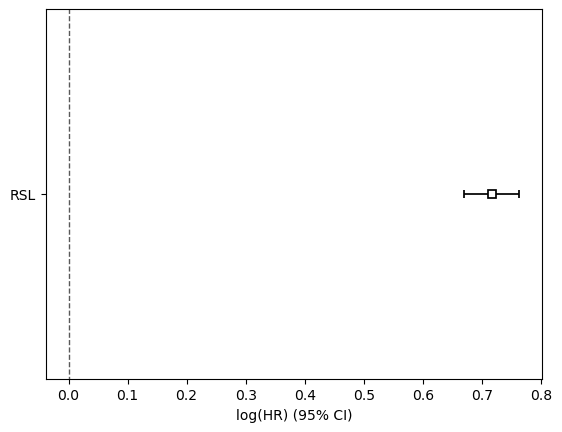

In [141]:
cph = CoxPHFitter()

housingHealthnew['event'] = housingHealthnew['year_of_death'].apply(lambda x: 1 if x != 0 else 0)

cph.fit(housingHealthnew[['age_in_years_midpoint', 'RSL', 'event']], duration_col='age_in_years_midpoint', event_col='event')

# Display the results of the Cox model
cph.print_summary()

# Plot the survival curves by tenure controlling for age
cph.plot()

### **OLS Regression Analysis**

Age and housing tenure (RSL) were two independent variables that inhibits this study to predict the dependent variable: total hospital admissions. The regression model sought to determine if there is an interaction between age and housing tenure such that the impact of housing tenure on hospital admissions is controlled or not by age.

**Key Findings from the OLS Model:**

•	Age (age_in_years_midpoint): Age has a statistically significant correlation with the total number of hospital admissions, as indicated by the coefficient of 0.0157 with a p-value of less than 0.05. This shows that, whereas the effect is negligible, older people tend to have a little higher rate of hospital admissions.

•	Housing Tenure (RSL): Even after age is considered, the RSL coefficient of 0.3816 and p-value of less than 0.05 show that residing in social housing is linked to significantly higher hospital admissions than non-social housing residents. This show that tenure explain part of health and that residents of social housing have more admissions.

•	Model Performance: With an R-squared of 0.031, the model accounts for 3.1% of the variation in the overall number of hospital admissions. Thus, the explained variance is low; however, the level of explained variance is quite acceptable for most studies in social and health research due to the impact of the great number of unmeasured variables on the result.

Consequently, the findings of this study indicate that age and housing tenure are contributing factors in hospitalization. However, the relationship between tenure and admissions remains significant controlling for age, this suggests that social housing status significantly determines increased hospital admissions.

### **Cox Proportional Hazards Model**

Due to the relationship between age and survival, coupled with housing tenure, the authors used a Cox Proportional Hazards Model analysis. This model tested the probability of an event of death with age and tenure, enabling the analysis of survival influence of tenure other than age.

**Key Findings from the Cox Model:**

•	Hazard Ratio for Housing Tenure (RSL): Using Cox proportional hazard model to analyse the data the resulting hazard ratio (HR) for RSL is 2.05 with a p-value below 0.05. According to the study, its indicates that residents in social housing are more than twice likely to die compared to those dwelling in other categories of housing. The confidence interval 
(CI: 1.95–2.15), hence implying a highly significant effect.

•	Model Performance: Identical results are observed with the concordance score which is equal to 0. 55, this shows that the from the model has a good test in being able to predict survival outcomes.

Housing tenure is a significant determinant of mortality risk after controlling for age. Residents of social housing demonstrated increased mortality rates, and thus tenure remains a predictor of survival. This serves to indicate that other factors linked with occupancy in social housing, including socioeconomic status, might be playing a part in this higher risk of early mortality than would be evidenced by age.

**Age as a Confounding Factor**

The age was therefore included as a covariate in both the OLS regression model and Cox models to test whether it has a masking effect on the tenure outcome variable (Hospital admission and mortality rates). But even when the age factor was included in the model, both the tenure of service and tenure of enrolment had a positive correlation with both the hospital admission and mortality rates.

The findings of the analysis depict that even though age is influential to both the admission in the hospitals and mortality rate, they do not dominate the effects of housing tenure. Social housing at the time of writing continues to be suggested to be a good predictor of both greater hospitalization and a higher mortality rate, even after controlling for age. What is implied here is that non-housing attributes which are associated with social housing – living conditions, access to health care, or socio-economic status might influence adverse health of residents of social housing on their own. Thus, measures that would assist in changes of the living conditions of residents of the social housing and enhancements of their access to healthcare services might help to decrease these disparities.
